<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#def_pytorch" data-toc-modified-id="def_pytorch-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>def_pytorch</a></span></li><li><span><a href="#ModelSet" data-toc-modified-id="ModelSet-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>ModelSet</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#rescale" data-toc-modified-id="rescale-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>rescale</a></span></li><li><span><a href="#single_main" data-toc-modified-id="single_main-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>single_main</a></span></li><li><span><a href="#single_func" data-toc-modified-id="single_func-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>single_func</a></span></li><li><span><a href="#apply_ufunc---Change" data-toc-modified-id="apply_ufunc---Change-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>apply_ufunc - Change</a></span></li><li><span><a href="#model_id" data-toc-modified-id="model_id-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>model_id</a></span></li><li><span><a href="#all_main" data-toc-modified-id="all_main-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>all_main</a></span></li><li><span><a href="#simple-analyze" data-toc-modified-id="simple-analyze-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>simple analyze</a></span></li><li><span><a href="#defective-run" data-toc-modified-id="defective-run-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>defective run</a></span><ul class="toc-item"><li><span><a href="#ModelSet_de" data-toc-modified-id="ModelSet_de-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>ModelSet_de</a></span></li><li><span><a href="#single_main_de" data-toc-modified-id="single_main_de-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>single_main_de</a></span></li><li><span><a href="#single_func_de" data-toc-modified-id="single_func_de-11.3"><span class="toc-item-num">11.3&nbsp;&nbsp;</span>single_func_de</a></span></li><li><span><a href="#apply_ufunc_de" data-toc-modified-id="apply_ufunc_de-11.4"><span class="toc-item-num">11.4&nbsp;&nbsp;</span>apply_ufunc_de</a></span></li><li><span><a href="#model_id" data-toc-modified-id="model_id-11.5"><span class="toc-item-num">11.5&nbsp;&nbsp;</span>model_id</a></span></li><li><span><a href="#all_main" data-toc-modified-id="all_main-11.6"><span class="toc-item-num">11.6&nbsp;&nbsp;</span>all_main</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import sys
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.nn import Module, LSTM, Linear
from torch.utils.data import DataLoader, TensorDataset
import hydroeval as he

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using the server's graphics card

# def_pytorch

In [8]:
class Net(Module):
    def __init__(self, config):
        super(Net, self).__init__()
        self.lstm = LSTM(input_size=config.input_size, hidden_size=config.hidden_size,
                         num_layers=config.lstm_layers, batch_first=True, dropout=config.dropout_rate)  # Define hidden layer
        self.linear = Linear(in_features=config.hidden_size, out_features=config.output_size)           # Define fully connected layer

    def forward(self, x, hidden=None):                # forward propagation function
        lstm_out, hidden = self.lstm(x, hidden)
        linear_out = self.linear(lstm_out)
        return linear_out, hidden


def train(config, train_and_valid_data):
    if config.do_train_visualized:
        import visdom
        vis = visdom.Visdom(env='def_pytorch')     # Whether to visualize

        
    global model_id
    model_name = 'model' + '_' + str(model_id) + '.pth'  # .pt and .pth are conventional formats
    
    train_X, train_Y, valid_X, valid_Y = train_and_valid_data
    train_X, train_Y = torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).float()  # 转为Tensor
    train_loader = DataLoader(TensorDataset(train_X, train_Y),
                              batch_size=config.batch_size)  # Generate trainable batch data

    valid_X, valid_Y = torch.from_numpy(valid_X).float(), torch.from_numpy(valid_Y).float()
    valid_loader = DataLoader(TensorDataset(valid_X, valid_Y), batch_size=config.batch_size)

    device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu")  # Decide whether to train on CPU or GPU

    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)   # Define optimizer
    criterion = torch.nn.MSELoss()  # Define loss

    valid_loss_min = float("inf")   # Define the initial positive infinity quantity
    bad_epoch = 0
    global_step = 0
    
    
#     print(train_X, train_Y)
    
    for epoch in range(config.epoch):
        model.train()  # Switch to training mode
        train_loss_array = []
        hidden_train = None
        for i, _data in enumerate(train_loader):
            _train_X, _train_Y = _data[0].to(device), _data[1].to(device)
            optimizer.zero_grad()  # Set gradient information to 0 before training
            pred_Y, hidden_train = model(_train_X, hidden_train)  # forward calculation
           
            hidden_train = None  # If training is non-continuous, reset hidden

            loss = criterion(pred_Y, _train_Y)  # Calculate loss
            loss.backward()  # Backpropagate loss
            optimizer.step()  # Update parameters with optimizer
            train_loss_array.append(loss.item())
            global_step += 1
            if config.do_train_visualized and global_step % 100 == 0:  # Displayed every 100 steps
                vis.line(X=np.array([global_step]), Y=np.array([loss.item()]), win='Train_Loss',
                         update='append' if global_step > 0 else None, name='Train', opts=dict(showlegend=True))

        # The following is an early stopping mechanism. When the model training does not improve 
        # the prediction effect of the validation set for consecutive config.patience epochs, it will stop to prevent overfitting.
        model.eval()  # Convert to prediction mode
        valid_loss_array = []
        hidden_valid = None
        for _valid_X, _valid_Y in valid_loader:
            _valid_X, _valid_Y = _valid_X.to(device), _valid_Y.to(device)
            pred_Y, hidden_valid = model(_valid_X, hidden_valid)
            hidden_valid = None
            loss = criterion(pred_Y, _valid_Y)  # The verification process only has forward calculation and no backpropagation process.
            valid_loss_array.append(loss.item())

        train_loss_cur = np.mean(train_loss_array)
        valid_loss_cur = np.mean(valid_loss_array)
#         print('epoch = ',epoch,' , train loss = ',train_loss_cur,' , valid loss = ',valid_loss_cur)

        if config.do_train_visualized:  # The first train_loss_cur is too large and is not displayed in visdom.
            vis.line(X=np.array([epoch]), Y=np.array([train_loss_cur]), win='Epoch_Loss',
                     update='append' if epoch > 0 else None, name='Train', opts=dict(showlegend=True))
            vis.line(X=np.array([epoch]), Y=np.array([valid_loss_cur]), win='Epoch_Loss',
                     update='append' if epoch > 0 else None, name='Eval', opts=dict(showlegend=True))

        if valid_loss_cur < valid_loss_min:    # Initial value is positive infinity
            valid_loss_min = valid_loss_cur    # gradually shrink
            bad_epoch = 0
            torch.save(model.state_dict(), config.model_save_path + model_name)  # Model save
            if valid_loss_cur < 1e-5:
                break
        else:
            bad_epoch += 1
            if bad_epoch >= config.patience:  # If the validation set index does not improve for consecutive epochs, 
                                              # the training will be stopped.
                break
#     print('save model as ',model_name) 


def predict(config, test_X):
    
    global model_id
    model_name = 'model' + '_' + str(model_id) + '.pth'  
    
    # Get test data
    test_X = torch.from_numpy(test_X).float()
    test_set = TensorDataset(test_X)
    test_loader = DataLoader(test_set, batch_size=config.batch_size)

    # Load model
    device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu")
    model = Net(config).to(device)
    model.load_state_dict(torch.load(config.model_save_path + model_name))  # Load model parameters

    # First define a tensor to save the prediction results
    result = torch.Tensor().to(device)

    # Forecasting process
    model.eval()
    hidden_predict = None
    for _data in test_loader:
        data_X = _data[0].to(device)
        pred_X, hidden_predict = model(data_X, hidden_predict)
        cur_pred = torch.squeeze(pred_X, dim=0)
        result = torch.cat((result, cur_pred), dim=0)

    return result.detach().cpu().numpy()  # First remove the gradient information. If you want to transfer it to the cpu on the gpu,
                                          # finally return the numpy data.

# ModelSet

In [9]:
class ModelSet:

    # Data parameters

    start_feature = 0
    end_feature = 3
    start_label = 3
    end_label = 5
    delay_day = 0             # Delay prediction by a few days, for example, use today’s data to predict tomorrow’s data, delay_day = 1
                              # Here today's driving data is used to predict today's runoff, so delay_day = 0

    # Division of training test set and prediction set
    start_train_and_valid_date_relative = 0
    end_train_and_valid_date_relative = 144     # 2000-01-01 to 2013-12-31 training, # 2014-01-01 to 2017-12-31 verification
    
    start_test_date_relative = 0
    end_test_date_relative = 1212

    # Network parameters
    input_size = end_feature -start_feature
    output_size = end_label -start_label

    # some hyperparameters
    hidden_size = 150
    lstm_layers = 2
    dropout_rate = 0.4
    time_step = 50

    # training parameters
    do_train = True     # Whether to train
    do_test = True          # Verify or not

    shuffle_train_data = False
    use_cuda = True

    train_data_rate = 0.7
    valid_data_rate = 1-train_data_rate

    batch_size = 24
    learning_rate = 0.001
    epoch = 256
    patience = 5                # How many epochs should be trained? Stop if the validation set does not improve.
    random_seed = 666           # Random seeds, guaranteed to be reproducible

    # path parameters
    model_save_path = '/group1/longjs/7-river-data/model_save/'
 
    do_train_visualized = False
    do_pred_save_to_file = False

    # Create a directory
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

# Data

In [10]:
class Data:
    def __init__(self, config , tair , prec , mass , runoff , et ):
        self.config = config
        self.tair = tair
        self.prec = prec
        self.mass = mass
        self.runoff = runoff
        self.et = et

        self.data_start_train_and_valid_num = self.config.start_train_and_valid_date_relative
        self.data_end_train_and_valid_num = self.config.end_train_and_valid_date_relative
        self.data_start_pred_num = self.config.start_test_date_relative
        self.data_stop_pred_num = self.config.end_test_date_relative     # The above times are based on the time of the original file

        self.train_and_valid_num_end = self.data_end_train_and_valid_num-self.data_start_train_and_valid_num
        self.train_num_end = int(self.train_and_valid_num_end * self.config.train_data_rate)
        self.pred_num_start = self.data_start_pred_num - self.data_start_train_and_valid_num
        self.pred_num_end = self.data_stop_pred_num - self.data_start_train_and_valid_num    # all relative to the time of extracting the data set.

        self.data_raw = pd.DataFrame({'tair':self.tair,
                                     'prec':self.prec,
                                     'mass':self.mass,
                                     'runoff':self.runoff,
                                     'et':self.et})    # Receive data and convert it
                
        self.data = self.data_raw[self.data_start_train_and_valid_num:self.data_stop_pred_num]      # Get the intercepted file
                                                                                                    # Includes training test set and prediction set
        self.mean = np.nanmean(self.data, axis=0)              # The mean and variance of the data
        self.std = np.nanstd(self.data, axis=0)
        self.norm_data = (self.data - self.mean)/self.std   # Normalization, de-dimensionalization
        self.norm_data = self.norm_data.fillna(0)

        self.start_num_in_test = 0      # Data from the first few days in the test set will be deleted because it is not enough for one time_step


    def get_train_and_valid_data(self):
        feature_data = self.norm_data.iloc[:self.train_num_end,self.config.start_feature:self.config.end_feature]
        label_data = self.norm_data.iloc[self.config.delay_day : self.config.delay_day + self.train_num_end,
                                    self.config.start_label:self.config.end_label]    
        # Use the data delayed a few days as the label. The default is the runoff data of the day.
        
        train_x = [feature_data[i:i+self.config.time_step] for i in range(self.train_num_end-self.config.time_step)]
        train_y = [label_data[i:i+self.config.time_step] for i in range(self.train_num_end-self.config.time_step)]

        train_x, train_y = np.array(train_x), np.array(train_y)
        train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=self.config.valid_data_rate,
                                                              random_state=self.config.random_seed,
                                                              shuffle=self.config.shuffle_train_data)   # Divide training and validation sets

        return train_x, valid_x, train_y, valid_y

    def get_test_data(self):
        feature_data = self.norm_data.iloc[self.pred_num_start:self.pred_num_end,self.config.start_feature:self.config.end_feature]
        sample_interval = min(feature_data.shape[0], self.config.time_step)     # Prevent time_step from being larger than the number of test sets
        self.start_num_in_test = feature_data.shape[0] % sample_interval  # There is not enough data these days for one sample_interval
        time_step_size = feature_data.shape[0] // sample_interval

        # In the test data, each time_step row of data will be used as a sample, and the two samples are staggered by time_step rows.
        test_x = [feature_data[self.start_num_in_test+i*sample_interval : self.start_num_in_test+(i+1)*sample_interval]
                   for i in range(time_step_size)]
        return np.array(test_x)

# rescale

In [11]:
def rescale_and_evaluate(config: ModelSet, origin_data: Data,  predict_norm_data: np.ndarray):

    predict_norm_data_reshape = predict_norm_data.reshape((-1,config.output_size))   # Become two-dimensional (time, prediction items, such as runoff, etc.)
    predict_data = predict_norm_data_reshape * origin_data.std[config.start_label:config.end_label] + \
                   origin_data.mean[config.start_label:config.end_label]   # Restore data by saved mean and variance
    
    runoff = []
    et = []
    for i in range(len(predict_data)):
        runoff = np.append(runoff,predict_data[i][0])
        et = np.append(et,predict_data[i][1])
    
    if config.do_pred_save_to_file:
        pd.DataFrame(predict_data).to_csv(config.pred_save_path+'predict'+str(model_id)+'.csv') # save csv file
    
    return runoff,et

# single_main

In [15]:
defective_id = []

In [16]:
def nse_value(s, o):
    nse = he.evaluator(he.nse, s, o)
    return nse

def main(config, tair , prec , mass , runoff , et):
    np.random.seed(config.random_seed)  # Set random seeds to ensure reproducibility
    data_gainer = Data(config, tair , prec , mass , runoff , et)
    
    global defective_id
    global model_id
    
    nse_all_finall_et = -100
    nse_all_finall_runoff = -100
    nse_target_et = 0.6
    nse_target_runoff = 0.4
    nse_count = 0
    nse_count_all = 10
    loop_count = 0
  
    while ((nse_all_finall_et < nse_target_et) and (nse_all_finall_runoff < nse_target_runoff)) and (nse_count<nse_count_all): 

        if config.do_train:
            train_X, valid_X, train_Y, valid_Y = data_gainer.get_train_and_valid_data()
            train(config, [train_X, train_Y, valid_X, valid_Y])

        if config.do_test:
            test_X = data_gainer.get_test_data()
            pred_result = predict(config, test_X)      # The output here is the unrestored normalized prediction data.
            predict_temp_runoff,predict_temp_et = rescale_and_evaluate(config, data_gainer, pred_result)

        nse_all_temp_runoff = nse_value(predict_temp_runoff[0:192],data_gainer.runoff[12:204])
        nse_train_temp_runoff = nse_value(predict_temp_runoff[0:132],data_gainer.runoff[12:144])
        nse_test_temp_runoff = nse_value(predict_temp_runoff[132:192],data_gainer.runoff[144:204])
                
        nse_all_temp_et = nse_value(predict_temp_et[0:192],data_gainer.et[12:204])
        nse_train_temp_et = nse_value(predict_temp_et[0:132],data_gainer.et[12:144])
        nse_test_temp_et = nse_value(predict_temp_et[132:192],data_gainer.et[144:204])
        
        
        if loop_count == 0:
            predict_finall_et = predict_temp_et
            predict_finall_runoff = predict_temp_runoff  

            nse_all_finall_runoff = nse_all_temp_runoff
            nse_train_finall_runoff = nse_train_temp_runoff
            nse_test_finall_runoff = nse_test_temp_runoff
                        
            nse_all_finall_et = nse_all_temp_et
            nse_train_finall_et = nse_train_temp_et
            nse_test_finall_et = nse_test_temp_et
            
        else:
            if nse_all_finall_et < nse_all_temp_et:
                predict_finall_et = predict_temp_et
                predict_finall_runoff = predict_temp_runoff

                nse_all_finall_runoff = nse_all_temp_runoff
                nse_train_finall_runoff = nse_train_temp_runoff
                nse_test_finall_runoff = nse_test_temp_runoff
                                
                nse_all_finall_et = nse_all_temp_et
                nse_train_finall_et = nse_train_temp_et
                nse_test_finall_et = nse_test_temp_et

                nse_count = 0
                
        loop_count += 1
        nse_count += 1
        
        print('now loop = {} , Runoff: temp nse_all = {:.3f} , curren nse_all = {:.3f}, nse_train = {:.3f}, nse_test = {:.3f}'
              .format(loop_count , nse_all_temp_runoff[0] , nse_all_finall_runoff[0] , nse_train_finall_runoff[0] , nse_test_finall_runoff[0]))    
        print('                   ET: temp nse_all = {:.3f} , curren nse_all = {:.3f}, nse_train = {:.3f}, nse_test = {:.3f}'
              .format(nse_all_temp_et[0] , nse_all_finall_et[0] , nse_train_finall_et[0] , nse_test_finall_et[0]))    
        print(' ')
        
    if nse_count > 9:
        defective_point = 1
        defective_id.append(model_id)
    else:
        defective_point = 0
        
    return predict_finall_runoff,predict_finall_et,nse_all_finall_runoff,nse_train_finall_runoff,nse_test_finall_runoff,nse_all_finall_et,nse_train_finall_et,nse_test_finall_et,defective_point

# single_func

In [20]:
predict_var_et = []
predict_var_runoff = []
def single_func(tair , prec , mass , runoff , et):
    get_model_id()   # Counter +1
    global model_id
    global predict_var_et
    global predict_var_runoff
    
    if np.isnan(runoff[0]):
        predict_finall_et = np.full(1200,np.nan)
        predict_finall_runoff = np.full(1200,np.nan)
        
        nse_all_runoff = np.nan
        nse_train_runoff = np.nan
        nse_test_runoff = np.nan
                
        nse_all_et = np.nan
        nse_train_et = np.nan
        nse_test_et = np.nan

        defective_point = np.nan
    else:
        predict_finall_runoff,predict_finall_et,nse_all_runoff,nse_train_runoff,nse_test_runoff,nse_all_et,nse_train_et,nse_test_et,defective_point = main(ModelSet(), tair , prec , mass , runoff , et)    
        print('finish run model_{}, runoff nse = {:.3f} , et nse = {:.3f}'.format(model_id,nse_all_runoff[0],nse_all_et[0]))
        print(' ')
        print('{:=^100s}'.format('Next'))
        print(' ')
    
    predict_var_runoff = np.append(predict_var_runoff,predict_finall_runoff)
    predict_var_et = np.append(predict_var_et,predict_finall_et)
    
    return nse_all_runoff,nse_train_runoff,nse_test_runoff,nse_all_et,nse_train_et,nse_test_et,defective_point

# apply_ufunc - Change

In [18]:
def grid_func():
    
    # Read grid data
    data_path = '/group1/longjs/7-river-data/'
    tair = xr.open_dataset(data_path+'tair/'+'UKESM1_0_LL_SSP245_tas_1985_2100.nc').sel(time=slice('2000-01-01','2100-12-31'))
    prec = xr.open_dataset(data_path+'prcp/'+'UKESM1_0_LL_SSP245_tp_1985_2100.nc').sel(time=slice('2000-01-01','2100-12-31'))
    mass = xr.open_dataset(data_path+'mass/'+'massbaltot_RCP45_2000_2100.nc').sel(time=slice('2000-01-01','2100-12-31'))
    runoff = xr.open_dataset(data_path+'ET-Runoff/'+'runoff_full_time_v4.nc').sel(time=slice('2000-01-01','2100-12-31'))
    et = xr.open_dataset(data_path+'ET-Runoff/'+'evaporation_full_time_v3.nc').sel(time=slice('2000-01-01','2100-12-31'))
    
    # Calculation
    nse_all_runoff,nse_train_runoff,nse_test_runoff,nse_all_et,nse_train_et,nse_test_et,defective_point = xr.apply_ufunc(single_func,
                          tair['tair'],prec['prcp'],mass['massbaltot'],runoff['runoff'],et['evaporation'],
                          input_core_dims=[['time'],['time'],['time'],['time'],['time']],
                          output_core_dims=[[],[],[],[],[],[],[]],
                          vectorize=True)
    
    # save
    nse_all_runoff.name = 'nse_all'
    nse_train_runoff.name = 'nse_train'
    nse_test_runoff.name = 'nse_test'
    
    nse_all_et.name = 'nse_all'
    nse_train_et.name = 'nse_train'
    nse_test_et.name = 'nse_test'
    
    defective_point.name = 'defective_point'
    
    nse_all_runoff.to_netcdf(data_path+'result/'+'ukesm1_245_nse_all_runoff.nc')
    nse_train_runoff.to_netcdf(data_path+'result/'+'ukesm1_245_nse_train_runoff.nc')
    nse_test_runoff.to_netcdf(data_path+'result/'+'ukesm1_245_nse_test_runoff.nc')
       
    nse_all_et.to_netcdf(data_path+'result/'+'ukesm1_245_nse_all_et.nc')
    nse_train_et.to_netcdf(data_path+'result/'+'ukesm1_245_nse_train_et.nc')
    nse_test_et.to_netcdf(data_path+'result/'+'ukesm1_245_nse_test_et.nc')

    
    defective_point.to_netcdf(data_path+'result/'+'ukesm1_245_defective_point_et.nc')

    global predict_var_runoff
    global predict_var_et

    pred_runoff = xr.Dataset({'runoff':(['time','lat','lon'],predict_var_runoff.reshape((60,140,1200)).transpose(2,0,1))},
                      coords={'lon':np.arange(70.125,105,0.25),
                              'lat':np.arange(25.125,40,0.25),
                              'time':pd.date_range('20010101','21001231',freq='M')})
    pred_et = xr.Dataset({'evaporation':(['time','lat','lon'],predict_var_et.reshape((60,140,1200)).transpose(2,0,1))},
                      coords={'lon':np.arange(70.125,105,0.25),
                              'lat':np.arange(25.125,40,0.25),
                              'time':pd.date_range('20010101','21001231',freq='M')})
    
    pred_runoff.to_netcdf(data_path+'result/'+'ukesm1_245_predict_runoff.nc')
    pred_et.to_netcdf(data_path+'result/'+'ukesm1_245_predict_et.nc')
 
    return pred_runoff,pred_et,nse_all_runoff,nse_train_runoff,nse_test_runoff,nse_all_et,nse_train_et,nse_test_et,defective_point

# model_id

In [19]:
model_id = 0
def get_model_id():
    global model_id
    model_id += 1
    return model_id

# all_main

In [518]:
pred_runoff,pred_et,nse_all_runoff,nse_train_runoff,nse_test_runoff,nse_all_et,nse_train_et,nse_test_et,defective_point = grid_func()

now loop = 1 , Runoff: temp nse_all = 0.450 , curren nse_all = 0.450, nse_train = 0.473, nse_test = 0.231
                   ET: temp nse_all = 0.769 , curren nse_all = 0.769, nse_train = 0.754, nse_test = 0.801
 
finish run model_1049, runoff nse = 0.450 , et nse = 0.769
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.170 , curren nse_all = 0.170, nse_train = 0.784, nse_test = -4.794
                   ET: temp nse_all = 0.828 , curren nse_all = 0.828, nse_train = 0.834, nse_test = 0.811
 
finish run model_1187, runoff nse = 0.170 , et nse = 0.828
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.672 , curren nse_all = 0.672, nse_train = 0.820, nse_test = 0.211
                   ET: temp nse_all = 0.848 , curren nse_all = 0.848, nse_train = 0.840, nse_test = 0.867
 
finish run model_1188, runoff

now loop = 1 , Runoff: temp nse_all = 0.629 , curren nse_all = 0.629, nse_train = 0.638, nse_test = 0.611
                   ET: temp nse_all = 0.771 , curren nse_all = 0.771, nse_train = 0.816, nse_test = 0.679
 
finish run model_1466, runoff nse = 0.629 , et nse = 0.771
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.859 , curren nse_all = 0.859, nse_train = 0.873, nse_test = 0.823
                   ET: temp nse_all = 0.860 , curren nse_all = 0.860, nse_train = 0.887, nse_test = 0.803
 
finish run model_1467, runoff nse = 0.859 , et nse = 0.860
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.859 , curren nse_all = 0.859, nse_train = 0.854, nse_test = 0.871
                   ET: temp nse_all = 0.790 , curren nse_all = 0.790, nse_train = 0.804, nse_test = 0.755
 
finish run model_1468, runoff 

now loop = 1 , Runoff: temp nse_all = 0.899 , curren nse_all = 0.899, nse_train = 0.923, nse_test = 0.830
                   ET: temp nse_all = 0.900 , curren nse_all = 0.900, nse_train = 0.911, nse_test = 0.876
 
finish run model_1605, runoff nse = 0.899 , et nse = 0.900
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.853 , curren nse_all = 0.853, nse_train = 0.845, nse_test = 0.874
                   ET: temp nse_all = 0.726 , curren nse_all = 0.726, nse_train = 0.744, nse_test = 0.689
 
finish run model_1606, runoff nse = 0.853 , et nse = 0.726
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.920 , curren nse_all = 0.920, nse_train = 0.942, nse_test = 0.869
                   ET: temp nse_all = 0.930 , curren nse_all = 0.930, nse_train = 0.945, nse_test = 0.896
 
finish run model_1607, runoff 

now loop = 1 , Runoff: temp nse_all = 0.761 , curren nse_all = 0.761, nse_train = 0.795, nse_test = 0.644
                   ET: temp nse_all = 0.868 , curren nse_all = 0.868, nse_train = 0.867, nse_test = 0.872
 
finish run model_1739, runoff nse = 0.761 , et nse = 0.868
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.835 , curren nse_all = 0.835, nse_train = 0.878, nse_test = 0.774
                   ET: temp nse_all = 0.758 , curren nse_all = 0.758, nse_train = 0.788, nse_test = 0.674
 
finish run model_1740, runoff nse = 0.835 , et nse = 0.758
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.848 , curren nse_all = 0.848, nse_train = 0.912, nse_test = 0.748
                   ET: temp nse_all = 0.932 , curren nse_all = 0.932, nse_train = 0.928, nse_test = 0.942
 
finish run model_1741, runoff 

now loop = 1 , Runoff: temp nse_all = 0.344 , curren nse_all = 0.344, nse_train = 0.455, nse_test = 0.123
                   ET: temp nse_all = 0.894 , curren nse_all = 0.894, nse_train = 0.929, nse_test = 0.808
 
finish run model_1756, runoff nse = 0.344 , et nse = 0.894
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.315 , curren nse_all = 0.315, nse_train = 0.502, nse_test = -0.227
                   ET: temp nse_all = 0.840 , curren nse_all = 0.840, nse_train = 0.842, nse_test = 0.834
 
finish run model_1757, runoff nse = 0.315 , et nse = 0.840
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.026 , curren nse_all = 0.026, nse_train = 0.319, nse_test = -1.217
                   ET: temp nse_all = 0.877 , curren nse_all = 0.877, nse_train = 0.899, nse_test = 0.837
 
finish run model_1758, runof

now loop = 1 , Runoff: temp nse_all = 0.327 , curren nse_all = 0.327, nse_train = 0.332, nse_test = 0.287
                   ET: temp nse_all = 0.759 , curren nse_all = 0.759, nse_train = 0.759, nse_test = 0.756
 
finish run model_1883, runoff nse = 0.327 , et nse = 0.759
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.604 , curren nse_all = 0.604, nse_train = 0.643, nse_test = 0.531
                   ET: temp nse_all = -0.037 , curren nse_all = -0.037, nse_train = 0.031, nse_test = -0.446
 
finish run model_1884, runoff nse = 0.604 , et nse = -0.037
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.349 , curren nse_all = 0.349, nse_train = 0.277, nse_test = 0.388
                   ET: temp nse_all = 0.841 , curren nse_all = 0.841, nse_train = 0.820, nse_test = 0.879
 
finish run model_1885, run

now loop = 1 , Runoff: temp nse_all = 0.145 , curren nse_all = 0.145, nse_train = 0.403, nse_test = -0.910
                   ET: temp nse_all = 0.881 , curren nse_all = 0.881, nse_train = 0.883, nse_test = 0.877
 
finish run model_1899, runoff nse = 0.145 , et nse = 0.881
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.399 , curren nse_all = 0.399, nse_train = 0.574, nse_test = -0.227
                   ET: temp nse_all = 0.872 , curren nse_all = 0.872, nse_train = 0.885, nse_test = 0.852
 
finish run model_1900, runoff nse = 0.399 , et nse = 0.872
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.568 , curren nse_all = 0.568, nse_train = 0.647, nse_test = 0.308
                   ET: temp nse_all = 0.760 , curren nse_all = 0.760, nse_train = 0.802, nse_test = 0.696
 
finish run model_1901, runof

now loop = 1 , Runoff: temp nse_all = 0.966 , curren nse_all = 0.966, nse_train = 0.966, nse_test = 0.966
                   ET: temp nse_all = 0.785 , curren nse_all = 0.785, nse_train = 0.821, nse_test = 0.696
 
finish run model_2019, runoff nse = 0.966 , et nse = 0.785
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.824 , curren nse_all = 0.824, nse_train = 0.849, nse_test = 0.749
                   ET: temp nse_all = 0.908 , curren nse_all = 0.908, nse_train = 0.940, nse_test = 0.848
 
finish run model_2020, runoff nse = 0.824 , et nse = 0.908
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.823 , curren nse_all = 0.823, nse_train = 0.881, nse_test = 0.641
                   ET: temp nse_all = 0.877 , curren nse_all = 0.877, nse_train = 0.925, nse_test = 0.768
 
finish run model_2021, runoff 

now loop = 3 , Runoff: temp nse_all = -0.016 , curren nse_all = -0.016, nse_train = -0.061, nse_test = -0.101
                   ET: temp nse_all = 0.462 , curren nse_all = 0.462, nse_train = 0.420, nse_test = 0.524
 
now loop = 4 , Runoff: temp nse_all = -0.011 , curren nse_all = -0.016, nse_train = -0.061, nse_test = -0.101
                   ET: temp nse_all = 0.449 , curren nse_all = 0.462, nse_train = 0.420, nse_test = 0.524
 
now loop = 5 , Runoff: temp nse_all = -0.006 , curren nse_all = -0.016, nse_train = -0.061, nse_test = -0.101
                   ET: temp nse_all = 0.412 , curren nse_all = 0.462, nse_train = 0.420, nse_test = 0.524
 
now loop = 6 , Runoff: temp nse_all = -0.016 , curren nse_all = -0.016, nse_train = -0.061, nse_test = -0.101
                   ET: temp nse_all = 0.422 , curren nse_all = 0.462, nse_train = 0.420, nse_test = 0.524
 
now loop = 7 , Runoff: temp nse_all = -0.015 , curren nse_all = -0.016, nse_train = -0.061, nse_test = -0.101
                  

now loop = 1 , Runoff: temp nse_all = 0.529 , curren nse_all = 0.529, nse_train = 0.643, nse_test = 0.168
                   ET: temp nse_all = 0.860 , curren nse_all = 0.860, nse_train = 0.876, nse_test = 0.830
 
finish run model_2048, runoff nse = 0.529 , et nse = 0.860
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.614 , curren nse_all = 0.614, nse_train = 0.678, nse_test = 0.414
                   ET: temp nse_all = 0.913 , curren nse_all = 0.913, nse_train = 0.919, nse_test = 0.901
 
finish run model_2049, runoff nse = 0.614 , et nse = 0.913
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.624 , curren nse_all = 0.624, nse_train = 0.772, nse_test = -0.217
                   ET: temp nse_all = 0.859 , curren nse_all = 0.859, nse_train = 0.882, nse_test = 0.822
 
finish run model_2051, runoff

now loop = 1 , Runoff: temp nse_all = 0.916 , curren nse_all = 0.916, nse_train = 0.940, nse_test = 0.874
                   ET: temp nse_all = 0.811 , curren nse_all = 0.811, nse_train = 0.898, nse_test = 0.502
 
finish run model_2152, runoff nse = 0.916 , et nse = 0.811
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -0.027 , curren nse_all = -0.027, nse_train = -0.010, nse_test = -0.093
                   ET: temp nse_all = 0.640 , curren nse_all = 0.640, nse_train = 0.659, nse_test = 0.587
 
finish run model_2153, runoff nse = -0.027 , et nse = 0.640
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -0.024 , curren nse_all = -0.024, nse_train = 0.019, nse_test = -0.123
                   ET: temp nse_all = 0.701 , curren nse_all = 0.701, nse_train = 0.691, nse_test = 0.724
 
finish run model_2154,

now loop = 1 , Runoff: temp nse_all = 0.309 , curren nse_all = 0.309, nse_train = 0.541, nse_test = 0.124
                   ET: temp nse_all = 0.789 , curren nse_all = 0.789, nse_train = 0.856, nse_test = 0.721
 
finish run model_2163, runoff nse = 0.309 , et nse = 0.789
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.569 , curren nse_all = 0.569, nse_train = 0.647, nse_test = 0.463
                   ET: temp nse_all = 0.662 , curren nse_all = 0.662, nse_train = 0.638, nse_test = 0.701
 
finish run model_2164, runoff nse = 0.569 , et nse = 0.662
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.530 , curren nse_all = 0.530, nse_train = 0.666, nse_test = 0.317
                   ET: temp nse_all = 0.515 , curren nse_all = 0.515, nse_train = 0.532, nse_test = 0.484
 
finish run model_2165, runoff 

now loop = 1 , Runoff: temp nse_all = 0.654 , curren nse_all = 0.654, nse_train = 0.757, nse_test = 0.452
                   ET: temp nse_all = 0.893 , curren nse_all = 0.893, nse_train = 0.915, nse_test = 0.853
 
finish run model_2186, runoff nse = 0.654 , et nse = 0.893
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.696 , curren nse_all = 0.696, nse_train = 0.769, nse_test = 0.523
                   ET: temp nse_all = 0.882 , curren nse_all = 0.882, nse_train = 0.902, nse_test = 0.845
 
finish run model_2187, runoff nse = 0.696 , et nse = 0.882
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.453 , curren nse_all = 0.453, nse_train = 0.493, nse_test = 0.324
                   ET: temp nse_all = 0.823 , curren nse_all = 0.823, nse_train = 0.839, nse_test = 0.789
 
finish run model_2188, runoff 

now loop = 1 , Runoff: temp nse_all = 0.784 , curren nse_all = 0.784, nse_train = 0.855, nse_test = 0.631
                   ET: temp nse_all = 0.865 , curren nse_all = 0.865, nse_train = 0.888, nse_test = 0.799
 
finish run model_2289, runoff nse = 0.784 , et nse = 0.865
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.757 , curren nse_all = 0.757, nse_train = 0.834, nse_test = 0.635
                   ET: temp nse_all = 0.907 , curren nse_all = 0.907, nse_train = 0.913, nse_test = 0.894
 
finish run model_2290, runoff nse = 0.757 , et nse = 0.907
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.679 , curren nse_all = 0.679, nse_train = 0.763, nse_test = 0.551
                   ET: temp nse_all = 0.920 , curren nse_all = 0.920, nse_train = 0.925, nse_test = 0.908
 
finish run model_2291, runoff 

now loop = 11 , Runoff: temp nse_all = 0.239 , curren nse_all = 0.309, nse_train = 0.535, nse_test = 0.225
                   ET: temp nse_all = -0.368 , curren nse_all = 0.399, nse_train = 0.611, nse_test = 0.263
 
now loop = 12 , Runoff: temp nse_all = 0.312 , curren nse_all = 0.309, nse_train = 0.535, nse_test = 0.225
                   ET: temp nse_all = 0.397 , curren nse_all = 0.399, nse_train = 0.611, nse_test = 0.263
 
now loop = 13 , Runoff: temp nse_all = 0.245 , curren nse_all = 0.309, nse_train = 0.535, nse_test = 0.225
                   ET: temp nse_all = -0.243 , curren nse_all = 0.399, nse_train = 0.611, nse_test = 0.263
 
now loop = 14 , Runoff: temp nse_all = 0.311 , curren nse_all = 0.309, nse_train = 0.535, nse_test = 0.225
                   ET: temp nse_all = 0.071 , curren nse_all = 0.399, nse_train = 0.611, nse_test = 0.263
 
finish run model_2305, runoff nse = 0.309 , et nse = 0.399
 
================================================Next=========================

now loop = 1 , Runoff: temp nse_all = 0.664 , curren nse_all = 0.664, nse_train = 0.778, nse_test = 0.421
                   ET: temp nse_all = 0.898 , curren nse_all = 0.898, nse_train = 0.908, nse_test = 0.878
 
finish run model_2325, runoff nse = 0.664 , et nse = 0.898
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.800 , curren nse_all = 0.800, nse_train = 0.875, nse_test = 0.633
                   ET: temp nse_all = 0.849 , curren nse_all = 0.849, nse_train = 0.889, nse_test = 0.783
 
finish run model_2326, runoff nse = 0.800 , et nse = 0.849
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.618 , curren nse_all = 0.618, nse_train = 0.593, nse_test = 0.656
                   ET: temp nse_all = 0.781 , curren nse_all = 0.781, nse_train = 0.800, nse_test = 0.735
 
finish run model_2327, runoff 

now loop = 9 , Runoff: temp nse_all = 0.173 , curren nse_all = 0.173, nse_train = 0.156, nse_test = 0.262
                   ET: temp nse_all = 0.019 , curren nse_all = 0.019, nse_train = 0.008, nse_test = -0.067
 
now loop = 10 , Runoff: temp nse_all = 0.147 , curren nse_all = 0.173, nse_train = 0.156, nse_test = 0.262
                   ET: temp nse_all = -0.083 , curren nse_all = 0.019, nse_train = 0.008, nse_test = -0.067
 
now loop = 11 , Runoff: temp nse_all = 0.042 , curren nse_all = 0.173, nse_train = 0.156, nse_test = 0.262
                   ET: temp nse_all = 0.000 , curren nse_all = 0.019, nse_train = 0.008, nse_test = -0.067
 
now loop = 12 , Runoff: temp nse_all = 0.166 , curren nse_all = 0.173, nse_train = 0.156, nse_test = 0.262
                   ET: temp nse_all = -0.141 , curren nse_all = 0.019, nse_train = 0.008, nse_test = -0.067
 
now loop = 13 , Runoff: temp nse_all = 0.049 , curren nse_all = 0.173, nse_train = 0.156, nse_test = 0.262
                   ET: temp 

now loop = 1 , Runoff: temp nse_all = 0.626 , curren nse_all = 0.626, nse_train = 0.676, nse_test = 0.544
                   ET: temp nse_all = 0.716 , curren nse_all = 0.716, nse_train = 0.725, nse_test = 0.701
 
finish run model_2337, runoff nse = 0.626 , et nse = 0.716
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.612 , curren nse_all = 0.612, nse_train = 0.677, nse_test = 0.502
                   ET: temp nse_all = 0.844 , curren nse_all = 0.844, nse_train = 0.860, nse_test = 0.811
 
finish run model_2338, runoff nse = 0.612 , et nse = 0.844
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.618 , curren nse_all = 0.618, nse_train = 0.601, nse_test = 0.652
                   ET: temp nse_all = 0.803 , curren nse_all = 0.803, nse_train = 0.830, nse_test = 0.753
 
finish run model_2339, runoff 

now loop = 13 , Runoff: temp nse_all = 0.121 , curren nse_all = 0.133, nse_train = 0.170, nse_test = 0.085
                   ET: temp nse_all = 0.491 , curren nse_all = 0.516, nse_train = 0.712, nse_test = 0.070
 
now loop = 14 , Runoff: temp nse_all = 0.121 , curren nse_all = 0.121, nse_train = 0.144, nse_test = 0.087
                   ET: temp nse_all = 0.519 , curren nse_all = 0.519, nse_train = 0.715, nse_test = 0.072
 
now loop = 15 , Runoff: temp nse_all = 0.118 , curren nse_all = 0.121, nse_train = 0.144, nse_test = 0.087
                   ET: temp nse_all = 0.485 , curren nse_all = 0.519, nse_train = 0.715, nse_test = 0.072
 
now loop = 16 , Runoff: temp nse_all = 0.127 , curren nse_all = 0.127, nse_train = 0.164, nse_test = 0.081
                   ET: temp nse_all = 0.521 , curren nse_all = 0.521, nse_train = 0.728, nse_test = 0.051
 
now loop = 17 , Runoff: temp nse_all = 0.123 , curren nse_all = 0.127, nse_train = 0.164, nse_test = 0.081
                   ET: temp nse_a

now loop = 1 , Runoff: temp nse_all = 0.490 , curren nse_all = 0.490, nse_train = 0.696, nse_test = -0.285
                   ET: temp nse_all = 0.825 , curren nse_all = 0.825, nse_train = 0.850, nse_test = 0.788
 
finish run model_2443, runoff nse = 0.490 , et nse = 0.825
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.391 , curren nse_all = 0.391, nse_train = 0.641, nse_test = -0.350
                   ET: temp nse_all = 0.909 , curren nse_all = 0.909, nse_train = 0.921, nse_test = 0.885
 
finish run model_2444, runoff nse = 0.391 , et nse = 0.909
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.341 , curren nse_all = 0.341, nse_train = 0.661, nse_test = 0.061
                   ET: temp nse_all = 0.799 , curren nse_all = 0.799, nse_train = 0.829, nse_test = 0.756
 
finish run model_2445, runof

now loop = 1 , Runoff: temp nse_all = 0.647 , curren nse_all = 0.647, nse_train = 0.694, nse_test = 0.412
                   ET: temp nse_all = 0.914 , curren nse_all = 0.914, nse_train = 0.939, nse_test = 0.862
 
finish run model_2452, runoff nse = 0.647 , et nse = 0.914
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.701 , curren nse_all = 0.701, nse_train = 0.793, nse_test = 0.338
                   ET: temp nse_all = 0.919 , curren nse_all = 0.919, nse_train = 0.932, nse_test = 0.891
 
finish run model_2453, runoff nse = 0.701 , et nse = 0.919
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.650 , curren nse_all = 0.650, nse_train = 0.676, nse_test = 0.569
                   ET: temp nse_all = 0.914 , curren nse_all = 0.914, nse_train = 0.933, nse_test = 0.870
 
finish run model_2454, runoff 

now loop = 9 , Runoff: temp nse_all = 0.150 , curren nse_all = 0.150, nse_train = 0.241, nse_test = 0.023
                   ET: temp nse_all = -0.069 , curren nse_all = -0.069, nse_train = 0.068, nse_test = -0.418
 
now loop = 10 , Runoff: temp nse_all = -0.031 , curren nse_all = 0.150, nse_train = 0.241, nse_test = 0.023
                   ET: temp nse_all = -0.152 , curren nse_all = -0.069, nse_train = 0.068, nse_test = -0.418
 
now loop = 11 , Runoff: temp nse_all = -0.050 , curren nse_all = 0.150, nse_train = 0.241, nse_test = 0.023
                   ET: temp nse_all = -0.161 , curren nse_all = -0.069, nse_train = 0.068, nse_test = -0.418
 
now loop = 12 , Runoff: temp nse_all = -0.047 , curren nse_all = 0.150, nse_train = 0.241, nse_test = 0.023
                   ET: temp nse_all = -0.145 , curren nse_all = -0.069, nse_train = 0.068, nse_test = -0.418
 
now loop = 13 , Runoff: temp nse_all = -0.043 , curren nse_all = 0.150, nse_train = 0.241, nse_test = 0.023
                  

now loop = 17 , Runoff: temp nse_all = 0.101 , curren nse_all = 0.144, nse_train = 0.234, nse_test = -0.096
                   ET: temp nse_all = -0.017 , curren nse_all = 0.061, nse_train = 0.099, nse_test = -0.135
 
now loop = 18 , Runoff: temp nse_all = 0.054 , curren nse_all = 0.144, nse_train = 0.234, nse_test = -0.096
                   ET: temp nse_all = -0.130 , curren nse_all = 0.061, nse_train = 0.099, nse_test = -0.135
 
now loop = 19 , Runoff: temp nse_all = 0.102 , curren nse_all = 0.144, nse_train = 0.234, nse_test = -0.096
                   ET: temp nse_all = -0.076 , curren nse_all = 0.061, nse_train = 0.099, nse_test = -0.135
 
finish run model_2471, runoff nse = 0.144 , et nse = 0.061
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.004 , curren nse_all = 0.004, nse_train = 0.065, nse_test = -0.117
                   ET: temp nse_all = -0.122 , curren nse_all = -0.122, nse

now loop = 23 , Runoff: temp nse_all = 0.348 , curren nse_all = 0.373, nse_train = 0.415, nse_test = 0.264
                   ET: temp nse_all = -0.086 , curren nse_all = 0.070, nse_train = 0.099, nse_test = -0.028
 
now loop = 24 , Runoff: temp nse_all = 0.348 , curren nse_all = 0.373, nse_train = 0.415, nse_test = 0.264
                   ET: temp nse_all = -0.071 , curren nse_all = 0.070, nse_train = 0.099, nse_test = -0.028
 
now loop = 25 , Runoff: temp nse_all = 0.341 , curren nse_all = 0.373, nse_train = 0.415, nse_test = 0.264
                   ET: temp nse_all = -0.106 , curren nse_all = 0.070, nse_train = 0.099, nse_test = -0.028
 
now loop = 26 , Runoff: temp nse_all = 0.380 , curren nse_all = 0.380, nse_train = 0.373, nse_test = 0.391
                   ET: temp nse_all = 0.082 , curren nse_all = 0.082, nse_train = 0.114, nse_test = -0.018
 
now loop = 27 , Runoff: temp nse_all = 0.348 , curren nse_all = 0.380, nse_train = 0.373, nse_test = 0.391
                   ET: tem

now loop = 5 , Runoff: temp nse_all = -0.546 , curren nse_all = -0.540, nse_train = -0.259, nse_test = -443.661
                   ET: temp nse_all = 0.174 , curren nse_all = 0.188, nse_train = 0.264, nse_test = -0.014
 
now loop = 6 , Runoff: temp nse_all = -2.929 , curren nse_all = -0.540, nse_train = -0.259, nse_test = -443.661
                   ET: temp nse_all = -0.018 , curren nse_all = 0.188, nse_train = 0.264, nse_test = -0.014
 
now loop = 7 , Runoff: temp nse_all = -0.597 , curren nse_all = -0.540, nse_train = -0.259, nse_test = -443.661
                   ET: temp nse_all = 0.179 , curren nse_all = 0.188, nse_train = 0.264, nse_test = -0.014
 
now loop = 8 , Runoff: temp nse_all = -0.610 , curren nse_all = -0.540, nse_train = -0.259, nse_test = -443.661
                   ET: temp nse_all = 0.180 , curren nse_all = 0.188, nse_train = 0.264, nse_test = -0.014
 
now loop = 9 , Runoff: temp nse_all = -0.442 , curren nse_all = -0.540, nse_train = -0.259, nse_test = -443.661
   

now loop = 1 , Runoff: temp nse_all = 0.496 , curren nse_all = 0.496, nse_train = 0.409, nse_test = 0.610
                   ET: temp nse_all = 0.899 , curren nse_all = 0.899, nse_train = 0.933, nse_test = 0.789
 
finish run model_2572, runoff nse = 0.496 , et nse = 0.899
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.336 , curren nse_all = 0.336, nse_train = 0.331, nse_test = 0.300
                   ET: temp nse_all = 0.762 , curren nse_all = 0.762, nse_train = 0.840, nse_test = 0.487
 
finish run model_2573, runoff nse = 0.336 , et nse = 0.762
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -0.208 , curren nse_all = -0.208, nse_train = 0.401, nse_test = -0.511
                   ET: temp nse_all = 0.796 , curren nse_all = 0.796, nse_train = 0.909, nse_test = 0.324
 
finish run model_2574, runo

now loop = 2 , Runoff: temp nse_all = -0.114 , curren nse_all = -0.107, nse_train = -0.107, nse_test = -0.247
                   ET: temp nse_all = 0.305 , curren nse_all = 0.339, nse_train = 0.529, nse_test = 0.125
 
now loop = 3 , Runoff: temp nse_all = -0.112 , curren nse_all = -0.107, nse_train = -0.107, nse_test = -0.247
                   ET: temp nse_all = 0.319 , curren nse_all = 0.339, nse_train = 0.529, nse_test = 0.125
 
now loop = 4 , Runoff: temp nse_all = -0.128 , curren nse_all = -0.107, nse_train = -0.107, nse_test = -0.247
                   ET: temp nse_all = 0.331 , curren nse_all = 0.339, nse_train = 0.529, nse_test = 0.125
 
now loop = 5 , Runoff: temp nse_all = -0.093 , curren nse_all = -0.107, nse_train = -0.107, nse_test = -0.247
                   ET: temp nse_all = 0.332 , curren nse_all = 0.339, nse_train = 0.529, nse_test = 0.125
 
now loop = 6 , Runoff: temp nse_all = -0.085 , curren nse_all = -0.107, nse_train = -0.107, nse_test = -0.247
                  

now loop = 1 , Runoff: temp nse_all = 0.386 , curren nse_all = 0.386, nse_train = 0.416, nse_test = 0.282
                   ET: temp nse_all = 0.848 , curren nse_all = 0.848, nse_train = 0.864, nse_test = 0.813
 
finish run model_2602, runoff nse = 0.386 , et nse = 0.848
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.697 , curren nse_all = 0.697, nse_train = 0.700, nse_test = 0.691
                   ET: temp nse_all = 0.839 , curren nse_all = 0.839, nse_train = 0.874, nse_test = 0.777
 
finish run model_2603, runoff nse = 0.697 , et nse = 0.839
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.725 , curren nse_all = 0.725, nse_train = 0.760, nse_test = 0.652
                   ET: temp nse_all = 0.911 , curren nse_all = 0.911, nse_train = 0.934, nse_test = 0.866
 
finish run model_2604, runoff 

now loop = 2 , Runoff: temp nse_all = 0.173 , curren nse_all = 0.173, nse_train = 0.281, nse_test = -0.660
                   ET: temp nse_all = 0.445 , curren nse_all = 0.445, nse_train = 0.463, nse_test = 0.395
 
now loop = 3 , Runoff: temp nse_all = 0.237 , curren nse_all = 0.237, nse_train = 0.351, nse_test = -0.624
                   ET: temp nse_all = 0.464 , curren nse_all = 0.464, nse_train = 0.487, nse_test = 0.407
 
now loop = 4 , Runoff: temp nse_all = 0.153 , curren nse_all = 0.237, nse_train = 0.351, nse_test = -0.624
                   ET: temp nse_all = 0.438 , curren nse_all = 0.464, nse_train = 0.487, nse_test = 0.407
 
now loop = 5 , Runoff: temp nse_all = 0.168 , curren nse_all = 0.237, nse_train = 0.351, nse_test = -0.624
                   ET: temp nse_all = 0.448 , curren nse_all = 0.464, nse_train = 0.487, nse_test = 0.407
 
now loop = 6 , Runoff: temp nse_all = 0.217 , curren nse_all = 0.237, nse_train = 0.351, nse_test = -0.624
                   ET: temp nse_a

now loop = 10 , Runoff: temp nse_all = -0.002 , curren nse_all = -0.010, nse_train = -0.014, nse_test = 0.474
                   ET: temp nse_all = 0.009 , curren nse_all = 0.044, nse_train = 0.023, nse_test = -10.260
 
now loop = 11 , Runoff: temp nse_all = -0.011 , curren nse_all = -0.010, nse_train = -0.014, nse_test = 0.474
                   ET: temp nse_all = 0.043 , curren nse_all = 0.044, nse_train = 0.023, nse_test = -10.260
 
now loop = 12 , Runoff: temp nse_all = -0.003 , curren nse_all = -0.010, nse_train = -0.014, nse_test = 0.474
                   ET: temp nse_all = 0.014 , curren nse_all = 0.044, nse_train = 0.023, nse_test = -10.260
 
now loop = 13 , Runoff: temp nse_all = -0.015 , curren nse_all = -0.010, nse_train = -0.014, nse_test = 0.474
                   ET: temp nse_all = 0.038 , curren nse_all = 0.044, nse_train = 0.023, nse_test = -10.260
 
now loop = 14 , Runoff: temp nse_all = -0.015 , curren nse_all = -0.010, nse_train = -0.014, nse_test = 0.474
          

now loop = 1 , Runoff: temp nse_all = 0.451 , curren nse_all = 0.451, nse_train = 0.403, nse_test = 0.653
                   ET: temp nse_all = 0.731 , curren nse_all = 0.731, nse_train = 0.745, nse_test = 0.702
 
finish run model_2702, runoff nse = 0.451 , et nse = 0.731
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.746 , curren nse_all = 0.746, nse_train = 0.711, nse_test = 0.851
                   ET: temp nse_all = 0.732 , curren nse_all = 0.732, nse_train = 0.744, nse_test = 0.703
 
finish run model_2703, runoff nse = 0.746 , et nse = 0.732
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.867 , curren nse_all = 0.867, nse_train = 0.873, nse_test = 0.854
                   ET: temp nse_all = 0.945 , curren nse_all = 0.945, nse_train = 0.945, nse_test = 0.944
 
finish run model_2704, runoff 

now loop = 8 , Runoff: temp nse_all = 0.336 , curren nse_all = 0.348, nse_train = 0.650, nse_test = 0.192
                   ET: temp nse_all = 0.492 , curren nse_all = 0.525, nse_train = 0.702, nse_test = 0.351
 
now loop = 9 , Runoff: temp nse_all = 0.344 , curren nse_all = 0.348, nse_train = 0.650, nse_test = 0.192
                   ET: temp nse_all = 0.498 , curren nse_all = 0.525, nse_train = 0.702, nse_test = 0.351
 
now loop = 10 , Runoff: temp nse_all = 0.344 , curren nse_all = 0.348, nse_train = 0.650, nse_test = 0.192
                   ET: temp nse_all = 0.504 , curren nse_all = 0.525, nse_train = 0.702, nse_test = 0.351
 
now loop = 11 , Runoff: temp nse_all = 0.350 , curren nse_all = 0.348, nse_train = 0.650, nse_test = 0.192
                   ET: temp nse_all = 0.523 , curren nse_all = 0.525, nse_train = 0.702, nse_test = 0.351
 
now loop = 12 , Runoff: temp nse_all = 0.340 , curren nse_all = 0.348, nse_train = 0.650, nse_test = 0.192
                   ET: temp nse_all

now loop = 6 , Runoff: temp nse_all = 0.333 , curren nse_all = 0.328, nse_train = 0.415, nse_test = -0.162
                   ET: temp nse_all = 0.295 , curren nse_all = 0.325, nse_train = 0.390, nse_test = 0.174
 
now loop = 7 , Runoff: temp nse_all = 0.375 , curren nse_all = 0.328, nse_train = 0.415, nse_test = -0.162
                   ET: temp nse_all = 0.307 , curren nse_all = 0.325, nse_train = 0.390, nse_test = 0.174
 
now loop = 8 , Runoff: temp nse_all = 0.357 , curren nse_all = 0.357, nse_train = 0.431, nse_test = -0.060
                   ET: temp nse_all = 0.331 , curren nse_all = 0.331, nse_train = 0.391, nse_test = 0.188
 
now loop = 9 , Runoff: temp nse_all = 0.313 , curren nse_all = 0.357, nse_train = 0.431, nse_test = -0.060
                   ET: temp nse_all = 0.305 , curren nse_all = 0.331, nse_train = 0.391, nse_test = 0.188
 
now loop = 10 , Runoff: temp nse_all = 0.336 , curren nse_all = 0.357, nse_train = 0.431, nse_test = -0.060
                   ET: temp nse_

now loop = 1 , Runoff: temp nse_all = 0.561 , curren nse_all = 0.561, nse_train = 0.690, nse_test = 0.432
                   ET: temp nse_all = 0.883 , curren nse_all = 0.883, nse_train = 0.897, nse_test = 0.850
 
finish run model_2760, runoff nse = 0.561 , et nse = 0.883
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.456 , curren nse_all = 0.456, nse_train = 0.480, nse_test = 0.401
                   ET: temp nse_all = 0.836 , curren nse_all = 0.836, nse_train = 0.866, nse_test = 0.770
 
finish run model_2761, runoff nse = 0.456 , et nse = 0.836
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.752 , curren nse_all = 0.752, nse_train = 0.876, nse_test = 0.605
                   ET: temp nse_all = 0.739 , curren nse_all = 0.739, nse_train = 0.833, nse_test = 0.479
 
finish run model_2762, runoff 

now loop = 1 , Runoff: temp nse_all = 0.129 , curren nse_all = 0.129, nse_train = 0.152, nse_test = 0.068
                   ET: temp nse_all = 0.874 , curren nse_all = 0.874, nse_train = 0.889, nse_test = 0.843
 
finish run model_2847, runoff nse = 0.129 , et nse = 0.874
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.908 , curren nse_all = 0.908, nse_train = 0.900, nse_test = 0.926
                   ET: temp nse_all = 0.874 , curren nse_all = 0.874, nse_train = 0.892, nse_test = 0.830
 
finish run model_2848, runoff nse = 0.908 , et nse = 0.874
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.411 , curren nse_all = 0.411, nse_train = 0.617, nse_test = 0.211
                   ET: temp nse_all = 0.917 , curren nse_all = 0.917, nse_train = 0.962, nse_test = 0.803
 
finish run model_2849, runoff 

now loop = 1 , Runoff: temp nse_all = 0.721 , curren nse_all = 0.721, nse_train = 0.717, nse_test = 0.729
                   ET: temp nse_all = 0.872 , curren nse_all = 0.872, nse_train = 0.893, nse_test = 0.823
 
finish run model_2893, runoff nse = 0.721 , et nse = 0.872
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.707 , curren nse_all = 0.707, nse_train = 0.706, nse_test = 0.709
                   ET: temp nse_all = 0.902 , curren nse_all = 0.902, nse_train = 0.908, nse_test = 0.891
 
finish run model_2894, runoff nse = 0.707 , et nse = 0.902
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.768 , curren nse_all = 0.768, nse_train = 0.754, nse_test = 0.791
                   ET: temp nse_all = 0.784 , curren nse_all = 0.784, nse_train = 0.771, nse_test = 0.809
 
finish run model_2895, runoff 

now loop = 1 , Runoff: temp nse_all = 0.883 , curren nse_all = 0.883, nse_train = 0.886, nse_test = 0.875
                   ET: temp nse_all = 0.884 , curren nse_all = 0.884, nse_train = 0.914, nse_test = 0.823
 
finish run model_2978, runoff nse = 0.883 , et nse = 0.884
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.685 , curren nse_all = 0.685, nse_train = 0.730, nse_test = 0.596
                   ET: temp nse_all = 0.848 , curren nse_all = 0.848, nse_train = 0.890, nse_test = 0.763
 
finish run model_2979, runoff nse = 0.685 , et nse = 0.848
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.950 , curren nse_all = 0.950, nse_train = 0.971, nse_test = 0.899
                   ET: temp nse_all = 0.840 , curren nse_all = 0.840, nse_train = 0.879, nse_test = 0.756
 
finish run model_2980, runoff 

now loop = 1 , Runoff: temp nse_all = 0.709 , curren nse_all = 0.709, nse_train = 0.801, nse_test = 0.488
                   ET: temp nse_all = 0.837 , curren nse_all = 0.837, nse_train = 0.869, nse_test = 0.767
 
finish run model_3028, runoff nse = 0.709 , et nse = 0.837
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.519 , curren nse_all = 0.519, nse_train = 0.549, nse_test = 0.447
                   ET: temp nse_all = 0.772 , curren nse_all = 0.772, nse_train = 0.800, nse_test = 0.720
 
finish run model_3029, runoff nse = 0.519 , et nse = 0.772
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.492 , curren nse_all = 0.492, nse_train = 0.606, nse_test = 0.216
                   ET: temp nse_all = 0.752 , curren nse_all = 0.752, nse_train = 0.779, nse_test = 0.696
 
finish run model_3030, runoff 

now loop = 10 , Runoff: temp nse_all = 0.307 , curren nse_all = 0.319, nse_train = 0.482, nse_test = 0.081
                   ET: temp nse_all = -0.164 , curren nse_all = -0.151, nse_train = -0.092, nse_test = -0.300
 
now loop = 11 , Runoff: temp nse_all = 0.317 , curren nse_all = 0.319, nse_train = 0.482, nse_test = 0.081
                   ET: temp nse_all = -0.182 , curren nse_all = -0.151, nse_train = -0.092, nse_test = -0.300
 
finish run model_3045, runoff nse = 0.319 , et nse = -0.151
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.427 , curren nse_all = 0.427, nse_train = 0.450, nse_test = 0.183
                   ET: temp nse_all = 0.857 , curren nse_all = 0.857, nse_train = 0.854, nse_test = 0.862
 
finish run model_3051, runoff nse = 0.427 , et nse = 0.857
 
================================================Next================================================
 
now loop = 1 , Runo

now loop = 1 , Runoff: temp nse_all = 0.234 , curren nse_all = 0.234, nse_train = 0.579, nse_test = 0.046
                   ET: temp nse_all = 0.793 , curren nse_all = 0.793, nse_train = 0.970, nse_test = 0.273
 
finish run model_3132, runoff nse = 0.234 , et nse = 0.793
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.158 , curren nse_all = 0.158, nse_train = 0.555, nse_test = -0.079
                   ET: temp nse_all = 0.900 , curren nse_all = 0.900, nse_train = 0.934, nse_test = 0.807
 
finish run model_3133, runoff nse = 0.158 , et nse = 0.900
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.092 , curren nse_all = 0.092, nse_train = 0.217, nse_test = -0.045
                   ET: temp nse_all = 0.897 , curren nse_all = 0.897, nse_train = 0.915, nse_test = 0.864
 
finish run model_3134, runof

now loop = 11 , Runoff: temp nse_all = -0.816 , curren nse_all = -0.712, nse_train = -0.196, nse_test = -1492.431
                   ET: temp nse_all = -0.194 , curren nse_all = -0.106, nse_train = -0.143, nse_test = -0.147
 
now loop = 12 , Runoff: temp nse_all = -0.735 , curren nse_all = -0.712, nse_train = -0.196, nse_test = -1492.431
                   ET: temp nse_all = -0.136 , curren nse_all = -0.106, nse_train = -0.143, nse_test = -0.147
 
now loop = 13 , Runoff: temp nse_all = -0.775 , curren nse_all = -0.712, nse_train = -0.196, nse_test = -1492.431
                   ET: temp nse_all = -0.157 , curren nse_all = -0.106, nse_train = -0.143, nse_test = -0.147
 
now loop = 14 , Runoff: temp nse_all = -0.738 , curren nse_all = -0.712, nse_train = -0.196, nse_test = -1492.431
                   ET: temp nse_all = -0.159 , curren nse_all = -0.106, nse_train = -0.143, nse_test = -0.147
 
now loop = 15 , Runoff: temp nse_all = -0.819 , curren nse_all = -0.712, nse_train = -0.196, nse

now loop = 1 , Runoff: temp nse_all = 0.900 , curren nse_all = 0.900, nse_train = 0.927, nse_test = 0.850
                   ET: temp nse_all = 0.869 , curren nse_all = 0.869, nse_train = 0.886, nse_test = 0.829
 
finish run model_3257, runoff nse = 0.900 , et nse = 0.869
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.672 , curren nse_all = 0.672, nse_train = 0.741, nse_test = 0.549
                   ET: temp nse_all = 0.777 , curren nse_all = 0.777, nse_train = 0.800, nse_test = 0.732
 
finish run model_3258, runoff nse = 0.672 , et nse = 0.777
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.786 , curren nse_all = 0.786, nse_train = 0.857, nse_test = 0.625
                   ET: temp nse_all = 0.843 , curren nse_all = 0.843, nse_train = 0.888, nse_test = 0.753
 
finish run model_3259, runoff 

now loop = 6 , Runoff: temp nse_all = -0.007 , curren nse_all = 0.007, nse_train = 0.031, nse_test = -4142.972
                   ET: temp nse_all = -0.049 , curren nse_all = -0.035, nse_train = -0.092, nse_test = -0.380
 
now loop = 7 , Runoff: temp nse_all = 0.012 , curren nse_all = 0.007, nse_train = 0.031, nse_test = -4142.972
                   ET: temp nse_all = -0.040 , curren nse_all = -0.035, nse_train = -0.092, nse_test = -0.380
 
now loop = 8 , Runoff: temp nse_all = -0.028 , curren nse_all = 0.007, nse_train = 0.031, nse_test = -4142.972
                   ET: temp nse_all = -0.156 , curren nse_all = -0.035, nse_train = -0.092, nse_test = -0.380
 
now loop = 9 , Runoff: temp nse_all = 0.012 , curren nse_all = 0.007, nse_train = 0.031, nse_test = -4142.972
                   ET: temp nse_all = -0.051 , curren nse_all = -0.035, nse_train = -0.092, nse_test = -0.380
 
now loop = 10 , Runoff: temp nse_all = 0.004 , curren nse_all = 0.007, nse_train = 0.031, nse_test = -4142.972

now loop = 1 , Runoff: temp nse_all = 0.123 , curren nse_all = 0.123, nse_train = 0.174, nse_test = 0.036
                   ET: temp nse_all = 0.793 , curren nse_all = 0.793, nse_train = 0.809, nse_test = 0.755
 
finish run model_3394, runoff nse = 0.123 , et nse = 0.793
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.818 , curren nse_all = 0.818, nse_train = 0.860, nse_test = 0.752
                   ET: temp nse_all = 0.936 , curren nse_all = 0.936, nse_train = 0.944, nse_test = 0.918
 
finish run model_3395, runoff nse = 0.818 , et nse = 0.936
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.831 , curren nse_all = 0.831, nse_train = 0.887, nse_test = 0.745
                   ET: temp nse_all = 0.938 , curren nse_all = 0.938, nse_train = 0.939, nse_test = 0.935
 
finish run model_3396, runoff 

now loop = 5 , Runoff: temp nse_all = 0.329 , curren nse_all = 0.287, nse_train = 0.782, nse_test = -22.617
                   ET: temp nse_all = -0.365 , curren nse_all = -0.332, nse_train = -0.233, nse_test = -0.673
 
now loop = 6 , Runoff: temp nse_all = 0.363 , curren nse_all = 0.287, nse_train = 0.782, nse_test = -22.617
                   ET: temp nse_all = -0.357 , curren nse_all = -0.332, nse_train = -0.233, nse_test = -0.673
 
now loop = 7 , Runoff: temp nse_all = 0.344 , curren nse_all = 0.287, nse_train = 0.782, nse_test = -22.617
                   ET: temp nse_all = -0.353 , curren nse_all = -0.332, nse_train = -0.233, nse_test = -0.673
 
now loop = 8 , Runoff: temp nse_all = 0.319 , curren nse_all = 0.287, nse_train = 0.782, nse_test = -22.617
                   ET: temp nse_all = -0.359 , curren nse_all = -0.332, nse_train = -0.233, nse_test = -0.673
 
now loop = 9 , Runoff: temp nse_all = 0.320 , curren nse_all = 0.287, nse_train = 0.782, nse_test = -22.617
            

now loop = 1 , Runoff: temp nse_all = 0.623 , curren nse_all = 0.623, nse_train = 0.701, nse_test = 0.519
                   ET: temp nse_all = 0.870 , curren nse_all = 0.870, nse_train = 0.886, nse_test = 0.837
 
finish run model_3537, runoff nse = 0.623 , et nse = 0.870
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.487 , curren nse_all = 0.487, nse_train = 0.725, nse_test = -0.110
                   ET: temp nse_all = 0.861 , curren nse_all = 0.861, nse_train = 0.900, nse_test = 0.798
 
finish run model_3544, runoff nse = 0.487 , et nse = 0.861
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.037 , curren nse_all = 0.037, nse_train = 0.526, nse_test = -3.233
                   ET: temp nse_all = 0.871 , curren nse_all = 0.871, nse_train = 0.903, nse_test = 0.818
 
finish run model_3545, runof

now loop = 3 , Runoff: temp nse_all = 0.217 , curren nse_all = 0.228, nse_train = 0.367, nse_test = -0.330
                   ET: temp nse_all = -0.164 , curren nse_all = -0.118, nse_train = -0.092, nse_test = -0.158
 
now loop = 4 , Runoff: temp nse_all = 0.254 , curren nse_all = 0.228, nse_train = 0.367, nse_test = -0.330
                   ET: temp nse_all = -0.141 , curren nse_all = -0.118, nse_train = -0.092, nse_test = -0.158
 
now loop = 5 , Runoff: temp nse_all = 0.284 , curren nse_all = 0.228, nse_train = 0.367, nse_test = -0.330
                   ET: temp nse_all = -0.119 , curren nse_all = -0.118, nse_train = -0.092, nse_test = -0.158
 
now loop = 6 , Runoff: temp nse_all = 0.265 , curren nse_all = 0.228, nse_train = 0.367, nse_test = -0.330
                   ET: temp nse_all = -0.127 , curren nse_all = -0.118, nse_train = -0.092, nse_test = -0.158
 
now loop = 7 , Runoff: temp nse_all = 0.248 , curren nse_all = 0.228, nse_train = 0.367, nse_test = -0.330
                 

now loop = 1 , Runoff: temp nse_all = 0.187 , curren nse_all = 0.187, nse_train = 0.144, nse_test = 0.110
                   ET: temp nse_all = 0.745 , curren nse_all = 0.745, nse_train = 0.824, nse_test = 0.627
 
finish run model_3685, runoff nse = 0.187 , et nse = 0.745
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.117 , curren nse_all = 0.117, nse_train = 0.544, nse_test = -1.666
                   ET: temp nse_all = 0.822 , curren nse_all = 0.822, nse_train = 0.887, nse_test = 0.710
 
finish run model_3686, runoff nse = 0.117 , et nse = 0.822
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.190 , curren nse_all = 0.190, nse_train = 0.347, nse_test = -0.763
                   ET: temp nse_all = 0.789 , curren nse_all = 0.789, nse_train = 0.845, nse_test = 0.691
 
finish run model_3687, runof

now loop = 18 , Runoff: temp nse_all = 0.042 , curren nse_all = -0.067, nse_train = 0.315, nse_test = -9.066
                   ET: temp nse_all = -0.187 , curren nse_all = -0.172, nse_train = -0.088, nse_test = -0.338
 
now loop = 19 , Runoff: temp nse_all = 0.037 , curren nse_all = -0.067, nse_train = 0.315, nse_test = -9.066
                   ET: temp nse_all = -0.198 , curren nse_all = -0.172, nse_train = -0.088, nse_test = -0.338
 
finish run model_3734, runoff nse = -0.067 , et nse = -0.172
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.844 , curren nse_all = 0.844, nse_train = 0.930, nse_test = 0.617
                   ET: temp nse_all = 0.879 , curren nse_all = 0.879, nse_train = 0.880, nse_test = 0.875
 
finish run model_3735, runoff nse = 0.844 , et nse = 0.879
 
================================================Next================================================
 
now loop = 1 ,

now loop = 1 , Runoff: temp nse_all = 0.644 , curren nse_all = 0.644, nse_train = 0.634, nse_test = 0.671
                   ET: temp nse_all = 0.819 , curren nse_all = 0.819, nse_train = 0.874, nse_test = 0.726
 
finish run model_3826, runoff nse = 0.644 , et nse = 0.819
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -0.204 , curren nse_all = -0.204, nse_train = 0.238, nse_test = -1.640
                   ET: temp nse_all = 0.782 , curren nse_all = 0.782, nse_train = 0.837, nse_test = 0.679
 
finish run model_3827, runoff nse = -0.204 , et nse = 0.782
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -1.886 , curren nse_all = -1.886, nse_train = -1.009, nse_test = -14.014
                   ET: temp nse_all = 0.674 , curren nse_all = 0.674, nse_train = 0.695, nse_test = 0.642
 
finish run model_3828

now loop = 13 , Runoff: temp nse_all = 0.311 , curren nse_all = 0.311, nse_train = 0.337, nse_test = 0.267
                   ET: temp nse_all = 0.535 , curren nse_all = 0.535, nse_train = 0.648, nse_test = 0.322
 
now loop = 14 , Runoff: temp nse_all = 0.363 , curren nse_all = 0.311, nse_train = 0.337, nse_test = 0.267
                   ET: temp nse_all = 0.503 , curren nse_all = 0.535, nse_train = 0.648, nse_test = 0.322
 
now loop = 15 , Runoff: temp nse_all = 0.318 , curren nse_all = 0.311, nse_train = 0.337, nse_test = 0.267
                   ET: temp nse_all = 0.531 , curren nse_all = 0.535, nse_train = 0.648, nse_test = 0.322
 
now loop = 16 , Runoff: temp nse_all = 0.390 , curren nse_all = 0.311, nse_train = 0.337, nse_test = 0.267
                   ET: temp nse_all = 0.451 , curren nse_all = 0.535, nse_train = 0.648, nse_test = 0.322
 
now loop = 17 , Runoff: temp nse_all = 0.402 , curren nse_all = 0.311, nse_train = 0.337, nse_test = 0.267
                   ET: temp nse_a

now loop = 1 , Runoff: temp nse_all = 0.426 , curren nse_all = 0.426, nse_train = 0.470, nse_test = 0.248
                   ET: temp nse_all = 0.812 , curren nse_all = 0.812, nse_train = 0.814, nse_test = 0.806
 
finish run model_3884, runoff nse = 0.426 , et nse = 0.812
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.524 , curren nse_all = 0.524, nse_train = 0.820, nse_test = -0.212
                   ET: temp nse_all = 0.896 , curren nse_all = 0.896, nse_train = 0.889, nse_test = 0.910
 
finish run model_3885, runoff nse = 0.524 , et nse = 0.896
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.684 , curren nse_all = 0.684, nse_train = 0.859, nse_test = 0.239
                   ET: temp nse_all = 0.924 , curren nse_all = 0.924, nse_train = 0.922, nse_test = 0.929
 
finish run model_3886, runoff

now loop = 1 , Runoff: temp nse_all = -0.054 , curren nse_all = -0.054, nse_train = 0.170, nse_test = -1.093
                   ET: temp nse_all = 0.575 , curren nse_all = 0.575, nse_train = 0.657, nse_test = 0.377
 
now loop = 2 , Runoff: temp nse_all = -0.014 , curren nse_all = -0.054, nse_train = 0.170, nse_test = -1.093
                   ET: temp nse_all = 0.566 , curren nse_all = 0.575, nse_train = 0.657, nse_test = 0.377
 
now loop = 3 , Runoff: temp nse_all = -0.004 , curren nse_all = -0.054, nse_train = 0.170, nse_test = -1.093
                   ET: temp nse_all = 0.570 , curren nse_all = 0.575, nse_train = 0.657, nse_test = 0.377
 
now loop = 4 , Runoff: temp nse_all = -0.065 , curren nse_all = -0.054, nse_train = 0.170, nse_test = -1.093
                   ET: temp nse_all = 0.562 , curren nse_all = 0.575, nse_train = 0.657, nse_test = 0.377
 
now loop = 5 , Runoff: temp nse_all = -0.028 , curren nse_all = -0.054, nse_train = 0.170, nse_test = -1.093
                   ET: 

now loop = 1 , Runoff: temp nse_all = 0.760 , curren nse_all = 0.760, nse_train = 0.753, nse_test = 0.775
                   ET: temp nse_all = 0.817 , curren nse_all = 0.817, nse_train = 0.837, nse_test = 0.775
 
finish run model_4021, runoff nse = 0.760 , et nse = 0.817
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.702 , curren nse_all = 0.702, nse_train = 0.706, nse_test = 0.692
                   ET: temp nse_all = 0.804 , curren nse_all = 0.804, nse_train = 0.852, nse_test = 0.726
 
finish run model_4022, runoff nse = 0.702 , et nse = 0.804
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.555 , curren nse_all = 0.555, nse_train = 0.552, nse_test = 0.563
                   ET: temp nse_all = 0.844 , curren nse_all = 0.844, nse_train = 0.829, nse_test = 0.874
 
finish run model_4023, runoff 

now loop = 1 , Runoff: temp nse_all = -0.431 , curren nse_all = -0.431, nse_train = -0.225, nse_test = -4.245
                   ET: temp nse_all = 0.687 , curren nse_all = 0.687, nse_train = 0.731, nse_test = 0.606
 
finish run model_4108, runoff nse = -0.431 , et nse = 0.687
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.404 , curren nse_all = 0.404, nse_train = 0.502, nse_test = 0.087
                   ET: temp nse_all = 0.819 , curren nse_all = 0.819, nse_train = 0.824, nse_test = 0.807
 
finish run model_4146, runoff nse = 0.404 , et nse = 0.819
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.687 , curren nse_all = 0.687, nse_train = 0.841, nse_test = 0.264
                   ET: temp nse_all = 0.915 , curren nse_all = 0.915, nse_train = 0.934, nse_test = 0.877
 
finish run model_4147, ru

now loop = 1 , Runoff: temp nse_all = 0.357 , curren nse_all = 0.357, nse_train = 0.453, nse_test = 0.256
                   ET: temp nse_all = -0.229 , curren nse_all = -0.229, nse_train = -0.076, nse_test = -0.693
 
now loop = 2 , Runoff: temp nse_all = 0.341 , curren nse_all = 0.341, nse_train = 0.417, nse_test = 0.259
                   ET: temp nse_all = -0.211 , curren nse_all = -0.211, nse_train = -0.053, nse_test = -0.671
 
now loop = 3 , Runoff: temp nse_all = 0.355 , curren nse_all = 0.341, nse_train = 0.417, nse_test = 0.259
                   ET: temp nse_all = -0.244 , curren nse_all = -0.211, nse_train = -0.053, nse_test = -0.671
 
now loop = 4 , Runoff: temp nse_all = 0.338 , curren nse_all = 0.338, nse_train = 0.407, nse_test = 0.263
                   ET: temp nse_all = -0.199 , curren nse_all = -0.199, nse_train = -0.042, nse_test = -0.655
 
now loop = 5 , Runoff: temp nse_all = 0.364 , curren nse_all = 0.338, nse_train = 0.407, nse_test = 0.263
                   ET:

now loop = 1 , Runoff: temp nse_all = 0.458 , curren nse_all = 0.458, nse_train = 0.491, nse_test = 0.359
                   ET: temp nse_all = 0.834 , curren nse_all = 0.834, nse_train = 0.827, nse_test = 0.849
 
finish run model_4164, runoff nse = 0.458 , et nse = 0.834
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.358 , curren nse_all = 0.358, nse_train = 0.487, nse_test = -0.064
                   ET: temp nse_all = 0.827 , curren nse_all = 0.827, nse_train = 0.811, nse_test = 0.857
 
finish run model_4165, runoff nse = 0.358 , et nse = 0.827
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.497 , curren nse_all = 0.497, nse_train = 0.804, nse_test = -0.093
                   ET: temp nse_all = 0.920 , curren nse_all = 0.920, nse_train = 0.910, nse_test = 0.942
 
finish run model_4166, runof

now loop = 4 , Runoff: temp nse_all = 0.121 , curren nse_all = 0.218, nse_train = 0.281, nse_test = 0.080
                   ET: temp nse_all = 0.543 , curren nse_all = 0.548, nse_train = 0.536, nse_test = 0.556
 
now loop = 5 , Runoff: temp nse_all = 0.335 , curren nse_all = 0.335, nse_train = 0.381, nse_test = 0.232
                   ET: temp nse_all = 0.633 , curren nse_all = 0.633, nse_train = 0.652, nse_test = 0.601
 
finish run model_4246, runoff nse = 0.335 , et nse = 0.633
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.549 , curren nse_all = 0.549, nse_train = 0.667, nse_test = 0.140
                   ET: temp nse_all = 0.605 , curren nse_all = 0.605, nse_train = 0.640, nse_test = 0.524
 
finish run model_4288, runoff nse = 0.549 , et nse = 0.605
 
================================================Next================================================
 
now loop = 1 , Runoff: temp ns

now loop = 31 , Runoff: temp nse_all = 0.014 , curren nse_all = 0.032, nse_train = 0.297, nse_test = -1.912
                   ET: temp nse_all = 0.276 , curren nse_all = 0.310, nse_train = 0.571, nse_test = -0.460
 
finish run model_4291, runoff nse = 0.032 , et nse = 0.310
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.445 , curren nse_all = 0.445, nse_train = 0.575, nse_test = 0.079
                   ET: temp nse_all = 0.417 , curren nse_all = 0.417, nse_train = 0.412, nse_test = 0.294
 
finish run model_4292, runoff nse = 0.445 , et nse = 0.417
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -0.103 , curren nse_all = -0.103, nse_train = -0.053, nse_test = -0.234
                   ET: temp nse_all = -0.239 , curren nse_all = -0.239, nse_train = 0.539, nse_test = -1.129
 
now loop = 2 , Runof

now loop = 1 , Runoff: temp nse_all = 0.490 , curren nse_all = 0.490, nse_train = 0.524, nse_test = 0.427
                   ET: temp nse_all = 0.841 , curren nse_all = 0.841, nse_train = 0.830, nse_test = 0.867
 
finish run model_4308, runoff nse = 0.490 , et nse = 0.841
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.526 , curren nse_all = 0.526, nse_train = 0.583, nse_test = 0.412
                   ET: temp nse_all = 0.818 , curren nse_all = 0.818, nse_train = 0.800, nse_test = 0.850
 
finish run model_4309, runoff nse = 0.526 , et nse = 0.818
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.598 , curren nse_all = 0.598, nse_train = 0.761, nse_test = 0.284
                   ET: temp nse_all = 0.929 , curren nse_all = 0.929, nse_train = 0.945, nse_test = 0.888
 
finish run model_4331, runoff 

now loop = 1 , Runoff: temp nse_all = 0.440 , curren nse_all = 0.440, nse_train = 0.539, nse_test = 0.357
                   ET: temp nse_all = 0.858 , curren nse_all = 0.858, nse_train = 0.915, nse_test = 0.742
 
finish run model_4436, runoff nse = 0.440 , et nse = 0.858
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.440 , curren nse_all = 0.440, nse_train = 0.530, nse_test = 0.362
                   ET: temp nse_all = 0.802 , curren nse_all = 0.802, nse_train = 0.895, nse_test = 0.637
 
finish run model_4437, runoff nse = 0.440 , et nse = 0.802
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.476 , curren nse_all = 0.476, nse_train = 0.513, nse_test = 0.411
                   ET: temp nse_all = 0.837 , curren nse_all = 0.837, nse_train = 0.851, nse_test = 0.803
 
finish run model_4438, runoff 

now loop = 1 , Runoff: temp nse_all = 0.658 , curren nse_all = 0.658, nse_train = 0.706, nse_test = 0.518
                   ET: temp nse_all = 0.736 , curren nse_all = 0.736, nse_train = 0.821, nse_test = 0.611
 
finish run model_4513, runoff nse = 0.658 , et nse = 0.736
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.217 , curren nse_all = 0.217, nse_train = 0.450, nse_test = -0.713
                   ET: temp nse_all = 0.647 , curren nse_all = 0.647, nse_train = 0.739, nse_test = 0.528
 
finish run model_4514, runoff nse = 0.217 , et nse = 0.647
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.427 , curren nse_all = 0.427, nse_train = 0.613, nse_test = -0.867
                   ET: temp nse_all = 0.734 , curren nse_all = 0.734, nse_train = 0.847, nse_test = 0.567
 
finish run model_4515, runof

now loop = 1 , Runoff: temp nse_all = 0.796 , curren nse_all = 0.796, nse_train = 0.850, nse_test = 0.678
                   ET: temp nse_all = 0.886 , curren nse_all = 0.886, nse_train = 0.906, nse_test = 0.841
 
finish run model_4577, runoff nse = 0.796 , et nse = 0.886
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.842 , curren nse_all = 0.842, nse_train = 0.904, nse_test = 0.654
                   ET: temp nse_all = 0.847 , curren nse_all = 0.847, nse_train = 0.896, nse_test = 0.765
 
finish run model_4578, runoff nse = 0.842 , et nse = 0.847
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.588 , curren nse_all = 0.588, nse_train = 0.701, nse_test = 0.159
                   ET: temp nse_all = 0.891 , curren nse_all = 0.891, nse_train = 0.926, nse_test = 0.830
 
finish run model_4579, runoff 

now loop = 1 , Runoff: temp nse_all = 0.096 , curren nse_all = 0.096, nse_train = 0.325, nse_test = -0.349
                   ET: temp nse_all = 0.932 , curren nse_all = 0.932, nse_train = 0.948, nse_test = 0.892
 
finish run model_4614, runoff nse = 0.096 , et nse = 0.932
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.201 , curren nse_all = 0.201, nse_train = 0.277, nse_test = -0.031
                   ET: temp nse_all = 0.772 , curren nse_all = 0.772, nse_train = 0.816, nse_test = 0.652
 
finish run model_4615, runoff nse = 0.201 , et nse = 0.772
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.632 , curren nse_all = 0.632, nse_train = 0.643, nse_test = 0.608
                   ET: temp nse_all = 0.735 , curren nse_all = 0.735, nse_train = 0.740, nse_test = 0.724
 
finish run model_4648, runof

now loop = 1 , Runoff: temp nse_all = 0.448 , curren nse_all = 0.448, nse_train = 0.604, nse_test = 0.265
                   ET: temp nse_all = 0.910 , curren nse_all = 0.910, nse_train = 0.926, nse_test = 0.878
 
finish run model_4717, runoff nse = 0.448 , et nse = 0.910
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.443 , curren nse_all = 0.443, nse_train = 0.580, nse_test = -0.030
                   ET: temp nse_all = 0.888 , curren nse_all = 0.888, nse_train = 0.898, nse_test = 0.869
 
finish run model_4718, runoff nse = 0.443 , et nse = 0.888
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.407 , curren nse_all = 0.407, nse_train = 0.523, nse_test = 0.217
                   ET: temp nse_all = 0.881 , curren nse_all = 0.881, nse_train = 0.892, nse_test = 0.860
 
finish run model_4719, runoff

now loop = 1 , Runoff: temp nse_all = 0.463 , curren nse_all = 0.463, nse_train = 0.726, nse_test = -0.242
                   ET: temp nse_all = 0.861 , curren nse_all = 0.861, nse_train = 0.897, nse_test = 0.770
 
finish run model_4747, runoff nse = 0.463 , et nse = 0.861
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.350 , curren nse_all = 0.350, nse_train = 0.694, nse_test = -0.667
                   ET: temp nse_all = 0.876 , curren nse_all = 0.876, nse_train = 0.924, nse_test = 0.758
 
finish run model_4748, runoff nse = 0.350 , et nse = 0.876
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -0.354 , curren nse_all = -0.354, nse_train = 0.302, nse_test = -1.809
                   ET: temp nse_all = 0.914 , curren nse_all = 0.914, nse_train = 0.935, nse_test = 0.863
 
finish run model_4749, ru

now loop = 9 , Runoff: temp nse_all = -0.005 , curren nse_all = 0.098, nse_train = 0.063, nse_test = 0.204
                   ET: temp nse_all = -0.001 , curren nse_all = 0.009, nse_train = -0.001, nse_test = -0.151
 
now loop = 10 , Runoff: temp nse_all = 0.125 , curren nse_all = 0.098, nse_train = 0.063, nse_test = 0.204
                   ET: temp nse_all = -0.008 , curren nse_all = 0.009, nse_train = -0.001, nse_test = -0.151
 
now loop = 11 , Runoff: temp nse_all = 0.101 , curren nse_all = 0.098, nse_train = 0.063, nse_test = 0.204
                   ET: temp nse_all = -0.003 , curren nse_all = 0.009, nse_train = -0.001, nse_test = -0.151
 
now loop = 12 , Runoff: temp nse_all = 0.107 , curren nse_all = 0.107, nse_train = 0.068, nse_test = 0.227
                   ET: temp nse_all = 0.034 , curren nse_all = 0.034, nse_train = -0.002, nse_test = -0.101
 
now loop = 13 , Runoff: temp nse_all = 0.127 , curren nse_all = 0.107, nse_train = 0.068, nse_test = 0.227
                   ET:

now loop = 1 , Runoff: temp nse_all = 0.585 , curren nse_all = 0.585, nse_train = 0.666, nse_test = 0.472
                   ET: temp nse_all = 0.880 , curren nse_all = 0.880, nse_train = 0.900, nse_test = 0.844
 
finish run model_4859, runoff nse = 0.585 , et nse = 0.880
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.810 , curren nse_all = 0.810, nse_train = 0.876, nse_test = 0.718
                   ET: temp nse_all = 0.900 , curren nse_all = 0.900, nse_train = 0.915, nse_test = 0.866
 
finish run model_4860, runoff nse = 0.810 , et nse = 0.900
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.821 , curren nse_all = 0.821, nse_train = 0.907, nse_test = 0.662
                   ET: temp nse_all = 0.902 , curren nse_all = 0.902, nse_train = 0.947, nse_test = 0.818
 
finish run model_4861, runoff 

now loop = 1 , Runoff: temp nse_all = -0.067 , curren nse_all = -0.067, nse_train = 0.447, nse_test = -1.579
                   ET: temp nse_all = 0.887 , curren nse_all = 0.887, nse_train = 0.921, nse_test = 0.800
 
finish run model_4888, runoff nse = -0.067 , et nse = 0.887
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -0.143 , curren nse_all = -0.143, nse_train = 0.454, nse_test = -2.013
                   ET: temp nse_all = 0.917 , curren nse_all = 0.917, nse_train = 0.952, nse_test = 0.827
 
finish run model_4889, runoff nse = -0.143 , et nse = 0.917
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -0.443 , curren nse_all = -0.443, nse_train = 0.510, nse_test = -3.934
                   ET: temp nse_all = 0.879 , curren nse_all = 0.879, nse_train = 0.941, nse_test = 0.723
 
finish run model_48

now loop = 1 , Runoff: temp nse_all = 0.146 , curren nse_all = 0.146, nse_train = 0.315, nse_test = -15.342
                   ET: temp nse_all = 0.838 , curren nse_all = 0.838, nse_train = 0.860, nse_test = 0.793
 
finish run model_4988, runoff nse = 0.146 , et nse = 0.838
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.229 , curren nse_all = 0.229, nse_train = 0.232, nse_test = 0.035
                   ET: temp nse_all = 0.738 , curren nse_all = 0.738, nse_train = 0.750, nse_test = 0.709
 
finish run model_4989, runoff nse = 0.229 , et nse = 0.738
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.089 , curren nse_all = 0.089, nse_train = 0.114, nse_test = -0.007
                   ET: temp nse_all = 0.854 , curren nse_all = 0.854, nse_train = 0.891, nse_test = 0.772
 
finish run model_4990, runo

now loop = 1 , Runoff: temp nse_all = 0.050 , curren nse_all = 0.050, nse_train = 0.341, nse_test = -1.032
                   ET: temp nse_all = 0.857 , curren nse_all = 0.857, nse_train = 0.854, nse_test = 0.863
 
finish run model_5014, runoff nse = 0.050 , et nse = 0.857
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.191 , curren nse_all = 0.191, nse_train = 0.343, nse_test = -0.069
                   ET: temp nse_all = 0.792 , curren nse_all = 0.792, nse_train = 0.838, nse_test = 0.688
 
finish run model_5015, runoff nse = 0.191 , et nse = 0.792
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.007 , curren nse_all = 0.007, nse_train = 0.266, nse_test = -0.739
                   ET: temp nse_all = 0.828 , curren nse_all = 0.828, nse_train = 0.864, nse_test = 0.743
 
finish run model_5016, runo

now loop = 1 , Runoff: temp nse_all = 0.573 , curren nse_all = 0.573, nse_train = 0.683, nse_test = 0.315
                   ET: temp nse_all = 0.820 , curren nse_all = 0.820, nse_train = 0.846, nse_test = 0.771
 
finish run model_5065, runoff nse = 0.573 , et nse = 0.820
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.766 , curren nse_all = 0.766, nse_train = 0.812, nse_test = 0.631
                   ET: temp nse_all = 0.746 , curren nse_all = 0.746, nse_train = 0.821, nse_test = 0.618
 
finish run model_5066, runoff nse = 0.766 , et nse = 0.746
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.651 , curren nse_all = 0.651, nse_train = 0.716, nse_test = 0.363
                   ET: temp nse_all = 0.771 , curren nse_all = 0.771, nse_train = 0.862, nse_test = 0.659
 
finish run model_5067, runoff 

now loop = 1 , Runoff: temp nse_all = 0.665 , curren nse_all = 0.665, nse_train = 0.793, nse_test = 0.547
                   ET: temp nse_all = 0.696 , curren nse_all = 0.696, nse_train = 0.773, nse_test = 0.579
 
finish run model_5076, runoff nse = 0.665 , et nse = 0.696
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.355 , curren nse_all = 0.355, nse_train = 0.464, nse_test = -0.317
                   ET: temp nse_all = 0.401 , curren nse_all = 0.401, nse_train = 0.488, nse_test = 0.244
 
now loop = 2 , Runoff: temp nse_all = 0.336 , curren nse_all = 0.355, nse_train = 0.464, nse_test = -0.317
                   ET: temp nse_all = 0.384 , curren nse_all = 0.401, nse_train = 0.488, nse_test = 0.244
 
now loop = 3 , Runoff: temp nse_all = 0.345 , curren nse_all = 0.355, nse_train = 0.464, nse_test = -0.317
                   ET: temp nse_all = 0.380 , curren nse_all = 0.401, nse_train = 0.4

now loop = 16 , Runoff: temp nse_all = 0.115 , curren nse_all = 0.013, nse_train = -0.028, nse_test = -0.022
                   ET: temp nse_all = -0.015 , curren nse_all = 0.001, nse_train = -0.025, nse_test = -0.016
 
now loop = 17 , Runoff: temp nse_all = 0.015 , curren nse_all = 0.013, nse_train = -0.028, nse_test = -0.022
                   ET: temp nse_all = -0.013 , curren nse_all = 0.001, nse_train = -0.025, nse_test = -0.016
 
now loop = 18 , Runoff: temp nse_all = 0.016 , curren nse_all = 0.013, nse_train = -0.028, nse_test = -0.022
                   ET: temp nse_all = -0.002 , curren nse_all = 0.001, nse_train = -0.025, nse_test = -0.016
 
now loop = 19 , Runoff: temp nse_all = 0.120 , curren nse_all = 0.013, nse_train = -0.028, nse_test = -0.022
                   ET: temp nse_all = -0.016 , curren nse_all = 0.001, nse_train = -0.025, nse_test = -0.016
 
finish run model_5123, runoff nse = 0.013 , et nse = 0.001
 
================================================Next=======

now loop = 1 , Runoff: temp nse_all = 0.289 , curren nse_all = 0.289, nse_train = 0.418, nse_test = -0.069
                   ET: temp nse_all = 0.782 , curren nse_all = 0.782, nse_train = 0.848, nse_test = 0.641
 
finish run model_5143, runoff nse = 0.289 , et nse = 0.782
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.361 , curren nse_all = 0.361, nse_train = 0.581, nse_test = 0.118
                   ET: temp nse_all = 0.648 , curren nse_all = 0.648, nse_train = 0.762, nse_test = 0.411
 
finish run model_5144, runoff nse = 0.361 , et nse = 0.648
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.141 , curren nse_all = 0.141, nse_train = 0.456, nse_test = -0.641
                   ET: temp nse_all = 0.813 , curren nse_all = 0.813, nse_train = 0.869, nse_test = 0.681
 
finish run model_5148, runof

now loop = 1 , Runoff: temp nse_all = 0.325 , curren nse_all = 0.325, nse_train = 0.820, nse_test = -2.235
                   ET: temp nse_all = 0.918 , curren nse_all = 0.918, nse_train = 0.940, nse_test = 0.865
 
finish run model_5169, runoff nse = 0.325 , et nse = 0.918
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.119 , curren nse_all = 0.119, nse_train = 0.582, nse_test = -2.815
                   ET: temp nse_all = 0.869 , curren nse_all = 0.869, nse_train = 0.891, nse_test = 0.818
 
finish run model_5170, runoff nse = 0.119 , et nse = 0.869
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.244 , curren nse_all = 0.244, nse_train = 0.755, nse_test = -1.386
                   ET: temp nse_all = 0.934 , curren nse_all = 0.934, nse_train = 0.956, nse_test = 0.878
 
finish run model_5171, runo

now loop = 1 , Runoff: temp nse_all = 0.384 , curren nse_all = 0.384, nse_train = 0.639, nse_test = -1.337
                   ET: temp nse_all = 0.721 , curren nse_all = 0.721, nse_train = 0.821, nse_test = 0.547
 
finish run model_5217, runoff nse = 0.384 , et nse = 0.721
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.149 , curren nse_all = 0.149, nse_train = 0.312, nse_test = -0.888
                   ET: temp nse_all = 0.421 , curren nse_all = 0.421, nse_train = 0.518, nse_test = 0.227
 
now loop = 2 , Runoff: temp nse_all = 0.110 , curren nse_all = 0.110, nse_train = 0.300, nse_test = -1.060
                   ET: temp nse_all = 0.429 , curren nse_all = 0.429, nse_train = 0.519, nse_test = 0.247
 
now loop = 3 , Runoff: temp nse_all = 0.114 , curren nse_all = 0.110, nse_train = 0.300, nse_test = -1.060
                   ET: temp nse_all = 0.410 , curren nse_all = 0.429, nse_train = 0.

now loop = 8 , Runoff: temp nse_all = 0.002 , curren nse_all = 0.001, nse_train = -0.001, nse_test = -0.093
                   ET: temp nse_all = 0.007 , curren nse_all = 0.027, nse_train = 0.028, nse_test = 0.023
 
now loop = 9 , Runoff: temp nse_all = 0.002 , curren nse_all = 0.002, nse_train = -0.008, nse_test = -0.050
                   ET: temp nse_all = 0.032 , curren nse_all = 0.032, nse_train = 0.034, nse_test = 0.025
 
now loop = 10 , Runoff: temp nse_all = 0.002 , curren nse_all = 0.002, nse_train = -0.008, nse_test = -0.050
                   ET: temp nse_all = 0.021 , curren nse_all = 0.032, nse_train = 0.034, nse_test = 0.025
 
now loop = 11 , Runoff: temp nse_all = -0.001 , curren nse_all = 0.002, nse_train = -0.008, nse_test = -0.050
                   ET: temp nse_all = 0.022 , curren nse_all = 0.032, nse_train = 0.034, nse_test = 0.025
 
now loop = 12 , Runoff: temp nse_all = 0.001 , curren nse_all = 0.002, nse_train = -0.008, nse_test = -0.050
                   ET: t

now loop = 6 , Runoff: temp nse_all = 0.106 , curren nse_all = 0.072, nse_train = 0.470, nse_test = -6.524
                   ET: temp nse_all = -0.213 , curren nse_all = -0.204, nse_train = 0.224, nse_test = -1.101
 
now loop = 7 , Runoff: temp nse_all = 0.106 , curren nse_all = 0.106, nse_train = 0.520, nse_test = -6.711
                   ET: temp nse_all = -0.185 , curren nse_all = -0.185, nse_train = -0.006, nse_test = -1.064
 
now loop = 8 , Runoff: temp nse_all = 0.107 , curren nse_all = 0.106, nse_train = 0.520, nse_test = -6.711
                   ET: temp nse_all = -0.220 , curren nse_all = -0.185, nse_train = -0.006, nse_test = -1.064
 
now loop = 9 , Runoff: temp nse_all = 0.073 , curren nse_all = 0.106, nse_train = 0.520, nse_test = -6.711
                   ET: temp nse_all = -0.232 , curren nse_all = -0.185, nse_train = -0.006, nse_test = -1.064
 
now loop = 10 , Runoff: temp nse_all = 0.085 , curren nse_all = 0.106, nse_train = 0.520, nse_test = -6.711
                 

now loop = 1 , Runoff: temp nse_all = 0.180 , curren nse_all = 0.180, nse_train = 0.555, nse_test = -1.357
                   ET: temp nse_all = 0.927 , curren nse_all = 0.927, nse_train = 0.943, nse_test = 0.886
 
finish run model_5303, runoff nse = 0.180 , et nse = 0.927
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.373 , curren nse_all = 0.373, nse_train = 0.737, nse_test = -1.516
                   ET: temp nse_all = 0.917 , curren nse_all = 0.917, nse_train = 0.944, nse_test = 0.847
 
finish run model_5304, runoff nse = 0.373 , et nse = 0.917
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.307 , curren nse_all = 0.307, nse_train = 0.766, nse_test = -2.354
                   ET: temp nse_all = 0.936 , curren nse_all = 0.936, nse_train = 0.951, nse_test = 0.897
 
finish run model_5305, runo

now loop = 1 , Runoff: temp nse_all = 0.546 , curren nse_all = 0.546, nse_train = 0.571, nse_test = 0.506
                   ET: temp nse_all = 0.547 , curren nse_all = 0.547, nse_train = 0.752, nse_test = 0.370
 
finish run model_5353, runoff nse = 0.546 , et nse = 0.547
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.542 , curren nse_all = 0.542, nse_train = 0.690, nse_test = 0.416
                   ET: temp nse_all = 0.647 , curren nse_all = 0.647, nse_train = 0.843, nse_test = -0.076
 
finish run model_5354, runoff nse = 0.542 , et nse = 0.647
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.777 , curren nse_all = 0.777, nse_train = 0.895, nse_test = -0.194
                   ET: temp nse_all = 0.705 , curren nse_all = 0.705, nse_train = 0.815, nse_test = 0.422
 
finish run model_5355, runof

now loop = 1 , Runoff: temp nse_all = 0.233 , curren nse_all = 0.233, nse_train = 0.670, nse_test = -0.545
                   ET: temp nse_all = 0.777 , curren nse_all = 0.777, nse_train = 0.928, nse_test = 0.448
 
finish run model_5419, runoff nse = 0.233 , et nse = 0.777
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -0.187 , curren nse_all = -0.187, nse_train = -0.105, nse_test = -0.277
                   ET: temp nse_all = 0.744 , curren nse_all = 0.744, nse_train = 0.887, nse_test = 0.446
 
finish run model_5420, runoff nse = -0.187 , et nse = 0.744
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -0.035 , curren nse_all = -0.035, nse_train = -0.022, nse_test = -0.069
                   ET: temp nse_all = 0.803 , curren nse_all = 0.803, nse_train = 0.861, nse_test = 0.682
 
finish run model_542

now loop = 1 , Runoff: temp nse_all = 0.255 , curren nse_all = 0.255, nse_train = 0.706, nse_test = -2.610
                   ET: temp nse_all = 0.926 , curren nse_all = 0.926, nse_train = 0.958, nse_test = 0.839
 
finish run model_5444, runoff nse = 0.255 , et nse = 0.926
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.289 , curren nse_all = 0.289, nse_train = 0.654, nse_test = -1.757
                   ET: temp nse_all = 0.932 , curren nse_all = 0.932, nse_train = 0.945, nse_test = 0.898
 
finish run model_5445, runoff nse = 0.289 , et nse = 0.932
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -0.090 , curren nse_all = -0.090, nse_train = 0.692, nse_test = -8.007
                   ET: temp nse_all = 0.931 , curren nse_all = 0.931, nse_train = 0.957, nse_test = 0.866
 
finish run model_5446, ru

now loop = 1 , Runoff: temp nse_all = 0.494 , curren nse_all = 0.494, nse_train = 0.632, nse_test = 0.386
                   ET: temp nse_all = 0.677 , curren nse_all = 0.677, nse_train = 0.683, nse_test = 0.657
 
finish run model_5492, runoff nse = 0.494 , et nse = 0.677
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.667 , curren nse_all = 0.667, nse_train = 0.721, nse_test = 0.468
                   ET: temp nse_all = 0.621 , curren nse_all = 0.621, nse_train = 0.702, nse_test = 0.496
 
finish run model_5493, runoff nse = 0.667 , et nse = 0.621
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.611 , curren nse_all = 0.611, nse_train = 0.722, nse_test = 0.507
                   ET: temp nse_all = 0.193 , curren nse_all = 0.193, nse_train = 0.689, nse_test = -2.953
 
finish run model_5494, runoff

now loop = 1 , Runoff: temp nse_all = 0.129 , curren nse_all = 0.129, nse_train = 0.196, nse_test = 0.061
                   ET: temp nse_all = 0.786 , curren nse_all = 0.786, nse_train = 0.881, nse_test = 0.551
 
finish run model_5562, runoff nse = 0.129 , et nse = 0.786
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.152 , curren nse_all = 0.152, nse_train = 0.194, nse_test = 0.096
                   ET: temp nse_all = 0.852 , curren nse_all = 0.852, nse_train = 0.912, nse_test = 0.742
 
finish run model_5563, runoff nse = 0.152 , et nse = 0.852
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.218 , curren nse_all = 0.218, nse_train = 0.337, nse_test = -0.007
                   ET: temp nse_all = 0.691 , curren nse_all = 0.691, nse_train = 0.800, nse_test = 0.474
 
finish run model_5564, runoff

now loop = 1 , Runoff: temp nse_all = 0.327 , curren nse_all = 0.327, nse_train = 0.802, nse_test = -3.837
                   ET: temp nse_all = 0.937 , curren nse_all = 0.937, nse_train = 0.959, nse_test = 0.884
 
finish run model_5587, runoff nse = 0.327 , et nse = 0.937
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.237 , curren nse_all = 0.237, nse_train = 0.774, nse_test = -4.688
                   ET: temp nse_all = 0.936 , curren nse_all = 0.936, nse_train = 0.959, nse_test = 0.881
 
finish run model_5588, runoff nse = 0.237 , et nse = 0.936
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.640 , curren nse_all = 0.640, nse_train = 0.712, nse_test = 0.448
                   ET: temp nse_all = 0.882 , curren nse_all = 0.882, nse_train = 0.917, nse_test = 0.787
 
finish run model_5611, runof

now loop = 1 , Runoff: temp nse_all = 0.571 , curren nse_all = 0.571, nse_train = 0.584, nse_test = 0.547
                   ET: temp nse_all = 0.395 , curren nse_all = 0.395, nse_train = 0.603, nse_test = 0.191
 
finish run model_5631, runoff nse = 0.571 , et nse = 0.395
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.637 , curren nse_all = 0.637, nse_train = 0.632, nse_test = 0.649
                   ET: temp nse_all = 0.653 , curren nse_all = 0.653, nse_train = 0.751, nse_test = 0.503
 
finish run model_5632, runoff nse = 0.637 , et nse = 0.653
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.569 , curren nse_all = 0.569, nse_train = 0.637, nse_test = 0.246
                   ET: temp nse_all = 0.502 , curren nse_all = 0.502, nse_train = 0.592, nse_test = 0.334
 
finish run model_5633, runoff 

now loop = 1 , Runoff: temp nse_all = 0.371 , curren nse_all = 0.371, nse_train = 0.373, nse_test = 0.354
                   ET: temp nse_all = 0.845 , curren nse_all = 0.845, nse_train = 0.848, nse_test = 0.841
 
finish run model_5692, runoff nse = 0.371 , et nse = 0.845
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -0.028 , curren nse_all = -0.028, nse_train = 0.371, nse_test = -3.491
                   ET: temp nse_all = 0.841 , curren nse_all = 0.841, nse_train = 0.870, nse_test = 0.785
 
finish run model_5693, runoff nse = -0.028 , et nse = 0.841
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.012 , curren nse_all = 0.012, nse_train = 0.108, nse_test = -0.463
                   ET: temp nse_all = 0.847 , curren nse_all = 0.847, nse_train = 0.860, nse_test = 0.822
 
finish run model_5694, ru

now loop = 1 , Runoff: temp nse_all = 0.121 , curren nse_all = 0.121, nse_train = 0.260, nse_test = -1.330
                   ET: temp nse_all = 0.872 , curren nse_all = 0.872, nse_train = 0.886, nse_test = 0.838
 
finish run model_5718, runoff nse = 0.121 , et nse = 0.872
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.195 , curren nse_all = 0.195, nse_train = 0.290, nse_test = -0.493
                   ET: temp nse_all = 0.846 , curren nse_all = 0.846, nse_train = 0.859, nse_test = 0.809
 
finish run model_5719, runoff nse = 0.195 , et nse = 0.846
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = -0.410 , curren nse_all = -0.410, nse_train = -0.196, nse_test = -5.796
                   ET: temp nse_all = 0.778 , curren nse_all = 0.778, nse_train = 0.806, nse_test = 0.692
 
finish run model_5720, r

now loop = 1 , Runoff: temp nse_all = 0.549 , curren nse_all = 0.549, nse_train = 0.869, nse_test = -0.096
                   ET: temp nse_all = 0.733 , curren nse_all = 0.733, nse_train = 0.759, nse_test = 0.683
 
finish run model_5763, runoff nse = 0.549 , et nse = 0.733
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.769 , curren nse_all = 0.769, nse_train = 0.832, nse_test = 0.637
                   ET: temp nse_all = 0.744 , curren nse_all = 0.744, nse_train = 0.803, nse_test = 0.632
 
finish run model_5764, runoff nse = 0.769 , et nse = 0.744
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.704 , curren nse_all = 0.704, nse_train = 0.790, nse_test = 0.601
                   ET: temp nse_all = 0.272 , curren nse_all = 0.272, nse_train = 0.424, nse_test = -0.129
 
finish run model_5765, runof

now loop = 18 , Runoff: temp nse_all = 0.237 , curren nse_all = 0.217, nse_train = 0.289, nse_test = -0.328
                   ET: temp nse_all = 0.559 , curren nse_all = 0.565, nse_train = 0.611, nse_test = 0.474
 
now loop = 19 , Runoff: temp nse_all = 0.236 , curren nse_all = 0.217, nse_train = 0.289, nse_test = -0.328
                   ET: temp nse_all = 0.552 , curren nse_all = 0.565, nse_train = 0.611, nse_test = 0.474
 
now loop = 20 , Runoff: temp nse_all = 0.233 , curren nse_all = 0.217, nse_train = 0.289, nse_test = -0.328
                   ET: temp nse_all = 0.542 , curren nse_all = 0.565, nse_train = 0.611, nse_test = 0.474
 
now loop = 21 , Runoff: temp nse_all = 0.220 , curren nse_all = 0.217, nse_train = 0.289, nse_test = -0.328
                   ET: temp nse_all = 0.553 , curren nse_all = 0.565, nse_train = 0.611, nse_test = 0.474
 
finish run model_5774, runoff nse = 0.217 , et nse = 0.565
 
================================================Next=======================

now loop = 1 , Runoff: temp nse_all = 0.183 , curren nse_all = 0.183, nse_train = 0.194, nse_test = 0.144
                   ET: temp nse_all = 0.838 , curren nse_all = 0.838, nse_train = 0.943, nse_test = 0.591
 
finish run model_5839, runoff nse = 0.183 , et nse = 0.838
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.078 , curren nse_all = 0.078, nse_train = 0.066, nse_test = 0.102
                   ET: temp nse_all = 0.826 , curren nse_all = 0.826, nse_train = 0.866, nse_test = 0.745
 
finish run model_5840, runoff nse = 0.078 , et nse = 0.826
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.146 , curren nse_all = 0.146, nse_train = 0.671, nse_test = 0.077
                   ET: temp nse_all = 0.788 , curren nse_all = 0.788, nse_train = 0.874, nse_test = 0.536
 
finish run model_5848, runoff 

now loop = 6 , Runoff: temp nse_all = 0.334 , curren nse_all = 0.216, nse_train = 0.416, nse_test = -0.505
                   ET: temp nse_all = 0.579 , curren nse_all = 0.583, nse_train = 0.651, nse_test = 0.426
 
now loop = 7 , Runoff: temp nse_all = 0.248 , curren nse_all = 0.216, nse_train = 0.416, nse_test = -0.505
                   ET: temp nse_all = 0.560 , curren nse_all = 0.583, nse_train = 0.651, nse_test = 0.426
 
now loop = 8 , Runoff: temp nse_all = 0.209 , curren nse_all = 0.216, nse_train = 0.416, nse_test = -0.505
                   ET: temp nse_all = 0.581 , curren nse_all = 0.583, nse_train = 0.651, nse_test = 0.426
 
now loop = 9 , Runoff: temp nse_all = 0.312 , curren nse_all = 0.216, nse_train = 0.416, nse_test = -0.505
                   ET: temp nse_all = 0.573 , curren nse_all = 0.583, nse_train = 0.651, nse_test = 0.426
 
now loop = 10 , Runoff: temp nse_all = 0.295 , curren nse_all = 0.216, nse_train = 0.416, nse_test = -0.505
                   ET: temp nse_

now loop = 2 , Runoff: temp nse_all = 0.304 , curren nse_all = 0.304, nse_train = 0.447, nse_test = -7.044
                   ET: temp nse_all = 0.510 , curren nse_all = 0.510, nse_train = 0.658, nse_test = 0.114
 
now loop = 3 , Runoff: temp nse_all = 0.306 , curren nse_all = 0.306, nse_train = 0.446, nse_test = -6.875
                   ET: temp nse_all = 0.523 , curren nse_all = 0.523, nse_train = 0.669, nse_test = 0.132
 
now loop = 4 , Runoff: temp nse_all = 0.296 , curren nse_all = 0.306, nse_train = 0.446, nse_test = -6.875
                   ET: temp nse_all = 0.518 , curren nse_all = 0.523, nse_train = 0.669, nse_test = 0.132
 
now loop = 5 , Runoff: temp nse_all = 0.323 , curren nse_all = 0.306, nse_train = 0.446, nse_test = -6.875
                   ET: temp nse_all = 0.508 , curren nse_all = 0.523, nse_train = 0.669, nse_test = 0.132
 
now loop = 6 , Runoff: temp nse_all = 0.320 , curren nse_all = 0.306, nse_train = 0.446, nse_test = -6.875
                   ET: temp nse_a

now loop = 1 , Runoff: temp nse_all = 0.262 , curren nse_all = 0.262, nse_train = 0.463, nse_test = -0.299
                   ET: temp nse_all = 0.639 , curren nse_all = 0.639, nse_train = 0.658, nse_test = 0.587
 
finish run model_6033, runoff nse = 0.262 , et nse = 0.639
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.570 , curren nse_all = 0.570, nse_train = 0.624, nse_test = 0.428
                   ET: temp nse_all = 0.675 , curren nse_all = 0.675, nse_train = 0.716, nse_test = 0.590
 
finish run model_6034, runoff nse = 0.570 , et nse = 0.675
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.136 , curren nse_all = 0.136, nse_train = 0.415, nse_test = -0.560
                   ET: temp nse_all = 0.715 , curren nse_all = 0.715, nse_train = 0.795, nse_test = 0.531
 
finish run model_6035, runof

now loop = 1 , Runoff: temp nse_all = 0.451 , curren nse_all = 0.451, nse_train = 0.451, nse_test = 0.444
                   ET: temp nse_all = 0.824 , curren nse_all = 0.824, nse_train = 0.830, nse_test = 0.812
 
finish run model_6111, runoff nse = 0.451 , et nse = 0.824
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.047 , curren nse_all = 0.047, nse_train = -0.041, nse_test = 0.250
                   ET: temp nse_all = 0.472 , curren nse_all = 0.472, nse_train = 0.650, nse_test = 0.048
 
now loop = 2 , Runoff: temp nse_all = 0.166 , curren nse_all = 0.166, nse_train = 0.022, nse_test = 0.499
                   ET: temp nse_all = 0.481 , curren nse_all = 0.481, nse_train = 0.666, nse_test = 0.042
 
now loop = 3 , Runoff: temp nse_all = 0.363 , curren nse_all = 0.166, nse_train = 0.022, nse_test = 0.499
                   ET: temp nse_all = 0.461 , curren nse_all = 0.481, nse_train = 0.666

now loop = 1 , Runoff: temp nse_all = 0.642 , curren nse_all = 0.642, nse_train = 0.700, nse_test = 0.474
                   ET: temp nse_all = 0.768 , curren nse_all = 0.768, nse_train = 0.836, nse_test = 0.665
 
finish run model_6174, runoff nse = 0.642 , et nse = 0.768
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.347 , curren nse_all = 0.347, nse_train = 0.525, nse_test = -0.086
                   ET: temp nse_all = 0.840 , curren nse_all = 0.840, nse_train = 0.877, nse_test = 0.771
 
finish run model_6175, runoff nse = 0.347 , et nse = 0.840
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.459 , curren nse_all = 0.459, nse_train = 0.612, nse_test = 0.020
                   ET: temp nse_all = 0.760 , curren nse_all = 0.760, nse_train = 0.825, nse_test = 0.629
 
finish run model_6176, runoff

now loop = 1 , Runoff: temp nse_all = 0.693 , curren nse_all = 0.693, nse_train = 0.726, nse_test = 0.628
                   ET: temp nse_all = 0.734 , curren nse_all = 0.734, nse_train = 0.776, nse_test = 0.666
 
finish run model_6452, runoff nse = 0.693 , et nse = 0.734
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.859 , curren nse_all = 0.859, nse_train = 0.901, nse_test = 0.791
                   ET: temp nse_all = 0.689 , curren nse_all = 0.689, nse_train = 0.721, nse_test = 0.618
 
finish run model_6453, runoff nse = 0.859 , et nse = 0.689
 
================================================Next================================================
 
now loop = 1 , Runoff: temp nse_all = 0.844 , curren nse_all = 0.844, nse_train = 0.893, nse_test = 0.764
                   ET: temp nse_all = 0.774 , curren nse_all = 0.774, nse_train = 0.816, nse_test = 0.700
 
finish run model_6454, runoff 

# simple analyze

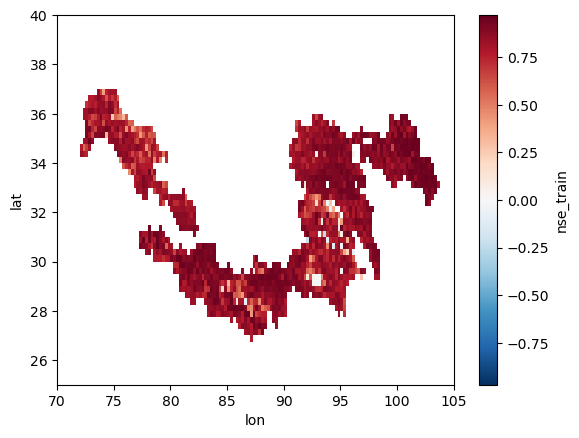

In [496]:
nse_train_et.plot()

In [470]:
u = 2.5*df_data.describe()['nse_all']['75%'] -df_data.describe()['nse_all']['25%']
d = 2.5*df_data.describe()['nse_all']['25%'] -1.5*df_data.describe()['nse_all']['75%']

NameError: name 'df_data' is not defined

In [280]:
np.sum(nse_all>u)
np.sum(nse_all<d)

<xarray.DataArray 'nse_all' ()>
array(0)

<xarray.DataArray 'nse_all' ()>
array(106)

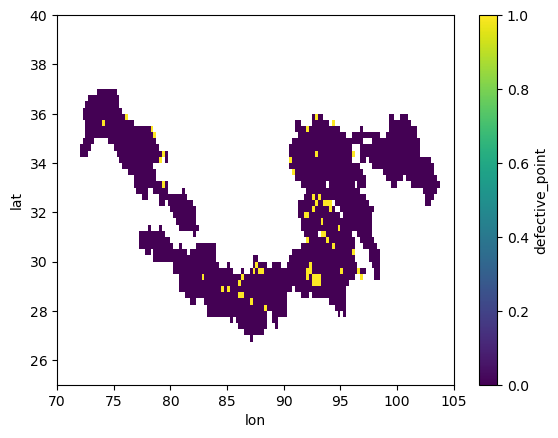

In [519]:
defective_point.plot()

# defective run

In [520]:
import copy
defective_id_raw = copy.deepcopy(defective_id)

In [521]:
# defective_id_raw = copy.deepcopy(defective_get)

## ModelSet_de

In [522]:
class ModelSet_de:



    start_feature = 1         
    end_feature = 2
    start_label = 3
    end_label = 5
    delay_day = 0            

    start_train_and_valid_date_relative = 0
    end_train_and_valid_date_relative = 144     
    
    start_test_date_relative = 0
    end_test_date_relative = 1212


    input_size = end_feature-start_feature
    output_size = end_label-start_label


    hidden_size = 50
    lstm_layers = 2
    dropout_rate = 0.4
    time_step = 50

    do_train = True    
    do_test = True       

    shuffle_train_data = False
    use_cuda = True

    train_data_rate = 0.7
    valid_data_rate = 1-train_data_rate

    batch_size = 24
    learning_rate = 0.001
    epoch = 256
    patience = 5               
    random_seed = 666           


    model_save_path = '/group1/longjs/7-river-data/model_save/'
 
    do_train_visualized = False
    do_pred_save_to_file = False

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

## single_main_de

In [523]:
def nse_value(s, o):
    nse = he.evaluator(he.nse, s, o)
    return nse

def predict_de(config, tair , prec , mass , runoff , et):
    np.random.seed(config.random_seed) 
    data_gainer = Data(config, tair , prec , mass , runoff , et)
  
    test_X = data_gainer.get_test_data()
    pred_result = predict(config, test_X)     
    predict_finall_runoff,predict_finall_et = rescale_and_evaluate(config, data_gainer, pred_result)
        
    nse_all_finall_runoff = nse_value(predict_finall_runoff[0:192],data_gainer.runoff[12:204])
    nse_train_finall_runoff = nse_value(predict_finall_runoff[0:132],data_gainer.runoff[12:144])
    nse_test_finall_runoff = nse_value(predict_finall_runoff[132:192],data_gainer.runoff[144:204])
    
    nse_all_finall_et = nse_value(predict_finall_et[0:192],data_gainer.et[12:204])
    nse_train_finall_et = nse_value(predict_finall_et[0:132],data_gainer.et[12:144])
    nse_test_finall_et = nse_value(predict_finall_et[132:192],data_gainer.et[144:204])

    print('Runoff: temp nse_all = {:.3f} , curren nse_all = {:.3f}, nse_train = {:.3f}, nse_test = {:.3f}'
          .format(nse_all_finall_runoff[0] , nse_all_finall_runoff[0] , nse_train_finall_runoff[0] , nse_test_finall_runoff[0]))    
    print('    ET: temp nse_all = {:.3f} , curren nse_all = {:.3f}, nse_train = {:.3f}, nse_test = {:.3f}'
          .format(nse_all_finall_et[0] , nse_all_finall_et[0] , nse_train_finall_et[0] , nse_test_finall_et[0]))    
    print(' ')
    
    defective_point = 0
         
    return predict_finall_runoff,predict_finall_et,nse_all_finall_runoff,nse_train_finall_runoff,nse_test_finall_runoff,nse_all_finall_et,nse_train_finall_et,nse_test_finall_et,defective_point

## single_func_de

In [524]:
import copy

In [525]:
defective_id_run = copy.deepcopy(defective_id_raw)

In [526]:
defective_id = []

In [325]:
# Use in cycles, do not run repeatedly
defective_id_run = copy.deepcopy(defective_id)
defective_id = []

In [527]:
len(defective_id_run)

58

In [528]:
predict_var_et_de = []
predict_var_runoff_de = []

import copy
def single_func_de(tair , prec , mass , runoff , et):
    get_model_id()  
    global model_id
    global predict_var_et_de
    global predict_var_runoff_de
    global defective_id_run

    
    if model_id in defective_id_run:
        predict_finall_runoff,predict_finall_et,nse_all_runoff,nse_train_runoff,nse_test_runoff,nse_all_et,nse_train_et,nse_test_et,defective_point = main(ModelSet_de(), tair , prec , mass , runoff , et)  
        print('Run model_{}, et nse = {:.3f} , runoff nse = {:.3f}'.format(model_id,nse_all_et[0],nse_all_runoff[0]))
        print(' ')
        print('{:=^100s}'.format('Run'))
        print(' ')
    else:
        if np.isnan(runoff[0]):
            predict_finall_et = np.full(1200,np.nan)
            predict_finall_runoff = np.full(1200,np.nan)

            nse_all_et = np.nan
            nse_train_et = np.nan
            nse_test_et = np.nan

            nse_all_runoff = np.nan
            nse_train_runoff = np.nan
            nse_test_runoff = np.nan

            defective_point = np.nan
        else: 
            predict_finall_runoff,predict_finall_et,nse_all_runoff,nse_train_runoff,nse_test_runoff,nse_all_et,nse_train_et,nse_test_et,defective_point = predict_de(ModelSet(), tair , prec , mass , runoff , et)  
            print('Predict model_{}, et nse = {:.3f} , runoff nse = {:.3f}'.format(model_id,nse_all_et[0],nse_all_runoff[0]))
            print(' ')
            print('{:=^100s}'.format('Predict'))
            print(' ')
    
    predict_var_et_de = np.append(predict_var_et_de,predict_finall_et)
    predict_var_runoff_de = np.append(predict_var_runoff_de,predict_finall_runoff)
    
    return nse_all_runoff,nse_train_runoff,nse_test_runoff,nse_all_et,nse_train_et,nse_test_et,defective_point

## apply_ufunc_de

In [529]:
def grid_func_de():
    

    data_path = '/group1/longjs/7-river-data/'
    tair = xr.open_dataset(data_path+'tair/'+'UKESM1_0_LL_SSP245_tas_1985_2100.nc').sel(time=slice('2000-01-01','2100-12-31'))
    prec = xr.open_dataset(data_path+'prcp/'+'UKESM1_0_LL_SSP245_tp_1985_2100.nc').sel(time=slice('2000-01-01','2100-12-31'))
    mass = xr.open_dataset(data_path+'mass/'+'massbaltot_RCP45_2000_2100.nc').sel(time=slice('2000-01-01','2100-12-31'))
    runoff = xr.open_dataset(data_path+'ET-Runoff/'+'runoff_full_time_v3.nc').sel(time=slice('2000-01-01','2100-12-31'))
    et = xr.open_dataset(data_path+'ET-Runoff/'+'evaporation_full_time_v3.nc').sel(time=slice('2000-01-01','2100-12-31'))
    

    nse_all_runoff,nse_train_runoff,nse_test_runoff,nse_all_et,nse_train_et,nse_test_et,defective_point = xr.apply_ufunc(single_func_de,
                          tair['tair'],prec['prcp'],mass['massbaltot'],runoff['runoff'],et['evaporation'],
                          input_core_dims=[['time'],['time'],['time'],['time'],['time']],
                          output_core_dims=[[],[],[],[],[],[],[]],
                          vectorize=True)
    

    nse_all_runoff.name = 'nse_all'
    nse_train_runoff.name = 'nse_train'
    nse_test_runoff.name = 'nse_test'
    
    nse_all_et.name = 'nse_all'
    nse_train_et.name = 'nse_train'
    nse_test_et.name = 'nse_test'
    
    defective_point.name = 'defective_point'
    
    nse_all_runoff.to_netcdf(data_path+'result/'+'ukesm1_245_nse_all_runoff_de.nc')
    nse_train_runoff.to_netcdf(data_path+'result/'+'ukesm1_245_nse_train_runoff_de.nc')
    nse_test_runoff.to_netcdf(data_path+'result/'+'ukesm1_245_nse_test_runoff_de.nc')
       
    nse_all_et.to_netcdf(data_path+'result/'+'ukesm1_245_nse_all_et_de.nc')
    nse_train_et.to_netcdf(data_path+'result/'+'ukesm1_245_nse_train_et_de.nc')
    nse_test_et.to_netcdf(data_path+'result/'+'ukesm1_245_nse_test_et_de.nc')

    
    defective_point.to_netcdf(data_path+'result/'+'ukesm1_245_defective_point_et_de.nc')

    global predict_var_runoff
    global predict_var_et

    pred_runoff = xr.Dataset({'runoff':(['time','lat','lon'],predict_var_runoff.reshape((60,140,1200)).transpose(2,0,1))},
                      coords={'lon':np.arange(70.125,105,0.25),
                              'lat':np.arange(25.125,40,0.25),
                              'time':pd.date_range('20010101','21001231',freq='M')})
    pred_et = xr.Dataset({'evaporation':(['time','lat','lon'],predict_var_et.reshape((60,140,1200)).transpose(2,0,1))},
                      coords={'lon':np.arange(70.125,105,0.25),
                              'lat':np.arange(25.125,40,0.25),
                              'time':pd.date_range('20010101','21001231',freq='M')})
    
    pred_runoff.to_netcdf(data_path+'result/'+'ukesm1_245_predict_runoff_de.nc')
    pred_et.to_netcdf(data_path+'result/'+'ukesm1_245_predict_et_de.nc')
 
    return pred_runoff,pred_et,nse_all_runoff,nse_train_runoff,nse_test_runoff,nse_all_et,nse_train_et,nse_test_et,defective_point

## model_id

In [530]:
model_id = 0
def get_model_id():
    global model_id
    model_id += 1
    return model_id

## all_main

In [531]:
pred_runoff,pred_et,nse_all_runoff,nse_train_runoff,nse_test_runoff,nse_all_et,nse_train_et,nse_test_et,defective_point = grid_func_de()

Runoff: temp nse_all = 0.450 , curren nse_all = 0.450, nse_train = 0.473, nse_test = 0.231
    ET: temp nse_all = 0.769 , curren nse_all = 0.769, nse_train = 0.754, nse_test = 0.801
 
Predict model_1049, et nse = 0.769 , runoff nse = 0.450
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.170 , curren nse_all = 0.170, nse_train = 0.784, nse_test = -4.794
    ET: temp nse_all = 0.828 , curren nse_all = 0.828, nse_train = 0.834, nse_test = 0.811
 
Predict model_1187, et nse = 0.828 , runoff nse = 0.170
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.672 , curren nse_all = 0.672, nse_train = 0.820, nse_test = 0.211
    ET: temp nse_all = 0.848 , curren nse_all = 0.848, nse_train = 0.840, nse_test = 0.867
 
Predict model_1188, et nse = 0.848 , runoff nse = 0.672
 
==============================================Predict==============

Runoff: temp nse_all = 0.859 , curren nse_all = 0.859, nse_train = 0.854, nse_test = 0.871
    ET: temp nse_all = 0.790 , curren nse_all = 0.790, nse_train = 0.804, nse_test = 0.755
 
Predict model_1468, et nse = 0.790 , runoff nse = 0.859
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.810 , curren nse_all = 0.810, nse_train = 0.860, nse_test = 0.672
    ET: temp nse_all = 0.922 , curren nse_all = 0.922, nse_train = 0.944, nse_test = 0.865
 
Predict model_1469, et nse = 0.922 , runoff nse = 0.810
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.846 , curren nse_all = 0.846, nse_train = 0.895, nse_test = 0.747
    ET: temp nse_all = 0.923 , curren nse_all = 0.923, nse_train = 0.935, nse_test = 0.900
 
Predict model_1470, et nse = 0.923 , runoff nse = 0.846
 
==============================================Predict===============

Predict model_1611, et nse = 0.539 , runoff nse = 0.852
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.647 , curren nse_all = 0.647, nse_train = 0.643, nse_test = 0.644
    ET: temp nse_all = 0.738 , curren nse_all = 0.738, nse_train = 0.766, nse_test = 0.680
 
Predict model_1612, et nse = 0.738 , runoff nse = 0.647
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.284 , curren nse_all = 0.284, nse_train = 0.310, nse_test = 0.183
    ET: temp nse_all = 0.674 , curren nse_all = 0.674, nse_train = 0.687, nse_test = 0.645
 
Predict model_1613, et nse = 0.674 , runoff nse = 0.284
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.783 , curren nse_all = 0.783, nse_train = 0.855, nse_test = 0.673
    ET: temp nse_all = 0.616 , curren nse_all = 0.616, nse

Runoff: temp nse_all = 0.925 , curren nse_all = 0.925, nse_train = 0.936, nse_test = 0.902
    ET: temp nse_all = 0.730 , curren nse_all = 0.730, nse_train = 0.817, nse_test = 0.550
 
Predict model_1752, et nse = 0.730 , runoff nse = 0.925
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.672 , curren nse_all = 0.672, nse_train = 0.650, nse_test = 0.698
    ET: temp nse_all = 0.388 , curren nse_all = 0.388, nse_train = 0.471, nse_test = 0.181
 
Predict model_1753, et nse = 0.388 , runoff nse = 0.672
 
==============================================Predict===============================================
 
now loop = 1 , Runoff: temp nse_all = 0.191 , curren nse_all = 0.191, nse_train = 0.127, nse_test = 0.162
                   ET: temp nse_all = 0.312 , curren nse_all = 0.312, nse_train = 0.495, nse_test = -0.164
 
now loop = 2 , Runoff: temp nse_all = 0.173 , curren nse_all = 0.191, nse_train = 0.127, nse_te

Runoff: temp nse_all = 0.479 , curren nse_all = 0.479, nse_train = 0.729, nse_test = -0.098
    ET: temp nse_all = 0.776 , curren nse_all = 0.776, nse_train = 0.820, nse_test = 0.640
 
Predict model_1868, et nse = 0.776 , runoff nse = 0.479
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.657 , curren nse_all = 0.657, nse_train = 0.852, nse_test = 0.076
    ET: temp nse_all = 0.804 , curren nse_all = 0.804, nse_train = 0.841, nse_test = 0.696
 
Predict model_1869, et nse = 0.804 , runoff nse = 0.657
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.786 , curren nse_all = 0.786, nse_train = 0.811, nse_test = 0.732
    ET: temp nse_all = 0.814 , curren nse_all = 0.814, nse_train = 0.812, nse_test = 0.819
 
Predict model_1873, et nse = 0.814 , runoff nse = 0.786
 
==============================================Predict==============

now loop = 11 , Runoff: temp nse_all = 0.096 , curren nse_all = 0.125, nse_train = 0.180, nse_test = 0.046
                   ET: temp nse_all = 0.471 , curren nse_all = 0.563, nse_train = 0.555, nse_test = 0.576
 
now loop = 12 , Runoff: temp nse_all = 0.090 , curren nse_all = 0.125, nse_train = 0.180, nse_test = 0.046
                   ET: temp nse_all = 0.563 , curren nse_all = 0.563, nse_train = 0.555, nse_test = 0.576
 
now loop = 13 , Runoff: temp nse_all = 0.110 , curren nse_all = 0.125, nse_train = 0.180, nse_test = 0.046
                   ET: temp nse_all = 0.550 , curren nse_all = 0.563, nse_train = 0.555, nse_test = 0.576
 
now loop = 14 , Runoff: temp nse_all = 0.085 , curren nse_all = 0.125, nse_train = 0.180, nse_test = 0.046
                   ET: temp nse_all = 0.545 , curren nse_all = 0.563, nse_train = 0.555, nse_test = 0.576
 
now loop = 15 , Runoff: temp nse_all = 0.125 , curren nse_all = 0.125, nse_train = 0.180, nse_test = 0.046
                   ET: temp nse_a

Runoff: temp nse_all = 0.841 , curren nse_all = 0.841, nse_train = 0.833, nse_test = 0.857
    ET: temp nse_all = 0.779 , curren nse_all = 0.779, nse_train = 0.822, nse_test = 0.670
 
Predict model_2011, et nse = 0.779 , runoff nse = 0.841
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.707 , curren nse_all = 0.707, nse_train = 0.735, nse_test = 0.626
    ET: temp nse_all = 0.691 , curren nse_all = 0.691, nse_train = 0.705, nse_test = 0.654
 
Predict model_2012, et nse = 0.691 , runoff nse = 0.707
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.309 , curren nse_all = 0.309, nse_train = 0.493, nse_test = -0.384
    ET: temp nse_all = 0.727 , curren nse_all = 0.727, nse_train = 0.711, nse_test = 0.760
 
Predict model_2013, et nse = 0.727 , runoff nse = 0.309
 
==============================================Predict==============

now loop = 3 , Runoff: temp nse_all = -0.043 , curren nse_all = -0.047, nse_train = -0.008, nse_test = -0.154
                   ET: temp nse_all = -0.001 , curren nse_all = 0.005, nse_train = 0.006, nse_test = -0.002
 
now loop = 4 , Runoff: temp nse_all = -0.023 , curren nse_all = -0.047, nse_train = -0.008, nse_test = -0.154
                   ET: temp nse_all = -0.026 , curren nse_all = 0.005, nse_train = 0.006, nse_test = -0.002
 
now loop = 5 , Runoff: temp nse_all = -0.018 , curren nse_all = -0.047, nse_train = -0.008, nse_test = -0.154
                   ET: temp nse_all = -0.036 , curren nse_all = 0.005, nse_train = 0.006, nse_test = -0.002
 
now loop = 6 , Runoff: temp nse_all = -0.049 , curren nse_all = -0.047, nse_train = -0.008, nse_test = -0.154
                   ET: temp nse_all = -0.001 , curren nse_all = 0.005, nse_train = 0.006, nse_test = -0.002
 
now loop = 7 , Runoff: temp nse_all = -0.014 , curren nse_all = -0.047, nse_train = -0.008, nse_test = -0.154
          

Runoff: temp nse_all = 0.516 , curren nse_all = 0.516, nse_train = 0.598, nse_test = 0.250
    ET: temp nse_all = 0.731 , curren nse_all = 0.731, nse_train = 0.733, nse_test = 0.725
 
Predict model_2055, et nse = 0.731 , runoff nse = 0.516
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.686 , curren nse_all = 0.686, nse_train = 0.688, nse_test = 0.681
    ET: temp nse_all = 0.808 , curren nse_all = 0.808, nse_train = 0.785, nse_test = 0.862
 
Predict model_2056, et nse = 0.808 , runoff nse = 0.686
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.721 , curren nse_all = 0.721, nse_train = 0.719, nse_test = 0.725
    ET: temp nse_all = 0.763 , curren nse_all = 0.763, nse_train = 0.776, nse_test = 0.728
 
Predict model_2057, et nse = 0.763 , runoff nse = 0.721
 
==============================================Predict===============

now loop = 3 , Runoff: temp nse_all = -0.101 , curren nse_all = -0.072, nse_train = -0.027, nse_test = -0.165
                   ET: temp nse_all = 0.002 , curren nse_all = 0.003, nse_train = -0.068, nse_test = -0.722
 
now loop = 4 , Runoff: temp nse_all = -0.044 , curren nse_all = -0.044, nse_train = -0.001, nse_test = -0.135
                   ET: temp nse_all = 0.006 , curren nse_all = 0.006, nse_train = -0.037, nse_test = -0.911
 
now loop = 5 , Runoff: temp nse_all = -0.054 , curren nse_all = -0.044, nse_train = -0.001, nse_test = -0.135
                   ET: temp nse_all = 0.005 , curren nse_all = 0.006, nse_train = -0.037, nse_test = -0.911
 
now loop = 6 , Runoff: temp nse_all = -0.013 , curren nse_all = -0.013, nse_train = 0.039, nse_test = -0.104
                   ET: temp nse_all = 0.011 , curren nse_all = 0.011, nse_train = -0.045, nse_test = -0.805
 
now loop = 7 , Runoff: temp nse_all = -0.109 , curren nse_all = -0.013, nse_train = 0.039, nse_test = -0.104
            

now loop = 17 , Runoff: temp nse_all = -0.061 , curren nse_all = -0.118, nse_train = -0.131, nse_test = -0.718
                   ET: temp nse_all = 0.411 , curren nse_all = 0.450, nse_train = 0.448, nse_test = 0.368
 
now loop = 18 , Runoff: temp nse_all = -0.077 , curren nse_all = -0.118, nse_train = -0.131, nse_test = -0.718
                   ET: temp nse_all = 0.424 , curren nse_all = 0.450, nse_train = 0.448, nse_test = 0.368
 
now loop = 19 , Runoff: temp nse_all = -0.087 , curren nse_all = -0.087, nse_train = -0.099, nse_test = -0.835
                   ET: temp nse_all = 0.450 , curren nse_all = 0.450, nse_train = 0.450, nse_test = 0.363
 
now loop = 20 , Runoff: temp nse_all = -0.125 , curren nse_all = -0.125, nse_train = -0.132, nse_test = -1.815
                   ET: temp nse_all = 0.456 , curren nse_all = 0.456, nse_train = 0.458, nse_test = 0.357
 
now loop = 21 , Runoff: temp nse_all = -0.106 , curren nse_all = -0.125, nse_train = -0.132, nse_test = -1.815
             

Predict model_2171, et nse = 0.937 , runoff nse = 0.679
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.535 , curren nse_all = 0.535, nse_train = 0.679, nse_test = -0.497
    ET: temp nse_all = 0.856 , curren nse_all = 0.856, nse_train = 0.861, nse_test = 0.847
 
Predict model_2172, et nse = 0.856 , runoff nse = 0.535
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.480 , curren nse_all = 0.480, nse_train = 0.628, nse_test = -0.395
    ET: temp nse_all = 0.902 , curren nse_all = 0.902, nse_train = 0.915, nse_test = 0.872
 
Predict model_2173, et nse = 0.902 , runoff nse = 0.480
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.544 , curren nse_all = 0.544, nse_train = 0.587, nse_test = 0.348
    ET: temp nse_all = 0.810 , curren nse_all = 0.810, n

Runoff: temp nse_all = 0.617 , curren nse_all = 0.617, nse_train = 0.632, nse_test = 0.587
    ET: temp nse_all = 0.825 , curren nse_all = 0.825, nse_train = 0.833, nse_test = 0.811
 
Predict model_2198, et nse = 0.825 , runoff nse = 0.617
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.739 , curren nse_all = 0.739, nse_train = 0.746, nse_test = 0.726
    ET: temp nse_all = 0.765 , curren nse_all = 0.765, nse_train = 0.764, nse_test = 0.767
 
Predict model_2199, et nse = 0.765 , runoff nse = 0.739
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.685 , curren nse_all = 0.685, nse_train = 0.651, nse_test = 0.741
    ET: temp nse_all = 0.830 , curren nse_all = 0.830, nse_train = 0.820, nse_test = 0.855
 
Predict model_2200, et nse = 0.830 , runoff nse = 0.685
 
==============================================Predict===============

now loop = 1 , Runoff: temp nse_all = 0.320 , curren nse_all = 0.320, nse_train = 0.495, nse_test = 0.249
                   ET: temp nse_all = 0.374 , curren nse_all = 0.374, nse_train = 0.592, nse_test = 0.234
 
now loop = 2 , Runoff: temp nse_all = 0.351 , curren nse_all = 0.320, nse_train = 0.495, nse_test = 0.249
                   ET: temp nse_all = 0.351 , curren nse_all = 0.374, nse_train = 0.592, nse_test = 0.234
 
now loop = 3 , Runoff: temp nse_all = 0.366 , curren nse_all = 0.320, nse_train = 0.495, nse_test = 0.249
                   ET: temp nse_all = 0.364 , curren nse_all = 0.374, nse_train = 0.592, nse_test = 0.234
 
now loop = 4 , Runoff: temp nse_all = 0.337 , curren nse_all = 0.320, nse_train = 0.495, nse_test = 0.249
                   ET: temp nse_all = 0.360 , curren nse_all = 0.374, nse_train = 0.592, nse_test = 0.234
 
now loop = 5 , Runoff: temp nse_all = 0.311 , curren nse_all = 0.320, nse_train = 0.495, nse_test = 0.249
                   ET: temp nse_all = 

Runoff: temp nse_all = 0.664 , curren nse_all = 0.664, nse_train = 0.778, nse_test = 0.421
    ET: temp nse_all = 0.898 , curren nse_all = 0.898, nse_train = 0.908, nse_test = 0.878
 
Predict model_2325, et nse = 0.898 , runoff nse = 0.664
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.800 , curren nse_all = 0.800, nse_train = 0.875, nse_test = 0.633
    ET: temp nse_all = 0.849 , curren nse_all = 0.849, nse_train = 0.889, nse_test = 0.783
 
Predict model_2326, et nse = 0.849 , runoff nse = 0.800
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.618 , curren nse_all = 0.618, nse_train = 0.593, nse_test = 0.656
    ET: temp nse_all = 0.781 , curren nse_all = 0.781, nse_train = 0.800, nse_test = 0.735
 
Predict model_2327, et nse = 0.781 , runoff nse = 0.618
 
==============================================Predict===============

now loop = 7 , Runoff: temp nse_all = 0.003 , curren nse_all = -0.033, nse_train = -0.013, nse_test = -0.112
                   ET: temp nse_all = -0.061 , curren nse_all = -0.028, nse_train = 0.004, nse_test = -0.222
 
now loop = 8 , Runoff: temp nse_all = -0.031 , curren nse_all = -0.031, nse_train = -0.012, nse_test = -0.106
                   ET: temp nse_all = -0.026 , curren nse_all = -0.026, nse_train = 0.000, nse_test = -0.212
 
now loop = 9 , Runoff: temp nse_all = -0.005 , curren nse_all = -0.031, nse_train = -0.012, nse_test = -0.106
                   ET: temp nse_all = -0.051 , curren nse_all = -0.026, nse_train = 0.000, nse_test = -0.212
 
now loop = 10 , Runoff: temp nse_all = -0.011 , curren nse_all = -0.011, nse_train = 0.002, nse_test = -0.071
                   ET: temp nse_all = -0.009 , curren nse_all = -0.009, nse_train = 0.008, nse_test = -0.182
 
now loop = 11 , Runoff: temp nse_all = -0.030 , curren nse_all = -0.011, nse_train = 0.002, nse_test = -0.071
       

Runoff: temp nse_all = 0.749 , curren nse_all = 0.749, nse_train = 0.784, nse_test = 0.657
    ET: temp nse_all = 0.780 , curren nse_all = 0.780, nse_train = 0.794, nse_test = 0.750
 
Predict model_2429, et nse = 0.780 , runoff nse = 0.749
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.803 , curren nse_all = 0.803, nse_train = 0.877, nse_test = 0.656
    ET: temp nse_all = 0.850 , curren nse_all = 0.850, nse_train = 0.863, nse_test = 0.822
 
Predict model_2430, et nse = 0.850 , runoff nse = 0.803
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.512 , curren nse_all = 0.512, nse_train = 0.652, nse_test = 0.200
    ET: temp nse_all = 0.765 , curren nse_all = 0.765, nse_train = 0.907, nse_test = 0.453
 
Predict model_2431, et nse = 0.765 , runoff nse = 0.512
 
==============================================Predict===============

now loop = 7 , Runoff: temp nse_all = -0.051 , curren nse_all = -0.067, nse_train = -0.106, nse_test = -0.208
                   ET: temp nse_all = 0.484 , curren nse_all = 0.530, nse_train = 0.619, nse_test = 0.411
 
now loop = 8 , Runoff: temp nse_all = -0.038 , curren nse_all = -0.067, nse_train = -0.106, nse_test = -0.208
                   ET: temp nse_all = 0.006 , curren nse_all = 0.530, nse_train = 0.619, nse_test = 0.411
 
now loop = 9 , Runoff: temp nse_all = -0.041 , curren nse_all = -0.067, nse_train = -0.106, nse_test = -0.208
                   ET: temp nse_all = 0.474 , curren nse_all = 0.530, nse_train = 0.619, nse_test = 0.411
 
now loop = 10 , Runoff: temp nse_all = -0.044 , curren nse_all = -0.067, nse_train = -0.106, nse_test = -0.208
                   ET: temp nse_all = 0.490 , curren nse_all = 0.530, nse_train = 0.619, nse_test = 0.411
 
Run model_2446, et nse = 0.530 , runoff nse = -0.067
 
================================================Run=====================

now loop = 1 , Runoff: temp nse_all = -0.003 , curren nse_all = -0.003, nse_train = 0.003, nse_test = -0.072
                   ET: temp nse_all = -0.169 , curren nse_all = -0.169, nse_train = -0.070, nse_test = -0.501
 
now loop = 2 , Runoff: temp nse_all = -0.035 , curren nse_all = -0.003, nse_train = 0.003, nse_test = -0.072
                   ET: temp nse_all = -0.178 , curren nse_all = -0.169, nse_train = -0.070, nse_test = -0.501
 
now loop = 3 , Runoff: temp nse_all = -0.054 , curren nse_all = -0.054, nse_train = -0.028, nse_test = -0.142
                   ET: temp nse_all = -0.099 , curren nse_all = -0.099, nse_train = -0.022, nse_test = -0.396
 
now loop = 4 , Runoff: temp nse_all = -0.031 , curren nse_all = -0.054, nse_train = -0.028, nse_test = -0.142
                   ET: temp nse_all = -0.111 , curren nse_all = -0.099, nse_train = -0.022, nse_test = -0.396
 
now loop = 5 , Runoff: temp nse_all = -0.046 , curren nse_all = -0.054, nse_train = -0.028, nse_test = -0.142
    

now loop = 16 , Runoff: temp nse_all = 0.003 , curren nse_all = -0.006, nse_train = 0.002, nse_test = -0.041
                   ET: temp nse_all = -0.024 , curren nse_all = -0.014, nse_train = 0.009, nse_test = -0.203
 
now loop = 17 , Runoff: temp nse_all = -0.005 , curren nse_all = -0.006, nse_train = 0.002, nse_test = -0.041
                   ET: temp nse_all = -0.046 , curren nse_all = -0.014, nse_train = 0.009, nse_test = -0.203
 
now loop = 18 , Runoff: temp nse_all = 0.001 , curren nse_all = -0.006, nse_train = 0.002, nse_test = -0.041
                   ET: temp nse_all = -0.063 , curren nse_all = -0.014, nse_train = 0.009, nse_test = -0.203
 
now loop = 19 , Runoff: temp nse_all = 0.023 , curren nse_all = -0.006, nse_train = 0.002, nse_test = -0.041
                   ET: temp nse_all = -0.045 , curren nse_all = -0.014, nse_train = 0.009, nse_test = -0.203
 
now loop = 20 , Runoff: temp nse_all = -0.016 , curren nse_all = -0.006, nse_train = 0.002, nse_test = -0.041
         

now loop = 10 , Runoff: temp nse_all = 0.002 , curren nse_all = -0.000, nse_train = 0.004, nse_test = -0.017
                   ET: temp nse_all = -0.080 , curren nse_all = -0.018, nse_train = 0.006, nse_test = -0.112
 
now loop = 11 , Runoff: temp nse_all = 0.008 , curren nse_all = -0.000, nse_train = 0.004, nse_test = -0.017
                   ET: temp nse_all = -0.056 , curren nse_all = -0.018, nse_train = 0.006, nse_test = -0.112
 
now loop = 12 , Runoff: temp nse_all = 0.014 , curren nse_all = -0.000, nse_train = 0.004, nse_test = -0.017
                   ET: temp nse_all = -0.079 , curren nse_all = -0.018, nse_train = 0.006, nse_test = -0.112
 
now loop = 13 , Runoff: temp nse_all = 0.021 , curren nse_all = -0.000, nse_train = 0.004, nse_test = -0.017
                   ET: temp nse_all = -0.101 , curren nse_all = -0.018, nse_train = 0.006, nse_test = -0.112
 
Run model_2473, et nse = -0.018 , runoff nse = -0.000
 
================================================Run=============

Runoff: temp nse_all = 0.808 , curren nse_all = 0.808, nse_train = 0.769, nse_test = 0.909
    ET: temp nse_all = 0.827 , curren nse_all = 0.827, nse_train = 0.858, nse_test = 0.753
 
Predict model_2562, et nse = 0.827 , runoff nse = 0.808
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.553 , curren nse_all = 0.553, nse_train = 0.546, nse_test = 0.568
    ET: temp nse_all = 0.762 , curren nse_all = 0.762, nse_train = 0.795, nse_test = 0.680
 
Predict model_2563, et nse = 0.762 , runoff nse = 0.553
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.839 , curren nse_all = 0.839, nse_train = 0.863, nse_test = 0.763
    ET: temp nse_all = 0.828 , curren nse_all = 0.828, nse_train = 0.852, nse_test = 0.776
 
Predict model_2564, et nse = 0.828 , runoff nse = 0.839
 
==============================================Predict===============

now loop = 3 , Runoff: temp nse_all = -0.088 , curren nse_all = -0.088, nse_train = -0.044, nse_test = -0.292
                   ET: temp nse_all = -0.139 , curren nse_all = -0.139, nse_train = 0.085, nse_test = -0.570
 
now loop = 4 , Runoff: temp nse_all = -0.081 , curren nse_all = -0.088, nse_train = -0.044, nse_test = -0.292
                   ET: temp nse_all = -0.164 , curren nse_all = -0.139, nse_train = 0.085, nse_test = -0.570
 
now loop = 5 , Runoff: temp nse_all = -0.091 , curren nse_all = -0.088, nse_train = -0.044, nse_test = -0.292
                   ET: temp nse_all = -0.157 , curren nse_all = -0.139, nse_train = 0.085, nse_test = -0.570
 
now loop = 6 , Runoff: temp nse_all = -0.089 , curren nse_all = -0.088, nse_train = -0.044, nse_test = -0.292
                   ET: temp nse_all = -0.143 , curren nse_all = -0.139, nse_train = 0.085, nse_test = -0.570
 
now loop = 7 , Runoff: temp nse_all = -0.055 , curren nse_all = -0.088, nse_train = -0.044, nse_test = -0.292
      

now loop = 26 , Runoff: temp nse_all = -0.074 , curren nse_all = -0.141, nse_train = -0.117, nse_test = -0.298
                   ET: temp nse_all = 0.332 , curren nse_all = 0.335, nse_train = 0.526, nse_test = 0.120
 
now loop = 27 , Runoff: temp nse_all = -0.085 , curren nse_all = -0.141, nse_train = -0.117, nse_test = -0.298
                   ET: temp nse_all = 0.315 , curren nse_all = 0.335, nse_train = 0.526, nse_test = 0.120
 
now loop = 28 , Runoff: temp nse_all = -0.019 , curren nse_all = -0.141, nse_train = -0.117, nse_test = -0.298
                   ET: temp nse_all = -0.077 , curren nse_all = 0.335, nse_train = 0.526, nse_test = 0.120
 
now loop = 29 , Runoff: temp nse_all = -0.066 , curren nse_all = -0.141, nse_train = -0.117, nse_test = -0.298
                   ET: temp nse_all = 0.299 , curren nse_all = 0.335, nse_train = 0.526, nse_test = 0.120
 
now loop = 30 , Runoff: temp nse_all = -0.132 , curren nse_all = -0.141, nse_train = -0.117, nse_test = -0.298
            

Runoff: temp nse_all = 0.666 , curren nse_all = 0.666, nse_train = 0.780, nse_test = 0.439
    ET: temp nse_all = 0.879 , curren nse_all = 0.879, nse_train = 0.896, nse_test = 0.843
 
Predict model_2605, et nse = 0.879 , runoff nse = 0.666
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.603 , curren nse_all = 0.603, nse_train = 0.623, nse_test = 0.557
    ET: temp nse_all = 0.786 , curren nse_all = 0.786, nse_train = 0.791, nse_test = 0.772
 
Predict model_2606, et nse = 0.786 , runoff nse = 0.603
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.651 , curren nse_all = 0.651, nse_train = 0.688, nse_test = 0.566
    ET: temp nse_all = 0.831 , curren nse_all = 0.831, nse_train = 0.841, nse_test = 0.807
 
Predict model_2607, et nse = 0.831 , runoff nse = 0.651
 
==============================================Predict===============

now loop = 6 , Runoff: temp nse_all = 0.235 , curren nse_all = 0.249, nse_train = 0.340, nse_test = -0.448
                   ET: temp nse_all = 0.419 , curren nse_all = 0.442, nse_train = 0.463, nse_test = 0.390
 
now loop = 7 , Runoff: temp nse_all = 0.223 , curren nse_all = 0.249, nse_train = 0.340, nse_test = -0.448
                   ET: temp nse_all = 0.434 , curren nse_all = 0.442, nse_train = 0.463, nse_test = 0.390
 
now loop = 8 , Runoff: temp nse_all = 0.247 , curren nse_all = 0.249, nse_train = 0.340, nse_test = -0.448
                   ET: temp nse_all = 0.439 , curren nse_all = 0.442, nse_train = 0.463, nse_test = 0.390
 
now loop = 9 , Runoff: temp nse_all = 0.224 , curren nse_all = 0.249, nse_train = 0.340, nse_test = -0.448
                   ET: temp nse_all = 0.428 , curren nse_all = 0.442, nse_train = 0.463, nse_test = 0.390
 
now loop = 10 , Runoff: temp nse_all = 0.217 , curren nse_all = 0.249, nse_train = 0.340, nse_test = -0.448
                   ET: temp nse_

Runoff: temp nse_all = 0.654 , curren nse_all = 0.654, nse_train = 0.749, nse_test = 0.553
    ET: temp nse_all = 0.859 , curren nse_all = 0.859, nse_train = 0.896, nse_test = 0.773
 
Predict model_2622, et nse = 0.859 , runoff nse = 0.654
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.594 , curren nse_all = 0.594, nse_train = 0.607, nse_test = 0.569
    ET: temp nse_all = 0.787 , curren nse_all = 0.787, nse_train = 0.808, nse_test = 0.745
 
Predict model_2623, et nse = 0.787 , runoff nse = 0.594
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.900 , curren nse_all = 0.900, nse_train = 0.939, nse_test = 0.839
    ET: temp nse_all = 0.605 , curren nse_all = 0.605, nse_train = 0.710, nse_test = 0.436
 
Predict model_2624, et nse = 0.605 , runoff nse = 0.900
 
==============================================Predict===============

Runoff: temp nse_all = 0.326 , curren nse_all = 0.326, nse_train = 0.494, nse_test = 0.212
    ET: temp nse_all = 0.802 , curren nse_all = 0.802, nse_train = 0.917, nse_test = 0.387
 
Predict model_2712, et nse = 0.802 , runoff nse = 0.326
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.444 , curren nse_all = 0.444, nse_train = 0.616, nse_test = 0.274
    ET: temp nse_all = 0.775 , curren nse_all = 0.775, nse_train = 0.906, nse_test = 0.207
 
Predict model_2713, et nse = 0.775 , runoff nse = 0.444
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.269 , curren nse_all = 0.269, nse_train = 0.470, nse_test = 0.158
    ET: temp nse_all = 0.764 , curren nse_all = 0.764, nse_train = 0.835, nse_test = 0.486
 
Predict model_2714, et nse = 0.764 , runoff nse = 0.269
 
==============================================Predict===============

Runoff: temp nse_all = 0.544 , curren nse_all = 0.544, nse_train = 0.714, nse_test = 0.209
    ET: temp nse_all = 0.908 , curren nse_all = 0.908, nse_train = 0.928, nse_test = 0.861
 
Predict model_2748, et nse = 0.908 , runoff nse = 0.544
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.440 , curren nse_all = 0.440, nse_train = 0.487, nse_test = 0.317
    ET: temp nse_all = 0.669 , curren nse_all = 0.669, nse_train = 0.681, nse_test = 0.644
 
Predict model_2749, et nse = 0.669 , runoff nse = 0.440
 
==============================================Predict===============================================
 
now loop = 1 , Runoff: temp nse_all = 0.269 , curren nse_all = 0.269, nse_train = 0.333, nse_test = -0.101
                   ET: temp nse_all = 0.231 , curren nse_all = 0.231, nse_train = 0.299, nse_test = 0.067
 
now loop = 2 , Runoff: temp nse_all = 0.255 , curren nse_all = 0.269, nse_train = 0.333, nse_te

Runoff: temp nse_all = 0.587 , curren nse_all = 0.587, nse_train = 0.613, nse_test = 0.532
    ET: temp nse_all = 0.656 , curren nse_all = 0.656, nse_train = 0.639, nse_test = 0.701
 
Predict model_2766, et nse = 0.656 , runoff nse = 0.587
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.448 , curren nse_all = 0.448, nse_train = 0.420, nse_test = 0.476
    ET: temp nse_all = 0.850 , curren nse_all = 0.850, nse_train = 0.884, nse_test = 0.736
 
Predict model_2772, et nse = 0.850 , runoff nse = 0.448
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.274 , curren nse_all = 0.274, nse_train = 0.299, nse_test = 0.185
    ET: temp nse_all = 0.777 , curren nse_all = 0.777, nse_train = 0.769, nse_test = 0.791
 
Predict model_2773, et nse = 0.777 , runoff nse = 0.274
 
==============================================Predict===============

Runoff: temp nse_all = 0.121 , curren nse_all = 0.121, nse_train = 0.240, nse_test = 0.032
    ET: temp nse_all = 0.878 , curren nse_all = 0.878, nse_train = 0.908, nse_test = 0.796
 
Predict model_2855, et nse = 0.878 , runoff nse = 0.121
 
==============================================Predict===============================================
 
Runoff: temp nse_all = -0.023 , curren nse_all = -0.023, nse_train = 0.467, nse_test = -0.186
    ET: temp nse_all = 0.906 , curren nse_all = 0.906, nse_train = 0.932, nse_test = 0.839
 
Predict model_2856, et nse = 0.906 , runoff nse = -0.023
 
==============================================Predict===============================================
 
Runoff: temp nse_all = -0.033 , curren nse_all = -0.033, nse_train = -0.083, nse_test = -0.143
    ET: temp nse_all = 0.679 , curren nse_all = 0.679, nse_train = 0.805, nse_test = 0.539
 
Predict model_2870, et nse = 0.679 , runoff nse = -0.033
 
==============================================Predict======

Runoff: temp nse_all = 0.840 , curren nse_all = 0.840, nse_train = 0.865, nse_test = 0.796
    ET: temp nse_all = 0.829 , curren nse_all = 0.829, nse_train = 0.829, nse_test = 0.829
 
Predict model_2903, et nse = 0.829 , runoff nse = 0.840
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.878 , curren nse_all = 0.878, nse_train = 0.875, nse_test = 0.880
    ET: temp nse_all = 0.785 , curren nse_all = 0.785, nse_train = 0.793, nse_test = 0.769
 
Predict model_2904, et nse = 0.785 , runoff nse = 0.878
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.778 , curren nse_all = 0.778, nse_train = 0.779, nse_test = 0.776
    ET: temp nse_all = 0.622 , curren nse_all = 0.622, nse_train = 0.597, nse_test = 0.673
 
Predict model_2905, et nse = 0.622 , runoff nse = 0.778
 
==============================================Predict===============

Runoff: temp nse_all = -0.008 , curren nse_all = -0.008, nse_train = 0.495, nse_test = -0.186
    ET: temp nse_all = 0.864 , curren nse_all = 0.864, nse_train = 0.899, nse_test = 0.734
 
Predict model_2993, et nse = 0.864 , runoff nse = -0.008
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.008 , curren nse_all = 0.008, nse_train = 0.116, nse_test = -0.117
    ET: temp nse_all = 0.884 , curren nse_all = 0.884, nse_train = 0.924, nse_test = 0.781
 
Predict model_2994, et nse = 0.884 , runoff nse = 0.008
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.145 , curren nse_all = 0.145, nse_train = 0.288, nse_test = 0.010
    ET: temp nse_all = 0.890 , curren nse_all = 0.890, nse_train = 0.903, nse_test = 0.856
 
Predict model_2995, et nse = 0.890 , runoff nse = 0.145
 
==============================================Predict==========

Runoff: temp nse_all = 0.873 , curren nse_all = 0.873, nse_train = 0.895, nse_test = 0.836
    ET: temp nse_all = 0.729 , curren nse_all = 0.729, nse_train = 0.777, nse_test = 0.585
 
Predict model_3044, et nse = 0.729 , runoff nse = 0.873
 
==============================================Predict===============================================
 
now loop = 1 , Runoff: temp nse_all = 0.327 , curren nse_all = 0.327, nse_train = 0.514, nse_test = 0.054
                   ET: temp nse_all = -0.175 , curren nse_all = -0.175, nse_train = -0.114, nse_test = -0.327
 
now loop = 2 , Runoff: temp nse_all = 0.283 , curren nse_all = 0.327, nse_train = 0.514, nse_test = 0.054
                   ET: temp nse_all = -0.178 , curren nse_all = -0.175, nse_train = -0.114, nse_test = -0.327
 
now loop = 3 , Runoff: temp nse_all = 0.315 , curren nse_all = 0.327, nse_train = 0.514, nse_test = 0.054
                   ET: temp nse_all = -0.177 , curren nse_all = -0.175, nse_train = -0.114, nse_test = -0.327
 
n

Runoff: temp nse_all = 0.675 , curren nse_all = 0.675, nse_train = 0.655, nse_test = 0.714
    ET: temp nse_all = 0.817 , curren nse_all = 0.817, nse_train = 0.807, nse_test = 0.841
 
Predict model_3120, et nse = 0.817 , runoff nse = 0.675
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.356 , curren nse_all = 0.356, nse_train = 0.367, nse_test = 0.182
    ET: temp nse_all = 0.812 , curren nse_all = 0.812, nse_train = 0.818, nse_test = 0.800
 
Predict model_3121, et nse = 0.812 , runoff nse = 0.356
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.129 , curren nse_all = 0.129, nse_train = 0.143, nse_test = -0.552
    ET: temp nse_all = 0.847 , curren nse_all = 0.847, nse_train = 0.868, nse_test = 0.803
 
Predict model_3124, et nse = 0.847 , runoff nse = 0.129
 
==============================================Predict==============

now loop = 7 , Runoff: temp nse_all = -0.334 , curren nse_all = -0.334, nse_train = -0.131, nse_test = -659.601
                   ET: temp nse_all = -0.013 , curren nse_all = -0.013, nse_train = -0.073, nse_test = -0.003
 
now loop = 8 , Runoff: temp nse_all = -0.846 , curren nse_all = -0.334, nse_train = -0.131, nse_test = -659.601
                   ET: temp nse_all = -0.163 , curren nse_all = -0.013, nse_train = -0.073, nse_test = -0.003
 
now loop = 9 , Runoff: temp nse_all = -1.010 , curren nse_all = -0.334, nse_train = -0.131, nse_test = -659.601
                   ET: temp nse_all = -0.112 , curren nse_all = -0.013, nse_train = -0.073, nse_test = -0.003
 
now loop = 10 , Runoff: temp nse_all = -1.009 , curren nse_all = -0.334, nse_train = -0.131, nse_test = -659.601
                   ET: temp nse_all = -0.091 , curren nse_all = -0.013, nse_train = -0.073, nse_test = -0.003
 
now loop = 11 , Runoff: temp nse_all = -0.886 , curren nse_all = -0.334, nse_train = -0.131, nse_test =

Runoff: temp nse_all = 0.640 , curren nse_all = 0.640, nse_train = 0.754, nse_test = 0.457
    ET: temp nse_all = 0.779 , curren nse_all = 0.779, nse_train = 0.799, nse_test = 0.743
 
Predict model_3255, et nse = 0.779 , runoff nse = 0.640
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.879 , curren nse_all = 0.879, nse_train = 0.890, nse_test = 0.858
    ET: temp nse_all = 0.933 , curren nse_all = 0.933, nse_train = 0.947, nse_test = 0.901
 
Predict model_3256, et nse = 0.933 , runoff nse = 0.879
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.900 , curren nse_all = 0.900, nse_train = 0.927, nse_test = 0.850
    ET: temp nse_all = 0.869 , curren nse_all = 0.869, nse_train = 0.886, nse_test = 0.829
 
Predict model_3257, et nse = 0.869 , runoff nse = 0.900
 
==============================================Predict===============

Runoff: temp nse_all = 0.875 , curren nse_all = 0.875, nse_train = 0.899, nse_test = 0.808
    ET: temp nse_all = 0.846 , curren nse_all = 0.846, nse_train = 0.893, nse_test = 0.676
 
Predict model_3314, et nse = 0.846 , runoff nse = 0.875
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.819 , curren nse_all = 0.819, nse_train = 0.864, nse_test = 0.660
    ET: temp nse_all = 0.831 , curren nse_all = 0.831, nse_train = 0.822, nse_test = 0.851
 
Predict model_3315, et nse = 0.831 , runoff nse = 0.819
 
==============================================Predict===============================================
 
now loop = 1 , Runoff: temp nse_all = -0.039 , curren nse_all = -0.039, nse_train = 0.002, nse_test = -5728.156
                   ET: temp nse_all = -0.079 , curren nse_all = -0.079, nse_train = -0.145, nse_test = -0.140
 
now loop = 2 , Runoff: temp nse_all = -0.015 , curren nse_all = -0.015, nse_train = 0.

Runoff: temp nse_all = 0.891 , curren nse_all = 0.891, nse_train = 0.945, nse_test = 0.756
    ET: temp nse_all = 0.888 , curren nse_all = 0.888, nse_train = 0.909, nse_test = 0.845
 
Predict model_3390, et nse = 0.888 , runoff nse = 0.891
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.608 , curren nse_all = 0.608, nse_train = 0.731, nse_test = 0.297
    ET: temp nse_all = 0.755 , curren nse_all = 0.755, nse_train = 0.798, nse_test = 0.675
 
Predict model_3391, et nse = 0.755 , runoff nse = 0.608
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.677 , curren nse_all = 0.677, nse_train = 0.861, nse_test = 0.316
    ET: temp nse_all = 0.738 , curren nse_all = 0.738, nse_train = 0.793, nse_test = 0.619
 
Predict model_3392, et nse = 0.738 , runoff nse = 0.677
 
==============================================Predict===============

now loop = 2 , Runoff: temp nse_all = 0.260 , curren nse_all = 0.249, nse_train = 0.745, nse_test = -22.858
                   ET: temp nse_all = -0.347 , curren nse_all = -0.329, nse_train = -0.222, nse_test = -0.677
 
now loop = 3 , Runoff: temp nse_all = 0.252 , curren nse_all = 0.249, nse_train = 0.745, nse_test = -22.858
                   ET: temp nse_all = -0.335 , curren nse_all = -0.329, nse_train = -0.222, nse_test = -0.677
 
now loop = 4 , Runoff: temp nse_all = 0.255 , curren nse_all = 0.249, nse_train = 0.745, nse_test = -22.858
                   ET: temp nse_all = -0.336 , curren nse_all = -0.329, nse_train = -0.222, nse_test = -0.677
 
now loop = 5 , Runoff: temp nse_all = 0.268 , curren nse_all = 0.249, nse_train = 0.745, nse_test = -22.858
                   ET: temp nse_all = -0.338 , curren nse_all = -0.329, nse_train = -0.222, nse_test = -0.677
 
now loop = 6 , Runoff: temp nse_all = 0.279 , curren nse_all = 0.249, nse_train = 0.745, nse_test = -22.858
            

Predict model_3546, et nse = 0.829 , runoff nse = 0.497
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.413 , curren nse_all = 0.413, nse_train = 0.468, nse_test = -0.079
    ET: temp nse_all = 0.851 , curren nse_all = 0.851, nse_train = 0.871, nse_test = 0.818
 
Predict model_3547, et nse = 0.851 , runoff nse = 0.413
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.315 , curren nse_all = 0.315, nse_train = 0.439, nse_test = -0.481
    ET: temp nse_all = 0.856 , curren nse_all = 0.856, nse_train = 0.902, nse_test = 0.774
 
Predict model_3548, et nse = 0.856 , runoff nse = 0.315
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.613 , curren nse_all = 0.613, nse_train = 0.802, nse_test = -0.298
    ET: temp nse_all = 0.872 , curren nse_all = 0.872, 

now loop = 11 , Runoff: temp nse_all = 0.151 , curren nse_all = 0.206, nse_train = 0.370, nse_test = -0.441
                   ET: temp nse_all = -0.159 , curren nse_all = -0.127, nse_train = -0.110, nse_test = -0.155
 
now loop = 12 , Runoff: temp nse_all = 0.219 , curren nse_all = 0.206, nse_train = 0.370, nse_test = -0.441
                   ET: temp nse_all = -0.143 , curren nse_all = -0.127, nse_train = -0.110, nse_test = -0.155
 
now loop = 13 , Runoff: temp nse_all = 0.174 , curren nse_all = 0.206, nse_train = 0.370, nse_test = -0.441
                   ET: temp nse_all = -0.155 , curren nse_all = -0.127, nse_train = -0.110, nse_test = -0.155
 
now loop = 14 , Runoff: temp nse_all = 0.123 , curren nse_all = 0.206, nse_train = 0.370, nse_test = -0.441
                   ET: temp nse_all = -0.145 , curren nse_all = -0.127, nse_train = -0.110, nse_test = -0.155
 
now loop = 15 , Runoff: temp nse_all = 0.146 , curren nse_all = 0.206, nse_train = 0.370, nse_test = -0.441
            

Runoff: temp nse_all = 0.629 , curren nse_all = 0.629, nse_train = 0.679, nse_test = 0.464
    ET: temp nse_all = 0.857 , curren nse_all = 0.857, nse_train = 0.836, nse_test = 0.909
 
Predict model_3730, et nse = 0.857 , runoff nse = 0.629
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.873 , curren nse_all = 0.873, nse_train = 0.939, nse_test = 0.659
    ET: temp nse_all = 0.894 , curren nse_all = 0.894, nse_train = 0.898, nse_test = 0.883
 
Predict model_3731, et nse = 0.894 , runoff nse = 0.873
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.668 , curren nse_all = 0.668, nse_train = 0.728, nse_test = 0.433
    ET: temp nse_all = 0.867 , curren nse_all = 0.867, nse_train = 0.869, nse_test = 0.860
 
Predict model_3732, et nse = 0.867 , runoff nse = 0.668
 
==============================================Predict===============

Predict model_3743, et nse = 0.829 , runoff nse = 0.576
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.448 , curren nse_all = 0.448, nse_train = 0.425, nse_test = 0.525
    ET: temp nse_all = 0.825 , curren nse_all = 0.825, nse_train = 0.820, nse_test = 0.834
 
Predict model_3744, et nse = 0.825 , runoff nse = 0.448
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.547 , curren nse_all = 0.547, nse_train = 0.554, nse_test = 0.516
    ET: temp nse_all = 0.868 , curren nse_all = 0.868, nse_train = 0.877, nse_test = 0.850
 
Predict model_3745, et nse = 0.868 , runoff nse = 0.547
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.537 , curren nse_all = 0.537, nse_train = 0.838, nse_test = -0.246
    ET: temp nse_all = 0.922 , curren nse_all = 0.922, ns

now loop = 10 , Runoff: temp nse_all = 0.106 , curren nse_all = 0.126, nse_train = 0.171, nse_test = 0.055
                   ET: temp nse_all = 0.372 , curren nse_all = 0.392, nse_train = 0.437, nse_test = 0.289
 
now loop = 11 , Runoff: temp nse_all = 0.101 , curren nse_all = 0.126, nse_train = 0.171, nse_test = 0.055
                   ET: temp nse_all = 0.373 , curren nse_all = 0.392, nse_train = 0.437, nse_test = 0.289
 
now loop = 12 , Runoff: temp nse_all = 0.123 , curren nse_all = 0.126, nse_train = 0.171, nse_test = 0.055
                   ET: temp nse_all = 0.381 , curren nse_all = 0.392, nse_train = 0.437, nse_test = 0.289
 
now loop = 13 , Runoff: temp nse_all = 0.108 , curren nse_all = 0.126, nse_train = 0.171, nse_test = 0.055
                   ET: temp nse_all = 0.382 , curren nse_all = 0.392, nse_train = 0.437, nse_test = 0.289
 
now loop = 14 , Runoff: temp nse_all = 0.145 , curren nse_all = 0.126, nse_train = 0.171, nse_test = 0.055
                   ET: temp nse_a

Runoff: temp nse_all = 0.574 , curren nse_all = 0.574, nse_train = 0.563, nse_test = 0.598
    ET: temp nse_all = 0.515 , curren nse_all = 0.515, nse_train = 0.522, nse_test = 0.498
 
Predict model_3878, et nse = 0.515 , runoff nse = 0.574
 
==============================================Predict===============================================
 
Runoff: temp nse_all = -0.151 , curren nse_all = -0.151, nse_train = 0.047, nse_test = -1.352
    ET: temp nse_all = 0.724 , curren nse_all = 0.724, nse_train = 0.710, nse_test = 0.733
 
Predict model_3879, et nse = 0.724 , runoff nse = -0.151
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.585 , curren nse_all = 0.585, nse_train = 0.607, nse_test = 0.507
    ET: temp nse_all = 0.469 , curren nse_all = 0.469, nse_train = 0.489, nse_test = 0.381
 
Predict model_3880, et nse = 0.469 , runoff nse = 0.585
 
==============================================Predict===========

Runoff: temp nse_all = 0.491 , curren nse_all = 0.491, nse_train = 0.639, nse_test = 0.160
    ET: temp nse_all = 0.580 , curren nse_all = 0.580, nse_train = 0.581, nse_test = 0.551
 
Predict model_4008, et nse = 0.580 , runoff nse = 0.491
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.574 , curren nse_all = 0.574, nse_train = 0.655, nse_test = 0.360
    ET: temp nse_all = 0.726 , curren nse_all = 0.726, nse_train = 0.745, nse_test = 0.687
 
Predict model_4009, et nse = 0.726 , runoff nse = 0.574
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.541 , curren nse_all = 0.541, nse_train = 0.565, nse_test = 0.493
    ET: temp nse_all = 0.724 , curren nse_all = 0.724, nse_train = 0.703, nse_test = 0.761
 
Predict model_4010, et nse = 0.724 , runoff nse = 0.541
 
==============================================Predict===============

now loop = 1 , Runoff: temp nse_all = -0.021 , curren nse_all = -0.021, nse_train = 0.369, nse_test = -0.505
                   ET: temp nse_all = -0.190 , curren nse_all = -0.190, nse_train = -0.105, nse_test = -0.431
 
now loop = 2 , Runoff: temp nse_all = -0.105 , curren nse_all = -0.021, nse_train = 0.369, nse_test = -0.505
                   ET: temp nse_all = -0.205 , curren nse_all = -0.190, nse_train = -0.105, nse_test = -0.431
 
now loop = 3 , Runoff: temp nse_all = -0.011 , curren nse_all = -0.021, nse_train = 0.369, nse_test = -0.505
                   ET: temp nse_all = -0.198 , curren nse_all = -0.190, nse_train = -0.105, nse_test = -0.431
 
now loop = 4 , Runoff: temp nse_all = -0.085 , curren nse_all = -0.021, nse_train = 0.369, nse_test = -0.505
                   ET: temp nse_all = -0.206 , curren nse_all = -0.190, nse_train = -0.105, nse_test = -0.431
 
now loop = 5 , Runoff: temp nse_all = -0.119 , curren nse_all = -0.021, nse_train = 0.369, nse_test = -0.505
       

Runoff: temp nse_all = 0.408 , curren nse_all = 0.408, nse_train = 0.456, nse_test = 0.259
    ET: temp nse_all = 0.614 , curren nse_all = 0.614, nse_train = 0.637, nse_test = 0.568
 
Predict model_4102, et nse = 0.614 , runoff nse = 0.408
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.587 , curren nse_all = 0.587, nse_train = 0.679, nse_test = 0.200
    ET: temp nse_all = 0.741 , curren nse_all = 0.741, nse_train = 0.804, nse_test = 0.635
 
Predict model_4103, et nse = 0.741 , runoff nse = 0.587
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.242 , curren nse_all = 0.242, nse_train = 0.268, nse_test = -0.014
    ET: temp nse_all = 0.731 , curren nse_all = 0.731, nse_train = 0.805, nse_test = 0.612
 
Predict model_4104, et nse = 0.731 , runoff nse = 0.242
 
==============================================Predict==============

now loop = 1 , Runoff: temp nse_all = 0.353 , curren nse_all = 0.353, nse_train = 0.404, nse_test = 0.015
                   ET: temp nse_all = 0.360 , curren nse_all = 0.360, nse_train = 0.460, nse_test = 0.174
 
now loop = 2 , Runoff: temp nse_all = 0.323 , curren nse_all = 0.323, nse_train = 0.387, nse_test = -0.087
                   ET: temp nse_all = 0.365 , curren nse_all = 0.365, nse_train = 0.469, nse_test = 0.179
 
now loop = 3 , Runoff: temp nse_all = 0.337 , curren nse_all = 0.323, nse_train = 0.387, nse_test = -0.087
                   ET: temp nse_all = 0.348 , curren nse_all = 0.365, nse_train = 0.469, nse_test = 0.179
 
now loop = 4 , Runoff: temp nse_all = 0.315 , curren nse_all = 0.323, nse_train = 0.387, nse_test = -0.087
                   ET: temp nse_all = 0.337 , curren nse_all = 0.365, nse_train = 0.469, nse_test = 0.179
 
now loop = 5 , Runoff: temp nse_all = 0.350 , curren nse_all = 0.323, nse_train = 0.387, nse_test = -0.087
                   ET: temp nse_al

now loop = 10 , Runoff: temp nse_all = 0.222 , curren nse_all = 0.247, nse_train = 0.390, nse_test = 0.030
                   ET: temp nse_all = -0.227 , curren nse_all = -0.197, nse_train = 0.384, nse_test = -0.783
 
now loop = 11 , Runoff: temp nse_all = 0.224 , curren nse_all = 0.247, nse_train = 0.390, nse_test = 0.030
                   ET: temp nse_all = -0.208 , curren nse_all = -0.197, nse_train = 0.384, nse_test = -0.783
 
now loop = 12 , Runoff: temp nse_all = 0.204 , curren nse_all = 0.247, nse_train = 0.390, nse_test = 0.030
                   ET: temp nse_all = -0.209 , curren nse_all = -0.197, nse_train = 0.384, nse_test = -0.783
 
Run model_4157, et nse = -0.197 , runoff nse = 0.247
 
================================================Run=================================================
 
Runoff: temp nse_all = 0.597 , curren nse_all = 0.597, nse_train = 0.608, nse_test = 0.568
    ET: temp nse_all = 0.864 , curren nse_all = 0.864, nse_train = 0.868, nse_test = 0.856
 
Pred

Runoff: temp nse_all = 0.140 , curren nse_all = 0.140, nse_train = 0.223, nse_test = -0.591
    ET: temp nse_all = 0.796 , curren nse_all = 0.796, nse_train = 0.838, nse_test = 0.726
 
Predict model_4243, et nse = 0.796 , runoff nse = 0.140
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.070 , curren nse_all = 0.070, nse_train = 0.229, nse_test = -1.005
    ET: temp nse_all = 0.794 , curren nse_all = 0.794, nse_train = 0.847, nse_test = 0.705
 
Predict model_4244, et nse = 0.794 , runoff nse = 0.070
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.208 , curren nse_all = 0.208, nse_train = 0.333, nse_test = -0.302
    ET: temp nse_all = 0.803 , curren nse_all = 0.803, nse_train = 0.846, nse_test = 0.732
 
Predict model_4245, et nse = 0.803 , runoff nse = 0.208
 
==============================================Predict============

now loop = 13 , Runoff: temp nse_all = -0.108 , curren nse_all = -0.111, nse_train = -0.061, nse_test = -0.243
                   ET: temp nse_all = -0.233 , curren nse_all = -0.220, nse_train = 0.576, nse_test = -1.098
 
now loop = 14 , Runoff: temp nse_all = -0.121 , curren nse_all = -0.111, nse_train = -0.061, nse_test = -0.243
                   ET: temp nse_all = -0.235 , curren nse_all = -0.220, nse_train = 0.576, nse_test = -1.098
 
now loop = 15 , Runoff: temp nse_all = -0.113 , curren nse_all = -0.111, nse_train = -0.061, nse_test = -0.243
                   ET: temp nse_all = -0.231 , curren nse_all = -0.220, nse_train = 0.576, nse_test = -1.098
 
now loop = 16 , Runoff: temp nse_all = -0.107 , curren nse_all = -0.111, nse_train = -0.061, nse_test = -0.243
                   ET: temp nse_all = -0.234 , curren nse_all = -0.220, nse_train = 0.576, nse_test = -1.098
 
now loop = 17 , Runoff: temp nse_all = -0.119 , curren nse_all = -0.111, nse_train = -0.061, nse_test = -0.243
 

Runoff: temp nse_all = 0.854 , curren nse_all = 0.854, nse_train = 0.902, nse_test = 0.701
    ET: temp nse_all = 0.826 , curren nse_all = 0.826, nse_train = 0.872, nse_test = 0.731
 
Predict model_4371, et nse = 0.826 , runoff nse = 0.854
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.816 , curren nse_all = 0.816, nse_train = 0.826, nse_test = 0.790
    ET: temp nse_all = 0.812 , curren nse_all = 0.812, nse_train = 0.864, nse_test = 0.713
 
Predict model_4372, et nse = 0.812 , runoff nse = 0.816
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.728 , curren nse_all = 0.728, nse_train = 0.794, nse_test = 0.641
    ET: temp nse_all = 0.594 , curren nse_all = 0.594, nse_train = 0.683, nse_test = 0.367
 
Predict model_4375, et nse = 0.594 , runoff nse = 0.728
 
==============================================Predict===============

Runoff: temp nse_all = 0.614 , curren nse_all = 0.614, nse_train = 0.651, nse_test = 0.503
    ET: temp nse_all = 0.918 , curren nse_all = 0.918, nse_train = 0.919, nse_test = 0.917
 
Predict model_4445, et nse = 0.918 , runoff nse = 0.614
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.622 , curren nse_all = 0.622, nse_train = 0.680, nse_test = 0.475
    ET: temp nse_all = 0.916 , curren nse_all = 0.916, nse_train = 0.907, nse_test = 0.935
 
Predict model_4446, et nse = 0.916 , runoff nse = 0.622
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.581 , curren nse_all = 0.581, nse_train = 0.680, nse_test = 0.348
    ET: temp nse_all = 0.867 , curren nse_all = 0.867, nse_train = 0.860, nse_test = 0.882
 
Predict model_4447, et nse = 0.867 , runoff nse = 0.581
 
==============================================Predict===============

now loop = 10 , Runoff: temp nse_all = -0.038 , curren nse_all = -0.038, nse_train = 0.004, nse_test = -0.865
                   ET: temp nse_all = -0.001 , curren nse_all = -0.001, nse_train = -0.001, nse_test = -0.039
 
now loop = 11 , Runoff: temp nse_all = -0.109 , curren nse_all = -0.038, nse_train = 0.004, nse_test = -0.865
                   ET: temp nse_all = -0.022 , curren nse_all = -0.001, nse_train = -0.001, nse_test = -0.039
 
now loop = 12 , Runoff: temp nse_all = -0.011 , curren nse_all = -0.038, nse_train = 0.004, nse_test = -0.865
                   ET: temp nse_all = -0.027 , curren nse_all = -0.001, nse_train = -0.001, nse_test = -0.039
 
now loop = 13 , Runoff: temp nse_all = -0.037 , curren nse_all = -0.038, nse_train = 0.004, nse_test = -0.865
                   ET: temp nse_all = -0.019 , curren nse_all = -0.001, nse_train = -0.001, nse_test = -0.039
 
now loop = 14 , Runoff: temp nse_all = -0.042 , curren nse_all = -0.038, nse_train = 0.004, nse_test = -0.865
  

Runoff: temp nse_all = 0.523 , curren nse_all = 0.523, nse_train = 0.740, nse_test = 0.184
    ET: temp nse_all = 0.935 , curren nse_all = 0.935, nse_train = 0.937, nse_test = 0.932
 
Predict model_4585, et nse = 0.935 , runoff nse = 0.523
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.586 , curren nse_all = 0.586, nse_train = 0.765, nse_test = 0.382
    ET: temp nse_all = 0.872 , curren nse_all = 0.872, nse_train = 0.909, nse_test = 0.781
 
Predict model_4587, et nse = 0.872 , runoff nse = 0.586
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.510 , curren nse_all = 0.510, nse_train = 0.812, nse_test = 0.258
    ET: temp nse_all = 0.799 , curren nse_all = 0.799, nse_train = 0.906, nse_test = 0.542
 
Predict model_4588, et nse = 0.799 , runoff nse = 0.510
 
==============================================Predict===============

Runoff: temp nse_all = 0.274 , curren nse_all = 0.274, nse_train = 0.484, nse_test = -2.527
    ET: temp nse_all = 0.794 , curren nse_all = 0.794, nse_train = 0.859, nse_test = 0.615
 
Predict model_4705, et nse = 0.794 , runoff nse = 0.274
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.352 , curren nse_all = 0.352, nse_train = 0.562, nse_test = -2.563
    ET: temp nse_all = 0.808 , curren nse_all = 0.808, nse_train = 0.810, nse_test = 0.800
 
Predict model_4706, et nse = 0.808 , runoff nse = 0.352
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.294 , curren nse_all = 0.294, nse_train = 0.475, nse_test = -4.297
    ET: temp nse_all = 0.867 , curren nse_all = 0.867, nse_train = 0.864, nse_test = 0.874
 
Predict model_4707, et nse = 0.867 , runoff nse = 0.294
 
==============================================Predict============

Runoff: temp nse_all = 0.427 , curren nse_all = 0.427, nse_train = 0.555, nse_test = 0.274
    ET: temp nse_all = 0.712 , curren nse_all = 0.712, nse_train = 0.834, nse_test = 0.287
 
Predict model_4729, et nse = 0.712 , runoff nse = 0.427
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.752 , curren nse_all = 0.752, nse_train = 0.865, nse_test = 0.453
    ET: temp nse_all = 0.892 , curren nse_all = 0.892, nse_train = 0.903, nse_test = 0.868
 
Predict model_4737, et nse = 0.892 , runoff nse = 0.752
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.500 , curren nse_all = 0.500, nse_train = 0.744, nse_test = -0.202
    ET: temp nse_all = 0.849 , curren nse_all = 0.849, nse_train = 0.869, nse_test = 0.799
 
Predict model_4738, et nse = 0.849 , runoff nse = 0.500
 
==============================================Predict==============

Runoff: temp nse_all = 0.712 , curren nse_all = 0.712, nse_train = 0.839, nse_test = 0.283
    ET: temp nse_all = 0.777 , curren nse_all = 0.777, nse_train = 0.836, nse_test = 0.644
 
Predict model_4792, et nse = 0.777 , runoff nse = 0.712
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.740 , curren nse_all = 0.740, nse_train = 0.881, nse_test = 0.433
    ET: temp nse_all = 0.875 , curren nse_all = 0.875, nse_train = 0.935, nse_test = 0.751
 
Predict model_4793, et nse = 0.875 , runoff nse = 0.740
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.552 , curren nse_all = 0.552, nse_train = 0.637, nse_test = 0.452
    ET: temp nse_all = 0.093 , curren nse_all = 0.093, nse_train = 0.306, nse_test = -1.931
 
Predict model_4794, et nse = 0.093 , runoff nse = 0.552
 
==============================================Predict==============

Runoff: temp nse_all = 0.258 , curren nse_all = 0.258, nse_train = 0.471, nse_test = 0.074
    ET: temp nse_all = 0.897 , curren nse_all = 0.897, nse_train = 0.930, nse_test = 0.822
 
Predict model_4854, et nse = 0.897 , runoff nse = 0.258
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.178 , curren nse_all = 0.178, nse_train = 0.319, nse_test = 0.071
    ET: temp nse_all = 0.891 , curren nse_all = 0.891, nse_train = 0.937, nse_test = 0.794
 
Predict model_4855, et nse = 0.891 , runoff nse = 0.178
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.280 , curren nse_all = 0.280, nse_train = 0.452, nse_test = 0.133
    ET: temp nse_all = 0.840 , curren nse_all = 0.840, nse_train = 0.882, nse_test = 0.748
 
Predict model_4856, et nse = 0.840 , runoff nse = 0.280
 
==============================================Predict===============

Runoff: temp nse_all = 0.502 , curren nse_all = 0.502, nse_train = 0.746, nse_test = -0.146
    ET: temp nse_all = 0.912 , curren nse_all = 0.912, nse_train = 0.946, nse_test = 0.825
 
Predict model_4886, et nse = 0.912 , runoff nse = 0.502
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.333 , curren nse_all = 0.333, nse_train = 0.679, nse_test = -0.658
    ET: temp nse_all = 0.929 , curren nse_all = 0.929, nse_train = 0.952, nse_test = 0.870
 
Predict model_4887, et nse = 0.929 , runoff nse = 0.333
 
==============================================Predict===============================================
 
Runoff: temp nse_all = -0.067 , curren nse_all = -0.067, nse_train = 0.447, nse_test = -1.579
    ET: temp nse_all = 0.887 , curren nse_all = 0.887, nse_train = 0.921, nse_test = 0.800
 
Predict model_4888, et nse = 0.887 , runoff nse = -0.067
 
==============================================Predict=========

Runoff: temp nse_all = 0.229 , curren nse_all = 0.229, nse_train = 0.232, nse_test = 0.035
    ET: temp nse_all = 0.738 , curren nse_all = 0.738, nse_train = 0.750, nse_test = 0.709
 
Predict model_4989, et nse = 0.738 , runoff nse = 0.229
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.089 , curren nse_all = 0.089, nse_train = 0.114, nse_test = -0.007
    ET: temp nse_all = 0.854 , curren nse_all = 0.854, nse_train = 0.891, nse_test = 0.772
 
Predict model_4990, et nse = 0.854 , runoff nse = 0.089
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.244 , curren nse_all = 0.244, nse_train = 0.275, nse_test = 0.163
    ET: temp nse_all = 0.820 , curren nse_all = 0.820, nse_train = 0.847, nse_test = 0.756
 
Predict model_4991, et nse = 0.820 , runoff nse = 0.244
 
==============================================Predict==============

Runoff: temp nse_all = -0.790 , curren nse_all = -0.790, nse_train = -0.251, nse_test = -5.661
    ET: temp nse_all = 0.717 , curren nse_all = 0.717, nse_train = 0.784, nse_test = 0.554
 
Predict model_5018, et nse = 0.717 , runoff nse = -0.790
 
==============================================Predict===============================================
 
Runoff: temp nse_all = -1.085 , curren nse_all = -1.085, nse_train = -0.309, nse_test = -29.042
    ET: temp nse_all = 0.651 , curren nse_all = 0.651, nse_train = 0.758, nse_test = 0.392
 
Predict model_5019, et nse = 0.651 , runoff nse = -1.085
 
==============================================Predict===============================================
 
Runoff: temp nse_all = -0.194 , curren nse_all = -0.194, nse_train = 0.162, nse_test = -2.329
    ET: temp nse_all = 0.841 , curren nse_all = 0.841, nse_train = 0.881, nse_test = 0.741
 
Predict model_5020, et nse = 0.841 , runoff nse = -0.194
 
==============================================Predict

Runoff: temp nse_all = 0.154 , curren nse_all = 0.154, nse_train = 0.562, nse_test = -4.898
    ET: temp nse_all = 0.671 , curren nse_all = 0.671, nse_train = 0.719, nse_test = 0.533
 
Predict model_5071, et nse = 0.671 , runoff nse = 0.154
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.470 , curren nse_all = 0.470, nse_train = 0.679, nse_test = -1.948
    ET: temp nse_all = 0.603 , curren nse_all = 0.603, nse_train = 0.691, nse_test = 0.432
 
Predict model_5072, et nse = 0.603 , runoff nse = 0.470
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.844 , curren nse_all = 0.844, nse_train = 0.877, nse_test = 0.797
    ET: temp nse_all = 0.712 , curren nse_all = 0.712, nse_train = 0.794, nse_test = 0.546
 
Predict model_5073, et nse = 0.712 , runoff nse = 0.844
 
==============================================Predict=============

now loop = 17 , Runoff: temp nse_all = 0.190 , curren nse_all = 0.220, nse_train = 0.170, nse_test = 0.204
                   ET: temp nse_all = 0.024 , curren nse_all = 0.035, nse_train = 0.041, nse_test = -0.018
 
Run model_5123, et nse = 0.035 , runoff nse = 0.220
 
================================================Run=================================================
 
Runoff: temp nse_all = 0.451 , curren nse_all = 0.451, nse_train = 0.511, nse_test = -0.277
    ET: temp nse_all = 0.790 , curren nse_all = 0.790, nse_train = 0.798, nse_test = 0.776
 
Predict model_5124, et nse = 0.790 , runoff nse = 0.451
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.342 , curren nse_all = 0.342, nse_train = 0.386, nse_test = -0.093
    ET: temp nse_all = 0.824 , curren nse_all = 0.824, nse_train = 0.836, nse_test = 0.801
 
Predict model_5125, et nse = 0.824 , runoff nse = 0.342
 
======================================

Runoff: temp nse_all = 0.622 , curren nse_all = 0.622, nse_train = 0.864, nse_test = 0.097
    ET: temp nse_all = 0.904 , curren nse_all = 0.904, nse_train = 0.926, nse_test = 0.848
 
Predict model_5151, et nse = 0.904 , runoff nse = 0.622
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.197 , curren nse_all = 0.197, nse_train = 0.398, nse_test = -0.323
    ET: temp nse_all = 0.842 , curren nse_all = 0.842, nse_train = 0.873, nse_test = 0.770
 
Predict model_5152, et nse = 0.842 , runoff nse = 0.197
 
==============================================Predict===============================================
 
Runoff: temp nse_all = -0.068 , curren nse_all = -0.068, nse_train = 0.320, nse_test = -3.140
    ET: temp nse_all = 0.812 , curren nse_all = 0.812, nse_train = 0.847, nse_test = 0.732
 
Predict model_5153, et nse = 0.812 , runoff nse = -0.068
 
==============================================Predict==========

Runoff: temp nse_all = 0.712 , curren nse_all = 0.712, nse_train = 0.833, nse_test = 0.082
    ET: temp nse_all = 0.675 , curren nse_all = 0.675, nse_train = 0.708, nse_test = 0.587
 
Predict model_5191, et nse = 0.675 , runoff nse = 0.712
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.760 , curren nse_all = 0.760, nse_train = 0.759, nse_test = 0.761
    ET: temp nse_all = 0.884 , curren nse_all = 0.884, nse_train = 0.891, nse_test = 0.869
 
Predict model_5202, et nse = 0.884 , runoff nse = 0.760
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.543 , curren nse_all = 0.543, nse_train = 0.652, nse_test = 0.260
    ET: temp nse_all = 0.860 , curren nse_all = 0.860, nse_train = 0.886, nse_test = 0.815
 
Predict model_5203, et nse = 0.860 , runoff nse = 0.543
 
==============================================Predict===============

now loop = 12 , Runoff: temp nse_all = 0.084 , curren nse_all = 0.104, nse_train = 0.220, nse_test = -0.745
                   ET: temp nse_all = 0.344 , curren nse_all = 0.371, nse_train = 0.497, nse_test = 0.131
 
Run model_5218, et nse = 0.371 , runoff nse = 0.104
 
================================================Run=================================================
 
Runoff: temp nse_all = -0.066 , curren nse_all = -0.066, nse_train = 0.605, nse_test = -4.302
    ET: temp nse_all = 0.611 , curren nse_all = 0.611, nse_train = 0.761, nse_test = 0.402
 
Predict model_5219, et nse = 0.611 , runoff nse = -0.066
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.363 , curren nse_all = 0.363, nse_train = 0.366, nse_test = -0.150
    ET: temp nse_all = 0.792 , curren nse_all = 0.792, nse_train = 0.802, nse_test = 0.761
 
Predict model_5263, et nse = 0.792 , runoff nse = 0.363
 
===================================

now loop = 23 , Runoff: temp nse_all = -0.000 , curren nse_all = -0.005, nse_train = 0.002, nse_test = -0.155
                   ET: temp nse_all = -0.013 , curren nse_all = 0.027, nse_train = 0.026, nse_test = 0.028
 
now loop = 24 , Runoff: temp nse_all = -0.001 , curren nse_all = -0.005, nse_train = 0.002, nse_test = -0.155
                   ET: temp nse_all = -0.001 , curren nse_all = 0.027, nse_train = 0.026, nse_test = 0.028
 
now loop = 25 , Runoff: temp nse_all = -0.006 , curren nse_all = -0.005, nse_train = 0.002, nse_test = -0.155
                   ET: temp nse_all = 0.017 , curren nse_all = 0.027, nse_train = 0.026, nse_test = 0.028
 
now loop = 26 , Runoff: temp nse_all = -0.009 , curren nse_all = -0.005, nse_train = 0.002, nse_test = -0.155
                   ET: temp nse_all = -0.005 , curren nse_all = 0.027, nse_train = 0.026, nse_test = 0.028
 
now loop = 27 , Runoff: temp nse_all = 0.001 , curren nse_all = -0.005, nse_train = 0.002, nse_test = -0.155
                

now loop = 10 , Runoff: temp nse_all = 0.215 , curren nse_all = 0.177, nse_train = 0.527, nse_test = -5.627
                   ET: temp nse_all = -0.222 , curren nse_all = -0.209, nse_train = 0.183, nse_test = -1.109
 
now loop = 11 , Runoff: temp nse_all = 0.181 , curren nse_all = 0.177, nse_train = 0.527, nse_test = -5.627
                   ET: temp nse_all = -0.216 , curren nse_all = -0.209, nse_train = 0.183, nse_test = -1.109
 
now loop = 12 , Runoff: temp nse_all = 0.151 , curren nse_all = 0.177, nse_train = 0.527, nse_test = -5.627
                   ET: temp nse_all = -0.217 , curren nse_all = -0.209, nse_train = 0.183, nse_test = -1.109
 
now loop = 13 , Runoff: temp nse_all = 0.150 , curren nse_all = 0.150, nse_train = 0.493, nse_test = -5.542
                   ET: temp nse_all = -0.205 , curren nse_all = -0.205, nse_train = 0.063, nse_test = -1.100
 
now loop = 14 , Runoff: temp nse_all = 0.162 , curren nse_all = 0.150, nse_train = 0.493, nse_test = -5.542
                

Runoff: temp nse_all = 0.693 , curren nse_all = 0.693, nse_train = 0.864, nse_test = 0.148
    ET: temp nse_all = 0.784 , curren nse_all = 0.784, nse_train = 0.871, nse_test = 0.603
 
Predict model_5300, et nse = 0.784 , runoff nse = 0.693
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.508 , curren nse_all = 0.508, nse_train = 0.761, nse_test = -0.411
    ET: temp nse_all = 0.922 , curren nse_all = 0.922, nse_train = 0.951, nse_test = 0.852
 
Predict model_5301, et nse = 0.922 , runoff nse = 0.508
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.061 , curren nse_all = 0.061, nse_train = 0.500, nse_test = -2.427
    ET: temp nse_all = 0.914 , curren nse_all = 0.914, nse_train = 0.928, nse_test = 0.880
 
Predict model_5302, et nse = 0.914 , runoff nse = 0.061
 
==============================================Predict=============

Runoff: temp nse_all = 0.546 , curren nse_all = 0.546, nse_train = 0.571, nse_test = 0.506
    ET: temp nse_all = 0.547 , curren nse_all = 0.547, nse_train = 0.752, nse_test = 0.370
 
Predict model_5353, et nse = 0.547 , runoff nse = 0.546
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.542 , curren nse_all = 0.542, nse_train = 0.690, nse_test = 0.416
    ET: temp nse_all = 0.647 , curren nse_all = 0.647, nse_train = 0.843, nse_test = -0.076
 
Predict model_5354, et nse = 0.647 , runoff nse = 0.542
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.777 , curren nse_all = 0.777, nse_train = 0.895, nse_test = -0.194
    ET: temp nse_all = 0.705 , curren nse_all = 0.705, nse_train = 0.815, nse_test = 0.422
 
Predict model_5355, et nse = 0.705 , runoff nse = 0.777
 
==============================================Predict=============

Runoff: temp nse_all = 0.114 , curren nse_all = 0.114, nse_train = 0.158, nse_test = 0.069
    ET: temp nse_all = 0.756 , curren nse_all = 0.756, nse_train = 0.817, nse_test = 0.634
 
Predict model_5423, et nse = 0.756 , runoff nse = 0.114
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.293 , curren nse_all = 0.293, nse_train = 0.460, nse_test = 0.081
    ET: temp nse_all = 0.767 , curren nse_all = 0.767, nse_train = 0.841, nse_test = 0.637
 
Predict model_5424, et nse = 0.767 , runoff nse = 0.293
 
==============================================Predict===============================================
 
Runoff: temp nse_all = -0.599 , curren nse_all = -0.599, nse_train = 0.004, nse_test = -1.382
    ET: temp nse_all = 0.879 , curren nse_all = 0.879, nse_train = 0.927, nse_test = 0.759
 
Predict model_5428, et nse = 0.879 , runoff nse = -0.599
 
==============================================Predict===========

Runoff: temp nse_all = 0.710 , curren nse_all = 0.710, nse_train = 0.757, nse_test = 0.578
    ET: temp nse_all = 0.931 , curren nse_all = 0.931, nse_train = 0.950, nse_test = 0.881
 
Predict model_5472, et nse = 0.931 , runoff nse = 0.710
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.722 , curren nse_all = 0.722, nse_train = 0.670, nse_test = 0.832
    ET: temp nse_all = 0.873 , curren nse_all = 0.873, nse_train = 0.887, nse_test = 0.836
 
Predict model_5473, et nse = 0.873 , runoff nse = 0.722
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.937 , curren nse_all = 0.937, nse_train = 0.957, nse_test = 0.901
    ET: temp nse_all = 0.824 , curren nse_all = 0.824, nse_train = 0.838, nse_test = 0.792
 
Predict model_5479, et nse = 0.824 , runoff nse = 0.937
 
==============================================Predict===============

Runoff: temp nse_all = 0.459 , curren nse_all = 0.459, nse_train = 0.464, nse_test = 0.386
    ET: temp nse_all = 0.840 , curren nse_all = 0.840, nse_train = 0.836, nse_test = 0.847
 
Predict model_5550, et nse = 0.840 , runoff nse = 0.459
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.476 , curren nse_all = 0.476, nse_train = 0.528, nse_test = 0.284
    ET: temp nse_all = 0.903 , curren nse_all = 0.903, nse_train = 0.913, nse_test = 0.882
 
Predict model_5551, et nse = 0.903 , runoff nse = 0.476
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.349 , curren nse_all = 0.349, nse_train = 0.343, nse_test = 0.350
    ET: temp nse_all = 0.839 , curren nse_all = 0.839, nse_train = 0.834, nse_test = 0.849
 
Predict model_5552, et nse = 0.839 , runoff nse = 0.349
 
==============================================Predict===============

Runoff: temp nse_all = 0.081 , curren nse_all = 0.081, nse_train = 0.241, nse_test = -2.105
    ET: temp nse_all = 0.852 , curren nse_all = 0.852, nse_train = 0.857, nse_test = 0.838
 
Predict model_5578, et nse = 0.852 , runoff nse = 0.081
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.239 , curren nse_all = 0.239, nse_train = 0.484, nse_test = -1.305
    ET: temp nse_all = 0.888 , curren nse_all = 0.888, nse_train = 0.915, nse_test = 0.823
 
Predict model_5579, et nse = 0.888 , runoff nse = 0.239
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.201 , curren nse_all = 0.201, nse_train = 0.553, nse_test = -1.402
    ET: temp nse_all = 0.921 , curren nse_all = 0.921, nse_train = 0.953, nse_test = 0.848
 
Predict model_5580, et nse = 0.921 , runoff nse = 0.201
 
==============================================Predict============

Runoff: temp nse_all = 0.385 , curren nse_all = 0.385, nse_train = 0.581, nse_test = 0.059
    ET: temp nse_all = 0.875 , curren nse_all = 0.875, nse_train = 0.908, nse_test = 0.805
 
Predict model_5625, et nse = 0.875 , runoff nse = 0.385
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.131 , curren nse_all = 0.131, nse_train = 0.136, nse_test = 0.108
    ET: temp nse_all = 0.813 , curren nse_all = 0.813, nse_train = 0.842, nse_test = 0.757
 
Predict model_5626, et nse = 0.813 , runoff nse = 0.131
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.535 , curren nse_all = 0.535, nse_train = 0.601, nse_test = 0.333
    ET: temp nse_all = 0.752 , curren nse_all = 0.752, nse_train = 0.801, nse_test = 0.656
 
Predict model_5627, et nse = 0.752 , runoff nse = 0.535
 
==============================================Predict===============

Runoff: temp nse_all = 0.012 , curren nse_all = 0.012, nse_train = 0.108, nse_test = -0.463
    ET: temp nse_all = 0.847 , curren nse_all = 0.847, nse_train = 0.860, nse_test = 0.822
 
Predict model_5694, et nse = 0.847 , runoff nse = 0.012
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.426 , curren nse_all = 0.426, nse_train = 0.538, nse_test = -0.343
    ET: temp nse_all = 0.895 , curren nse_all = 0.895, nse_train = 0.914, nse_test = 0.852
 
Predict model_5695, et nse = 0.895 , runoff nse = 0.426
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.331 , curren nse_all = 0.331, nse_train = 0.402, nse_test = -0.225
    ET: temp nse_all = 0.873 , curren nse_all = 0.873, nse_train = 0.914, nse_test = 0.793
 
Predict model_5696, et nse = 0.873 , runoff nse = 0.331
 
==============================================Predict============

Runoff: temp nse_all = -0.734 , curren nse_all = -0.734, nse_train = -0.299, nse_test = -318.956
    ET: temp nse_all = 0.675 , curren nse_all = 0.675, nse_train = 0.724, nse_test = 0.521
 
Predict model_5723, et nse = 0.675 , runoff nse = -0.734
 
==============================================Predict===============================================
 
Runoff: temp nse_all = -0.918 , curren nse_all = -0.918, nse_train = -0.068, nse_test = -937.948
    ET: temp nse_all = 0.890 , curren nse_all = 0.890, nse_train = 0.940, nse_test = 0.734
 
Predict model_5724, et nse = 0.890 , runoff nse = -0.918
 
==============================================Predict===============================================
 
Runoff: temp nse_all = -0.701 , curren nse_all = -0.701, nse_train = -0.243, nse_test = -201.388
    ET: temp nse_all = 0.774 , curren nse_all = 0.774, nse_train = 0.788, nse_test = 0.729
 
Predict model_5725, et nse = 0.774 , runoff nse = -0.701
 
==============================================P

Runoff: temp nse_all = 0.780 , curren nse_all = 0.780, nse_train = 0.841, nse_test = 0.705
    ET: temp nse_all = 0.701 , curren nse_all = 0.701, nse_train = 0.740, nse_test = 0.610
 
Predict model_5771, et nse = 0.701 , runoff nse = 0.780
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.233 , curren nse_all = 0.233, nse_train = 0.514, nse_test = -0.840
    ET: temp nse_all = 0.616 , curren nse_all = 0.616, nse_train = 0.723, nse_test = 0.369
 
Predict model_5772, et nse = 0.616 , runoff nse = 0.233
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.308 , curren nse_all = 0.308, nse_train = 0.311, nse_test = 0.212
    ET: temp nse_all = 0.642 , curren nse_all = 0.642, nse_train = 0.687, nse_test = 0.554
 
Predict model_5773, et nse = 0.642 , runoff nse = 0.308
 
==============================================Predict==============

Runoff: temp nse_all = 0.429 , curren nse_all = 0.429, nse_train = 0.446, nse_test = 0.269
    ET: temp nse_all = 0.830 , curren nse_all = 0.830, nse_train = 0.828, nse_test = 0.835
 
Predict model_5827, et nse = 0.830 , runoff nse = 0.429
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.306 , curren nse_all = 0.306, nse_train = 0.345, nse_test = -0.062
    ET: temp nse_all = 0.848 , curren nse_all = 0.848, nse_train = 0.857, nse_test = 0.828
 
Predict model_5828, et nse = 0.848 , runoff nse = 0.306
 
==============================================Predict===============================================
 
now loop = 1 , Runoff: temp nse_all = 0.327 , curren nse_all = 0.327, nse_train = 0.345, nse_test = 0.286
                   ET: temp nse_all = 0.536 , curren nse_all = 0.536, nse_train = 0.644, nse_test = 0.346
 
now loop = 2 , Runoff: temp nse_all = 0.280 , curren nse_all = 0.327, nse_train = 0.345, nse_te

Runoff: temp nse_all = -0.046 , curren nse_all = -0.046, nse_train = 0.123, nse_test = -1.062
    ET: temp nse_all = 0.817 , curren nse_all = 0.817, nse_train = 0.820, nse_test = 0.810
 
Predict model_5860, et nse = 0.817 , runoff nse = -0.046
 
==============================================Predict===============================================
 
Runoff: temp nse_all = -0.107 , curren nse_all = -0.107, nse_train = -0.412, nse_test = -0.112
    ET: temp nse_all = 0.896 , curren nse_all = 0.896, nse_train = 0.953, nse_test = 0.727
 
Predict model_5861, et nse = 0.896 , runoff nse = -0.107
 
==============================================Predict===============================================
 
Runoff: temp nse_all = -0.224 , curren nse_all = -0.224, nse_train = -0.013, nse_test = -111.692
    ET: temp nse_all = 0.879 , curren nse_all = 0.879, nse_train = 0.917, nse_test = 0.765
 
Predict model_5862, et nse = 0.879 , runoff nse = -0.224
 
==============================================Predic

now loop = 17 , Runoff: temp nse_all = -0.005 , curren nse_all = 0.001, nse_train = 0.003, nse_test = -0.019
                   ET: temp nse_all = -0.010 , curren nse_all = -0.002, nse_train = -0.001, nse_test = -0.045
 
now loop = 18 , Runoff: temp nse_all = -0.002 , curren nse_all = 0.001, nse_train = 0.003, nse_test = -0.019
                   ET: temp nse_all = -0.022 , curren nse_all = -0.002, nse_train = -0.001, nse_test = -0.045
 
Run model_5897, et nse = -0.002 , runoff nse = 0.001
 
================================================Run=================================================
 
Runoff: temp nse_all = 0.186 , curren nse_all = 0.186, nse_train = 0.548, nse_test = -1.324
    ET: temp nse_all = 0.784 , curren nse_all = 0.784, nse_train = 0.848, nse_test = 0.666
 
Predict model_5898, et nse = 0.784 , runoff nse = 0.186
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.441 , curren nse_all = 0.441,

now loop = 8 , Runoff: temp nse_all = 0.236 , curren nse_all = 0.272, nse_train = 0.430, nse_test = -7.685
                   ET: temp nse_all = 0.442 , curren nse_all = 0.490, nse_train = 0.646, nse_test = 0.073
 
now loop = 9 , Runoff: temp nse_all = 0.188 , curren nse_all = 0.272, nse_train = 0.430, nse_test = -7.685
                   ET: temp nse_all = 0.473 , curren nse_all = 0.490, nse_train = 0.646, nse_test = 0.073
 
now loop = 10 , Runoff: temp nse_all = 0.247 , curren nse_all = 0.272, nse_train = 0.430, nse_test = -7.685
                   ET: temp nse_all = 0.474 , curren nse_all = 0.490, nse_train = 0.646, nse_test = 0.073
 
Run model_5978, et nse = 0.490 , runoff nse = 0.272
 
================================================Run=================================================
 
Runoff: temp nse_all = 0.671 , curren nse_all = 0.671, nse_train = 0.872, nse_test = 0.120
    ET: temp nse_all = 0.843 , curren nse_all = 0.843, nse_train = 0.877, nse_test = 0.756
 
Predict model

Runoff: temp nse_all = 0.573 , curren nse_all = 0.573, nse_train = 0.589, nse_test = 0.543
    ET: temp nse_all = 0.304 , curren nse_all = 0.304, nse_train = 0.341, nse_test = 0.226
 
Predict model_6044, et nse = 0.304 , runoff nse = 0.573
 
==============================================Predict===============================================
 
now loop = 1 , Runoff: temp nse_all = -0.128 , curren nse_all = -0.128, nse_train = -0.114, nse_test = -0.342
                   ET: temp nse_all = 0.005 , curren nse_all = 0.005, nse_train = 0.008, nse_test = -0.039
 
now loop = 2 , Runoff: temp nse_all = -0.132 , curren nse_all = -0.132, nse_train = -0.099, nse_test = -0.353
                   ET: temp nse_all = 0.006 , curren nse_all = 0.006, nse_train = 0.006, nse_test = -0.028
 
now loop = 3 , Runoff: temp nse_all = -0.098 , curren nse_all = -0.098, nse_train = -0.039, nse_test = -0.320
                   ET: temp nse_all = 0.371 , curren nse_all = 0.371, nse_train = 0.367, nse_test = 0.365
 

Runoff: temp nse_all = 0.724 , curren nse_all = 0.724, nse_train = 0.720, nse_test = 0.732
    ET: temp nse_all = 0.773 , curren nse_all = 0.773, nse_train = 0.862, nse_test = 0.655
 
Predict model_6172, et nse = 0.773 , runoff nse = 0.724
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.774 , curren nse_all = 0.774, nse_train = 0.791, nse_test = 0.736
    ET: temp nse_all = 0.850 , curren nse_all = 0.850, nse_train = 0.879, nse_test = 0.798
 
Predict model_6173, et nse = 0.850 , runoff nse = 0.774
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.642 , curren nse_all = 0.642, nse_train = 0.700, nse_test = 0.474
    ET: temp nse_all = 0.768 , curren nse_all = 0.768, nse_train = 0.836, nse_test = 0.665
 
Predict model_6174, et nse = 0.768 , runoff nse = 0.642
 
==============================================Predict===============

Runoff: temp nse_all = 0.693 , curren nse_all = 0.693, nse_train = 0.726, nse_test = 0.628
    ET: temp nse_all = 0.734 , curren nse_all = 0.734, nse_train = 0.776, nse_test = 0.666
 
Predict model_6452, et nse = 0.734 , runoff nse = 0.693
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.859 , curren nse_all = 0.859, nse_train = 0.901, nse_test = 0.791
    ET: temp nse_all = 0.689 , curren nse_all = 0.689, nse_train = 0.721, nse_test = 0.618
 
Predict model_6453, et nse = 0.689 , runoff nse = 0.859
 
==============================================Predict===============================================
 
Runoff: temp nse_all = 0.844 , curren nse_all = 0.844, nse_train = 0.893, nse_test = 0.764
    ET: temp nse_all = 0.774 , curren nse_all = 0.774, nse_train = 0.816, nse_test = 0.700
 
Predict model_6454, et nse = 0.774 , runoff nse = 0.844
 
==============================================Predict===============

In [532]:
len(defective_id_run)
len(defective_id)

58

56